In [1]:
import fitz  # PyMuPDF
import pandas as pd
import numpy as np
import re
import os
from PIL import Image
import io
import matplotlib.pyplot as plt

In [2]:
pdf_file = '/Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2024/ANESTESIOLOGÍA.pdf'

In [3]:
def extract_questions(pdf_path):
    doc = fitz.open(pdf_path)
    questions_data = []  # List to store questions

    # Updated regular expression: handle questions with or without a '?'
    #question_pattern = re.compile(r"(\d+)\.\s(.*?)(?:\?)?\s*(?=A\.)", re.DOTALL)
    question_pattern = re.compile(r"(\d+)\.\s(.*?\??)\s*(?=A\.)", re.DOTALL)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        
        # Find all questions in the text using findall()
        questions = question_pattern.findall(text)
        
        # Append all the questions to the questions_data list
        for _, question in questions:
            questions_data.append(question.strip())  # Store the cleaned question text

    # Convert extracted questions to DataFrame
    questions_df = pd.DataFrame(questions_data, columns=["question"])
    return questions_df

In [4]:
def extract_answers(pdf_path):
    doc = fitz.open(pdf_path)
    answers_data = []  # List to store answers for each question

    # Regular expression for extracting answers
    answer_pattern = re.compile(r"^(A|B|C|D)\.\s(.+)", re.MULTILINE)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines for structured parsing

        current_answers = []  # List to store answers for a given question
        for line in lines:
            answer_match = answer_pattern.match(line)
            if answer_match:
                opt, ans_text = answer_match.groups()
                current_answers.append(ans_text.strip())

            # After four options are found, store them as one row in answers_data
            if len(current_answers) == 4:
                answers_data.append(current_answers)
                current_answers = []  # Reset for next question

    # Convert extracted answers to DataFrame with four columns
    answers_df = pd.DataFrame(answers_data, columns = ["option_A", "option_B", "option_C", "option_D"])
    return answers_df

In [5]:
def get_largest_rectangle(rects):
    """Return the largest rectangle from a list of rectangles."""
    if not rects:
        return None
    
    # Calculate area for each rectangle and store with index
    areas = [(abs((rect.br.x - rect.tl.x) * (rect.br.y - rect.tl.y)), idx) 
             for idx, rect in enumerate(rects)]
    
    # Sort by area (first element of tuple)
    areas.sort(key=lambda x: x[0], reverse=True)
    
    # Return the rectangle with largest area
    return rects[areas[0][1]]

def extract_correct_answers(pdf_path):
    doc = fitz.open(pdf_path)
    correct_answers = []
    missing_questions = []  # Track questions that were skipped
    
    # Flexible regex for answer choices (handles missing spaces like "A." and "A. ")
    answer_pattern = re.compile(r"^(A|B|C|D)\.\s(.+)", re.MULTILINE)
    
    for page_num, page in enumerate(doc, start=1):
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines
        
        # Extract valid answer positions using regex
        answer_positions = {key: [] for key in ["A", "B", "C", "D"]}
        
        for line in lines:
            match = answer_pattern.match(line)
            if match:
                answer_letter, answer_text = match.groups()
                
                # Try different search variations to find the best match
                search_texts = [
                    match.group(0),  # Original matched text
                    match.group(0).strip(),  # Stripped version
                    answer_letter + '.' + answer_text,  # Without space after period
                    answer_letter.upper() + '. ' + answer_text,  # Different case
                ]
                
                rects = None
                used_search_text = ""
                
                # Find the first successful search
                for search_text in search_texts:
                    rects = page.search_for(search_text)
                    if rects:
                        used_search_text = search_text
                        break
                
                if rects:
                    # Select the largest rectangle
                    largest_rect = get_largest_rectangle(rects)
                    if largest_rect:
                        answer_positions[answer_letter].append(largest_rect)
        
        # Find the maximum number of questions on the page
        num_questions = max(len(answer_positions["A"]), len(answer_positions["B"]),
                          len(answer_positions["C"]), len(answer_positions["D"]))
        
        # Debugging: Show how many answers were found
        print(f"\nPage {page_num}: Found {num_questions} questions")
        
        for idx in range(num_questions):
            best_answer = None
            best_yellow_pixels = 0  # Track the highest number of yellow pixels
            has_all_options = True  # Flag to check if we have all 4 options
            
            for answer_letter in ["A", "B", "C", "D"]:
                rects = answer_positions[answer_letter]
                if idx >= len(rects):
                    has_all_options = False  # Missing one or more options
                    continue
                
                rect = rects[idx]
                
                # Debugging: Print detected answer positions
                print(f"Page {page_num}, Q{idx+1} - {answer_letter}: Detected box: "
                      f"x0={rect.x0:.1f}, y0={rect.y0:.1f}, x1={rect.x1:.1f}, y1={rect.y1:.1f}")
                
                # Expand bounding box only to the right
                expanded_rect = fitz.Rect(rect.x0, rect.y0, rect.x1 + 50, rect.y1)
                
                # Extract pixels from the expanded region
                pixmap = page.get_pixmap(clip=expanded_rect)
                img = np.frombuffer(pixmap.samples, dtype=np.uint8).reshape(pixmap.h, pixmap.w, pixmap.n)
                
                # Count yellow pixels (pixels with high red and green, low blue)
                yellow_mask = (
                    (img[:, :, 0] > 200) &  # High red
                    (img[:, :, 1] > 200) &  # High green
                    (img[:, :, 2] < 150)    # Low blue
                )
                yellow_pixels = np.sum(yellow_mask)
                
                # Count total non-white pixels
                nonwhite_mask = ~np.all(img > 250, axis=2)
                total_pixels = np.sum(nonwhite_mask)
                
                # Debug information
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow pixels: {yellow_pixels}")
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Total non-white pixels: {total_pixels}")
                
                if total_pixels > 0:
                    yellow_percentage = (yellow_pixels / total_pixels) * 100
                    print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow percentage: {yellow_percentage:.1f}%")
                
                # Display the box in the notebook
                plt.figure(figsize=(8, 4))
                plt.imshow(img)
                plt.gca().add_patch(plt.Rectangle((0, 0), expanded_rect.width, expanded_rect.height,
                                                fill=False, color='red', linewidth=2))
                plt.title(f'Page {page_num}, Q{idx+1}, Answer {answer_letter}\nYellow pixels: {yellow_pixels}')
                plt.axis('off')
                plt.show()
                
                # Store the best answer based on the highest number of yellow pixels
                if yellow_pixels > best_yellow_pixels:
                    best_yellow_pixels = yellow_pixels
                    best_answer = answer_letter
            
            # If missing options, log missing questions
            if not has_all_options:
                missing_questions.append(f"Page {page_num}, Q{idx+1}")
            
            if best_answer:
                correct_answers.append(best_answer)
                print(f"\nPage {page_num}, Q{idx+1} - Selected Answer: {best_answer} (based on yellow pixel count)")
    
    # Debugging: Print missing questions
    if missing_questions:
        print("\n⚠️ The following questions were skipped due to missing options:")
        for q in missing_questions:
            print(q)
    
    return pd.DataFrame(correct_answers, columns=["correct_answer"])


Page 1: Found 12 questions
Page 1, Q1 - A: Detected box: x0=56.6, y0=89.4, x1=239.8, y1=102.1
Page 1, Q1, A: Yellow pixels: 225
Page 1, Q1, A: Total non-white pixels: 1116
Page 1, Q1, A: Yellow percentage: 20.2%


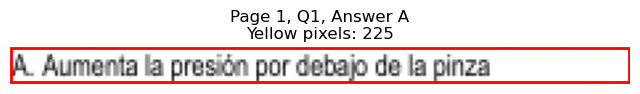

Page 1, Q1 - B: Detected box: x0=56.6, y0=102.0, x1=226.8, y1=114.7
Page 1, Q1, B: Yellow pixels: 2239
Page 1, Q1, B: Total non-white pixels: 2873
Page 1, Q1, B: Yellow percentage: 77.9%


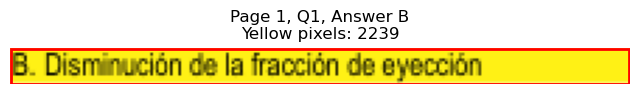

Page 1, Q1 - C: Detected box: x0=315.4, y0=89.4, x1=510.6, y1=102.1
Page 1, Q1, C: Yellow pixels: 0
Page 1, Q1, C: Total non-white pixels: 944
Page 1, Q1, C: Yellow percentage: 0.0%


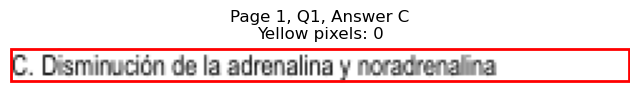

Page 1, Q1 - D: Detected box: x0=315.4, y0=102.0, x1=497.6, y1=114.7
Page 1, Q1, D: Yellow pixels: 0
Page 1, Q1, D: Total non-white pixels: 909
Page 1, Q1, D: Yellow percentage: 0.0%


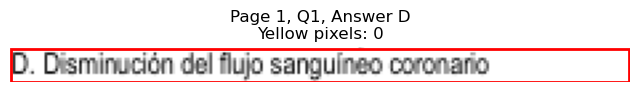


Page 1, Q1 - Selected Answer: B (based on yellow pixel count)
Page 1, Q2 - A: Detected box: x0=56.6, y0=139.9, x1=168.6, y1=152.6
Page 1, Q2, A: Yellow pixels: 163
Page 1, Q2, A: Total non-white pixels: 711
Page 1, Q2, A: Yellow percentage: 22.9%


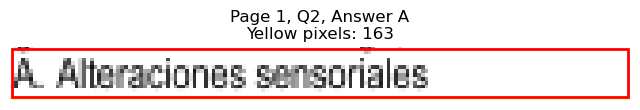

Page 1, Q2 - B: Detected box: x0=56.6, y0=152.5, x1=179.2, y1=165.2
Page 1, Q2, B: Yellow pixels: 1818
Page 1, Q2, B: Total non-white pixels: 2436
Page 1, Q2, B: Yellow percentage: 74.6%


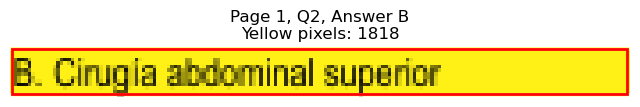

Page 1, Q2 - C: Detected box: x0=315.4, y0=139.9, x1=379.7, y1=152.6
Page 1, Q2, C: Yellow pixels: 0
Page 1, Q2, C: Total non-white pixels: 310
Page 1, Q2, C: Yellow percentage: 0.0%


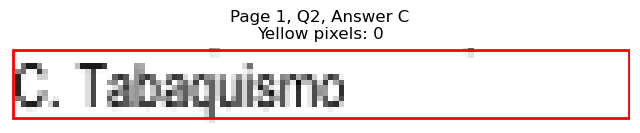

Page 1, Q2 - D: Detected box: x0=315.4, y0=152.5, x1=410.8, y1=165.2
Page 1, Q2, D: Yellow pixels: 0
Page 1, Q2, D: Total non-white pixels: 475
Page 1, Q2, D: Yellow percentage: 0.0%


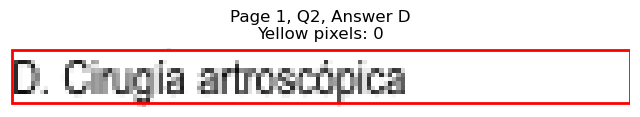


Page 1, Q2 - Selected Answer: B (based on yellow pixel count)
Page 1, Q3 - A: Detected box: x0=56.6, y0=190.3, x1=143.1, y1=203.0
Page 1, Q3, A: Yellow pixels: 1433
Page 1, Q3, A: Total non-white pixels: 1794
Page 1, Q3, A: Yellow percentage: 79.9%


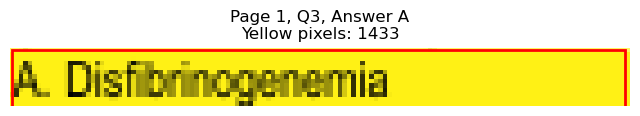

Page 1, Q3 - B: Detected box: x0=56.6, y0=202.9, x1=140.5, y1=215.6
Page 1, Q3, B: Yellow pixels: 131
Page 1, Q3, B: Total non-white pixels: 564
Page 1, Q3, B: Yellow percentage: 23.2%


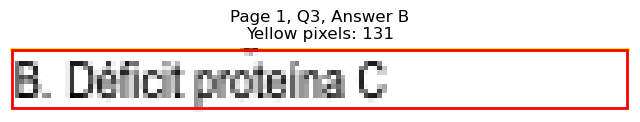

Page 1, Q3 - C: Detected box: x0=315.4, y0=190.3, x1=419.8, y1=203.0
Page 1, Q3, C: Yellow pixels: 0
Page 1, Q3, C: Total non-white pixels: 511
Page 1, Q3, C: Yellow percentage: 0.0%


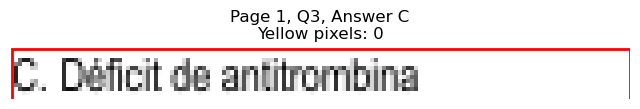

Page 1, Q3 - D: Detected box: x0=315.4, y0=202.9, x1=486.6, y1=215.6
Page 1, Q3, D: Yellow pixels: 0
Page 1, Q3, D: Total non-white pixels: 843
Page 1, Q3, D: Yellow percentage: 0.0%


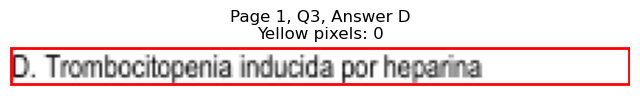


Page 1, Q3 - Selected Answer: A (based on yellow pixel count)
Page 1, Q4 - A: Detected box: x0=56.6, y0=253.4, x1=121.9, y1=266.1
Page 1, Q4, A: Yellow pixels: 1266
Page 1, Q4, A: Total non-white pixels: 1624
Page 1, Q4, A: Yellow percentage: 78.0%


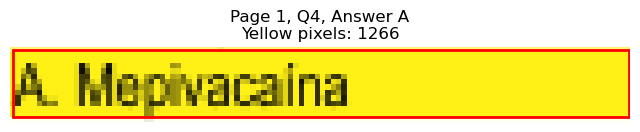

Page 1, Q4 - B: Detected box: x0=56.6, y0=266.0, x1=106.9, y1=278.7
Page 1, Q4, B: Yellow pixels: 0
Page 1, Q4, B: Total non-white pixels: 324
Page 1, Q4, B: Yellow percentage: 0.0%


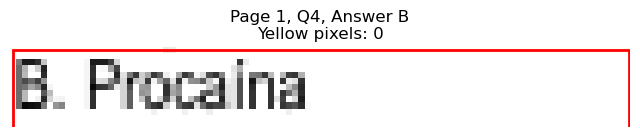

Page 1, Q4 - C: Detected box: x0=315.4, y0=253.4, x1=381.7, y1=266.1
Page 1, Q4, C: Yellow pixels: 0
Page 1, Q4, C: Total non-white pixels: 316
Page 1, Q4, C: Yellow percentage: 0.0%


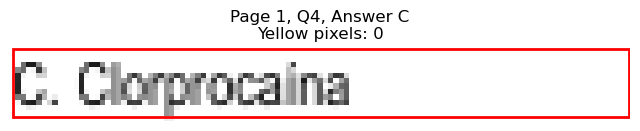

Page 1, Q4 - D: Detected box: x0=315.4, y0=266.0, x1=373.1, y1=278.7
Page 1, Q4, D: Yellow pixels: 0
Page 1, Q4, D: Total non-white pixels: 258
Page 1, Q4, D: Yellow percentage: 0.0%


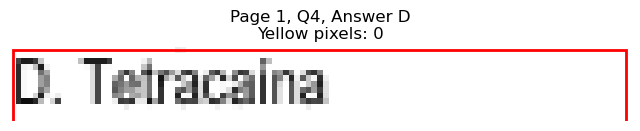


Page 1, Q4 - Selected Answer: A (based on yellow pixel count)
Page 1, Q5 - A: Detected box: x0=56.6, y0=341.9, x1=156.0, y1=354.6
Page 1, Q5, A: Yellow pixels: 0
Page 1, Q5, A: Total non-white pixels: 519
Page 1, Q5, A: Yellow percentage: 0.0%


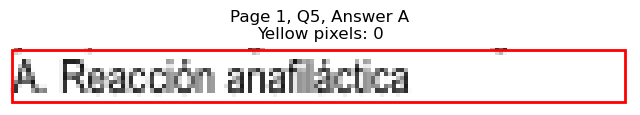

Page 1, Q5 - B: Detected box: x0=56.6, y0=354.5, x1=151.6, y1=367.2
Page 1, Q5, B: Yellow pixels: 0
Page 1, Q5, B: Total non-white pixels: 462
Page 1, Q5, B: Yellow percentage: 0.0%


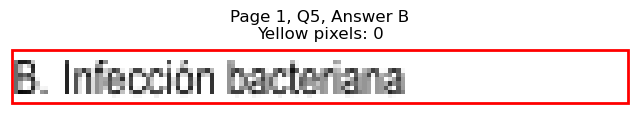

Page 1, Q5 - C: Detected box: x0=315.4, y0=341.9, x1=422.8, y1=354.6
Page 1, Q5, C: Yellow pixels: 158
Page 1, Q5, C: Total non-white pixels: 689
Page 1, Q5, C: Yellow percentage: 22.9%


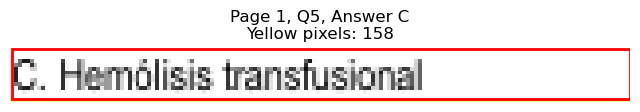

Page 1, Q5 - D: Detected box: x0=315.4, y0=354.5, x1=424.4, y1=367.2
Page 1, Q5, D: Yellow pixels: 1701
Page 1, Q5, D: Total non-white pixels: 2240
Page 1, Q5, D: Yellow percentage: 75.9%


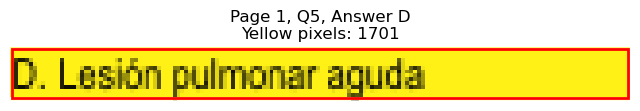


Page 1, Q5 - Selected Answer: D (based on yellow pixel count)
Page 1, Q6 - A: Detected box: x0=56.6, y0=417.6, x1=80.9, y1=430.3
Page 1, Q6, A: Yellow pixels: 0
Page 1, Q6, A: Total non-white pixels: 104
Page 1, Q6, A: Yellow percentage: 0.0%


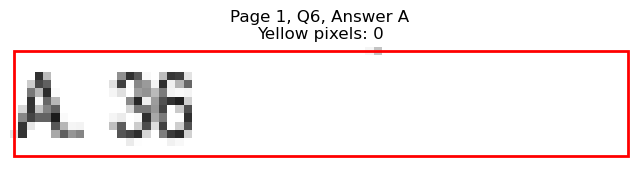

Page 1, Q6 - B: Detected box: x0=56.6, y0=430.2, x1=80.9, y1=442.9
Page 1, Q6, B: Yellow pixels: 0
Page 1, Q6, B: Total non-white pixels: 100
Page 1, Q6, B: Yellow percentage: 0.0%


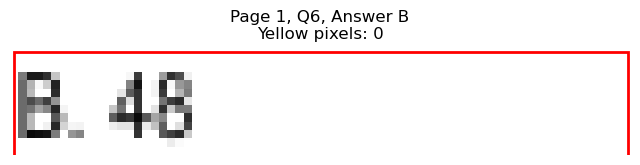

Page 1, Q6 - C: Detected box: x0=315.4, y0=417.6, x1=340.1, y1=430.3
Page 1, Q6, C: Yellow pixels: 843
Page 1, Q6, C: Total non-white pixels: 1064
Page 1, Q6, C: Yellow percentage: 79.2%


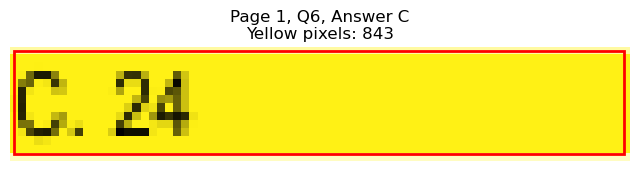

Page 1, Q6 - D: Detected box: x0=315.4, y0=430.2, x1=340.1, y1=442.9
Page 1, Q6, D: Yellow pixels: 0
Page 1, Q6, D: Total non-white pixels: 164
Page 1, Q6, D: Yellow percentage: 0.0%


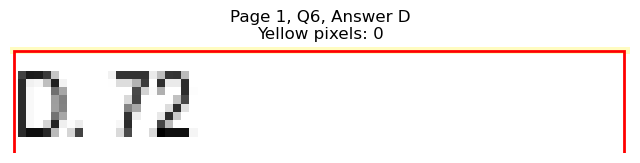


Page 1, Q6 - Selected Answer: C (based on yellow pixel count)
Page 1, Q7 - A: Detected box: x0=56.6, y0=468.1, x1=112.0, y1=480.7
Page 1, Q7, A: Yellow pixels: 1189
Page 1, Q7, A: Total non-white pixels: 1378
Page 1, Q7, A: Yellow percentage: 86.3%


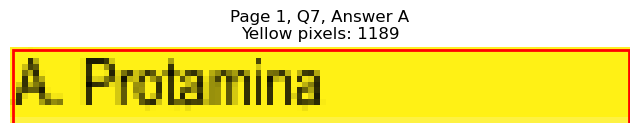

Page 1, Q7 - B: Detected box: x0=56.6, y0=480.8, x1=114.5, y1=493.4
Page 1, Q7, B: Yellow pixels: 109
Page 1, Q7, B: Total non-white pixels: 353
Page 1, Q7, B: Yellow percentage: 30.9%


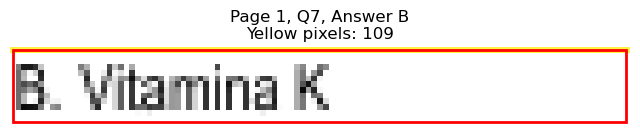

Page 1, Q7 - C: Detected box: x0=315.4, y0=468.1, x1=384.2, y1=480.7
Page 1, Q7, C: Yellow pixels: 0
Page 1, Q7, C: Total non-white pixels: 333
Page 1, Q7, C: Yellow percentage: 0.0%


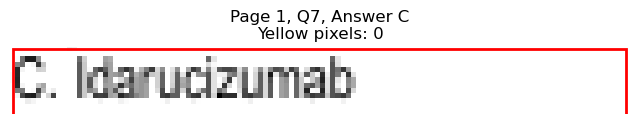

Page 1, Q7 - D: Detected box: x0=315.4, y0=480.8, x1=390.3, y1=493.4
Page 1, Q7, D: Yellow pixels: 0
Page 1, Q7, D: Total non-white pixels: 343
Page 1, Q7, D: Yellow percentage: 0.0%


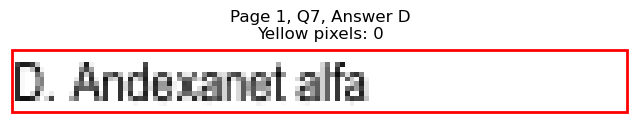


Page 1, Q7 - Selected Answer: A (based on yellow pixel count)
Page 1, Q8 - A: Detected box: x0=76.5, y0=518.6, x1=139.2, y1=531.2
Page 1, Q8, A: Yellow pixels: 0
Page 1, Q8, A: Total non-white pixels: 288
Page 1, Q8, A: Yellow percentage: 0.0%


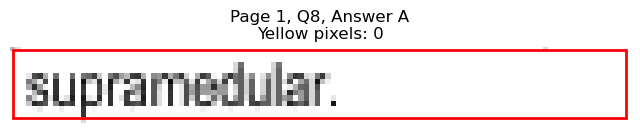

Page 1, Q8 - B: Detected box: x0=77.5, y0=531.2, x1=119.2, y1=543.8
Page 1, Q8, B: Yellow pixels: 0
Page 1, Q8, B: Total non-white pixels: 202
Page 1, Q8, B: Yellow percentage: 0.0%


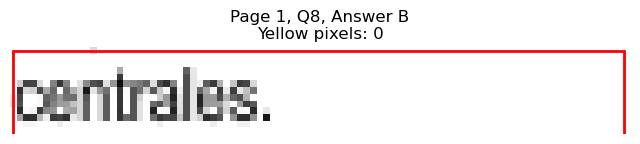

Page 1, Q8 - C: Detected box: x0=315.4, y0=518.6, x1=381.2, y1=531.2
Page 1, Q8, C: Yellow pixels: 117
Page 1, Q8, C: Total non-white pixels: 410
Page 1, Q8, C: Yellow percentage: 28.5%


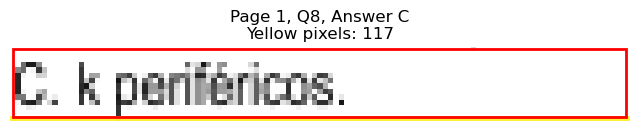

Page 1, Q8 - D: Detected box: x0=315.4, y0=531.2, x1=378.1, y1=543.8
Page 1, Q8, D: Yellow pixels: 1273
Page 1, Q8, D: Total non-white pixels: 1482
Page 1, Q8, D: Yellow percentage: 85.9%


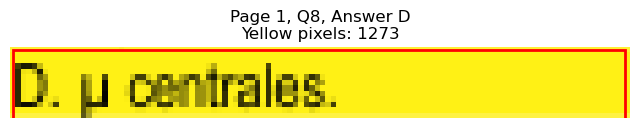


Page 1, Q8 - Selected Answer: D (based on yellow pixel count)
Page 1, Q9 - A: Detected box: x0=56.6, y0=569.1, x1=129.0, y1=581.7
Page 1, Q9, A: Yellow pixels: 0
Page 1, Q9, A: Total non-white pixels: 326
Page 1, Q9, A: Yellow percentage: 0.0%


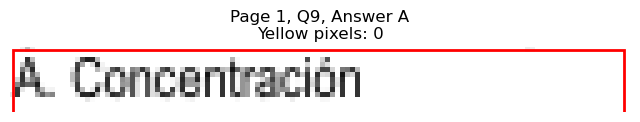

Page 1, Q9 - B: Detected box: x0=56.6, y0=581.7, x1=91.8, y1=594.3
Page 1, Q9, B: Yellow pixels: 0
Page 1, Q9, B: Total non-white pixels: 155
Page 1, Q9, B: Yellow percentage: 0.0%


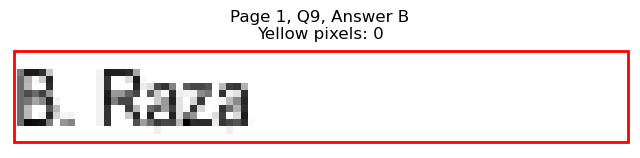

Page 1, Q9 - C: Detected box: x0=315.4, y0=569.1, x1=365.7, y1=581.7
Page 1, Q9, C: Yellow pixels: 0
Page 1, Q9, C: Total non-white pixels: 317
Page 1, Q9, C: Yellow percentage: 0.0%


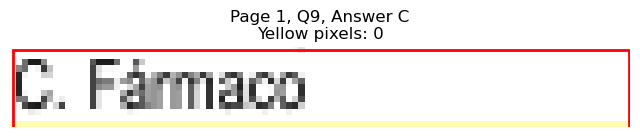

Page 1, Q9 - D: Detected box: x0=315.4, y0=581.7, x1=392.8, y1=594.3
Page 1, Q9, D: Yellow pixels: 1268
Page 1, Q9, D: Total non-white pixels: 1792
Page 1, Q9, D: Yellow percentage: 70.8%


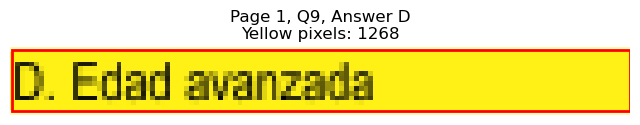


Page 1, Q9 - Selected Answer: D (based on yellow pixel count)
Page 1, Q10 - A: Detected box: x0=56.6, y0=632.2, x1=178.1, y1=644.9
Page 1, Q10, A: Yellow pixels: 0
Page 1, Q10, A: Total non-white pixels: 604
Page 1, Q10, A: Yellow percentage: 0.0%


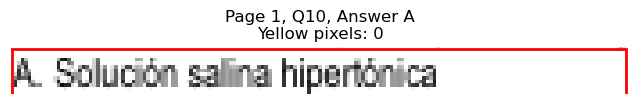

Page 1, Q10 - B: Detected box: x0=56.6, y0=644.8, x1=118.5, y1=657.5
Page 1, Q10, B: Yellow pixels: 0
Page 1, Q10, B: Total non-white pixels: 295
Page 1, Q10, B: Yellow percentage: 0.0%


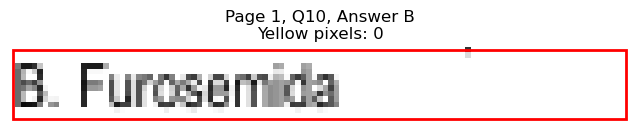

Page 1, Q10 - C: Detected box: x0=315.4, y0=632.2, x1=359.1, y1=644.9
Page 1, Q10, C: Yellow pixels: 1070
Page 1, Q10, C: Total non-white pixels: 1235
Page 1, Q10, C: Yellow percentage: 86.6%


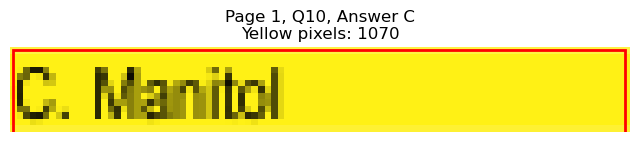

Page 1, Q10 - D: Detected box: x0=315.4, y0=644.8, x1=391.3, y1=657.5
Page 1, Q10, D: Yellow pixels: 0
Page 1, Q10, D: Total non-white pixels: 358
Page 1, Q10, D: Yellow percentage: 0.0%


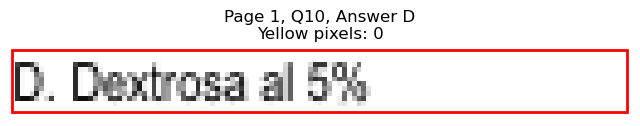


Page 1, Q10 - Selected Answer: C (based on yellow pixel count)
Page 1, Q11 - A: Detected box: x0=56.6, y0=695.4, x1=107.9, y1=708.0
Page 1, Q11, A: Yellow pixels: 0
Page 1, Q11, A: Total non-white pixels: 234
Page 1, Q11, A: Yellow percentage: 0.0%


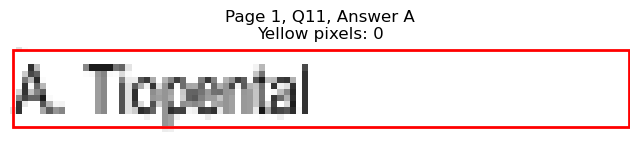

Page 1, Q11 - B: Detected box: x0=56.6, y0=708.0, x1=107.9, y1=720.6
Page 1, Q11, B: Yellow pixels: 0
Page 1, Q11, B: Total non-white pixels: 224
Page 1, Q11, B: Yellow percentage: 0.0%


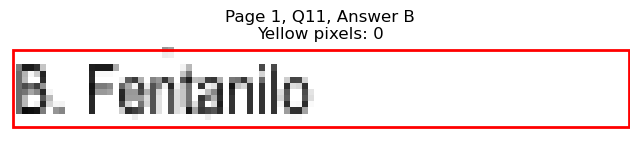

Page 1, Q11 - C: Detected box: x0=315.4, y0=695.4, x1=373.6, y1=708.0
Page 1, Q11, C: Yellow pixels: 109
Page 1, Q11, C: Total non-white pixels: 499
Page 1, Q11, C: Yellow percentage: 21.8%


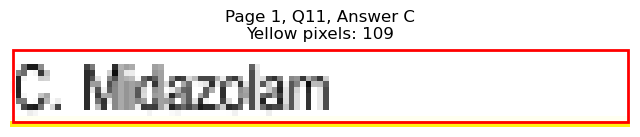

Page 1, Q11 - D: Detected box: x0=315.4, y0=708.0, x1=363.7, y1=720.6
Page 1, Q11, D: Yellow pixels: 1119
Page 1, Q11, D: Total non-white pixels: 1386
Page 1, Q11, D: Yellow percentage: 80.7%


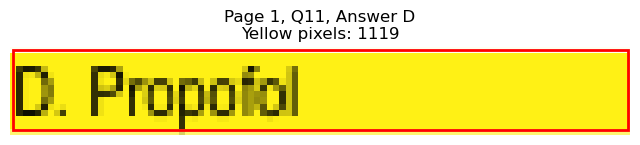


Page 1, Q11 - Selected Answer: D (based on yellow pixel count)
Page 1, Q12 - A: Detected box: x0=56.6, y0=745.8, x1=126.1, y1=758.4
Page 1, Q12, A: Yellow pixels: 0
Page 1, Q12, A: Total non-white pixels: 331
Page 1, Q12, A: Yellow percentage: 0.0%


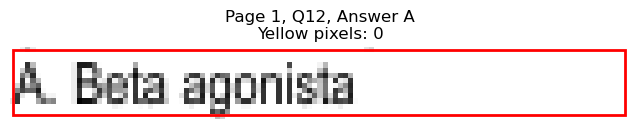

Page 1, Q12 - B: Detected box: x0=56.6, y0=758.5, x1=130.5, y1=771.1
Page 1, Q12, B: Yellow pixels: 1334
Page 1, Q12, B: Total non-white pixels: 1750
Page 1, Q12, B: Yellow percentage: 76.2%


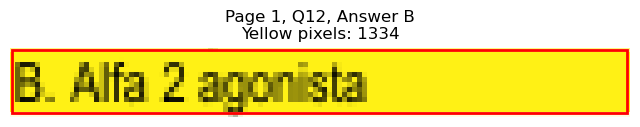

Page 1, Q12 - C: Detected box: x0=315.4, y0=745.8, x1=386.7, y1=758.4
Page 1, Q12, C: Yellow pixels: 0
Page 1, Q12, C: Total non-white pixels: 358
Page 1, Q12, C: Yellow percentage: 0.0%


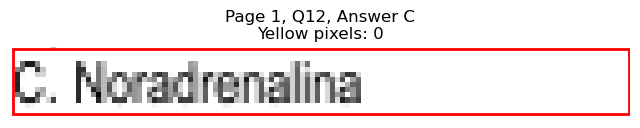

Page 1, Q12 - D: Detected box: x0=315.4, y0=758.5, x1=373.1, y1=771.1
Page 1, Q12, D: Yellow pixels: 0
Page 1, Q12, D: Total non-white pixels: 264
Page 1, Q12, D: Yellow percentage: 0.0%


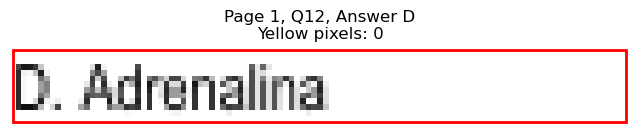


Page 1, Q12 - Selected Answer: B (based on yellow pixel count)

Page 2: Found 11 questions
Page 2, Q1 - A: Detected box: x0=56.6, y0=89.4, x1=107.9, y1=102.1
Page 2, Q1, A: Yellow pixels: 0
Page 2, Q1, A: Total non-white pixels: 219
Page 2, Q1, A: Yellow percentage: 0.0%


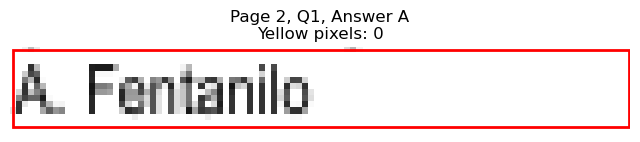

Page 2, Q1 - B: Detected box: x0=56.6, y0=102.0, x1=114.4, y1=114.7
Page 2, Q1, B: Yellow pixels: 0
Page 2, Q1, B: Total non-white pixels: 289
Page 2, Q1, B: Yellow percentage: 0.0%


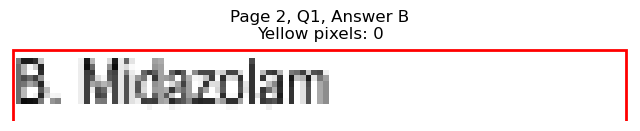

Page 2, Q1 - C: Detected box: x0=315.4, y0=89.4, x1=368.2, y1=102.1
Page 2, Q1, C: Yellow pixels: 1175
Page 2, Q1, C: Total non-white pixels: 1456
Page 2, Q1, C: Yellow percentage: 80.7%


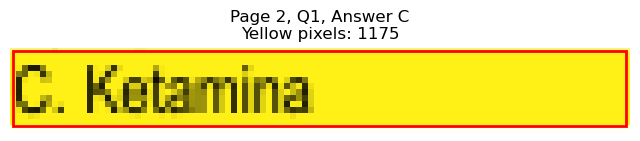

Page 2, Q1 - D: Detected box: x0=315.4, y0=102.0, x1=385.7, y1=114.7
Page 2, Q1, D: Yellow pixels: 0
Page 2, Q1, D: Total non-white pixels: 453
Page 2, Q1, D: Yellow percentage: 0.0%


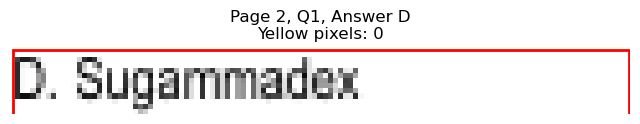


Page 2, Q1 - Selected Answer: C (based on yellow pixel count)
Page 2, Q2 - A: Detected box: x0=56.6, y0=139.9, x1=182.2, y1=152.6
Page 2, Q2, A: Yellow pixels: 0
Page 2, Q2, A: Total non-white pixels: 584
Page 2, Q2, A: Yellow percentage: 0.0%


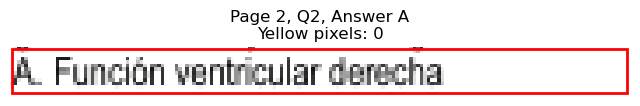

Page 2, Q2 - B: Detected box: x0=56.6, y0=152.5, x1=176.2, y1=165.2
Page 2, Q2, B: Yellow pixels: 0
Page 2, Q2, B: Total non-white pixels: 614
Page 2, Q2, B: Yellow percentage: 0.0%


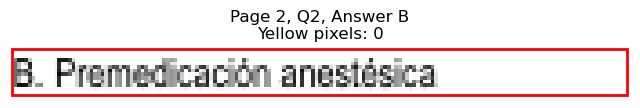

Page 2, Q2 - C: Detected box: x0=315.4, y0=139.9, x1=429.3, y1=152.6
Page 2, Q2, C: Yellow pixels: 1736
Page 2, Q2, C: Total non-white pixels: 2310
Page 2, Q2, C: Yellow percentage: 75.2%


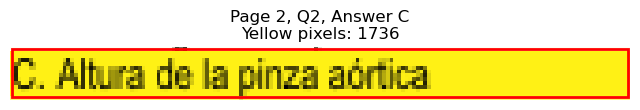

Page 2, Q2 - D: Detected box: x0=315.4, y0=152.5, x1=441.4, y1=165.2
Page 2, Q2, D: Yellow pixels: 177
Page 2, Q2, D: Total non-white pixels: 789
Page 2, Q2, D: Yellow percentage: 22.4%


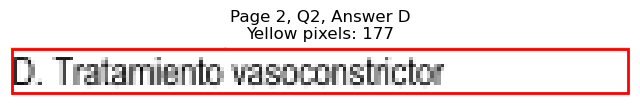


Page 2, Q2 - Selected Answer: C (based on yellow pixel count)
Page 2, Q3 - A: Detected box: x0=56.6, y0=202.9, x1=116.4, y1=215.6
Page 2, Q3, A: Yellow pixels: 0
Page 2, Q3, A: Total non-white pixels: 280
Page 2, Q3, A: Yellow percentage: 0.0%


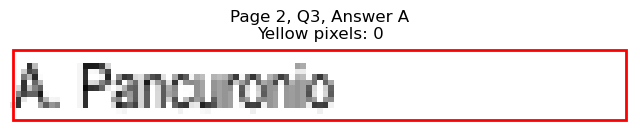

Page 2, Q3 - B: Detected box: x0=56.6, y0=215.6, x1=115.5, y1=228.3
Page 2, Q3, B: Yellow pixels: 0
Page 2, Q3, B: Total non-white pixels: 302
Page 2, Q3, B: Yellow percentage: 0.0%


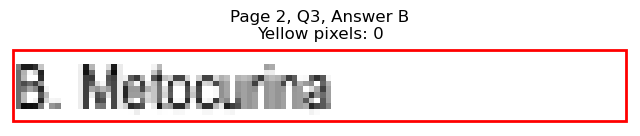

Page 2, Q3 - C: Detected box: x0=315.4, y0=202.9, x1=368.7, y1=215.6
Page 2, Q3, C: Yellow pixels: 1152
Page 2, Q3, C: Total non-white pixels: 1456
Page 2, Q3, C: Yellow percentage: 79.1%


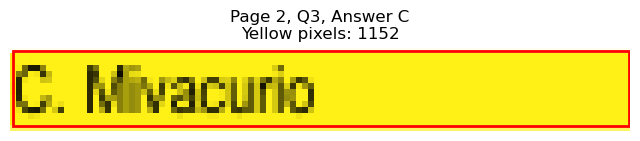

Page 2, Q3 - D: Detected box: x0=315.4, y0=215.6, x1=378.2, y1=228.3
Page 2, Q3, D: Yellow pixels: 114
Page 2, Q3, D: Total non-white pixels: 417
Page 2, Q3, D: Yellow percentage: 27.3%


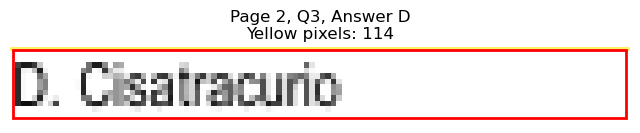


Page 2, Q3 - Selected Answer: C (based on yellow pixel count)
Page 2, Q4 - A: Detected box: x0=56.6, y0=253.4, x1=115.9, y1=266.1
Page 2, Q4, A: Yellow pixels: 110
Page 2, Q4, A: Total non-white pixels: 391
Page 2, Q4, A: Yellow percentage: 28.1%


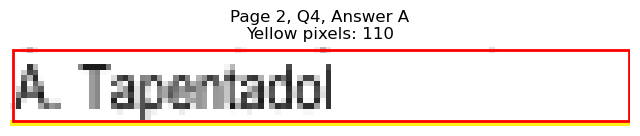

Page 2, Q4 - B: Detected box: x0=56.6, y0=266.0, x1=115.5, y1=278.7
Page 2, Q4, B: Yellow pixels: 1168
Page 2, Q4, B: Total non-white pixels: 1430
Page 2, Q4, B: Yellow percentage: 81.7%


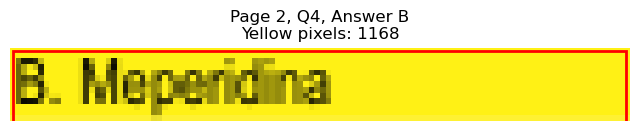

Page 2, Q4 - C: Detected box: x0=315.4, y0=253.4, x1=368.2, y1=266.1
Page 2, Q4, C: Yellow pixels: 0
Page 2, Q4, C: Total non-white pixels: 233
Page 2, Q4, C: Yellow percentage: 0.0%


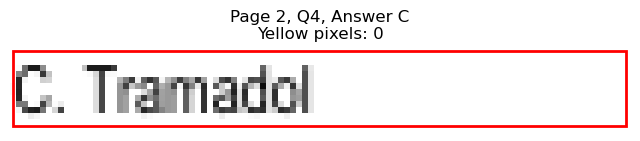

Page 2, Q4 - D: Detected box: x0=315.4, y0=266.0, x1=368.2, y1=278.7
Page 2, Q4, D: Yellow pixels: 0
Page 2, Q4, D: Total non-white pixels: 245
Page 2, Q4, D: Yellow percentage: 0.0%


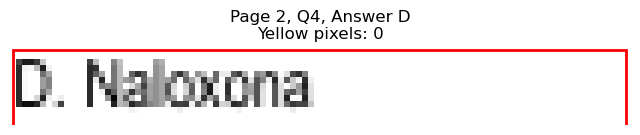


Page 2, Q4 - Selected Answer: B (based on yellow pixel count)
Page 2, Q5 - A: Detected box: x0=56.6, y0=329.2, x1=80.9, y1=341.8
Page 2, Q5, A: Yellow pixels: 0
Page 2, Q5, A: Total non-white pixels: 86
Page 2, Q5, A: Yellow percentage: 0.0%


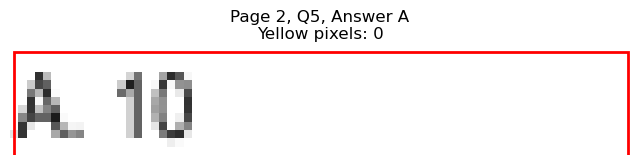

Page 2, Q5 - B: Detected box: x0=56.6, y0=341.9, x1=75.9, y1=354.6
Page 2, Q5, B: Yellow pixels: 848
Page 2, Q5, B: Total non-white pixels: 980
Page 2, Q5, B: Yellow percentage: 86.5%


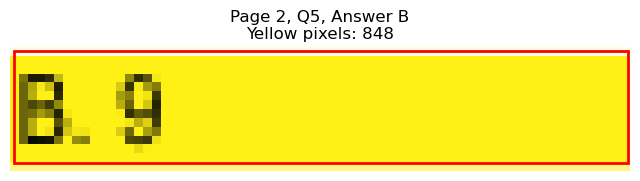

Page 2, Q5 - C: Detected box: x0=315.4, y0=329.2, x1=340.1, y1=341.8
Page 2, Q5, C: Yellow pixels: 0
Page 2, Q5, C: Total non-white pixels: 64
Page 2, Q5, C: Yellow percentage: 0.0%


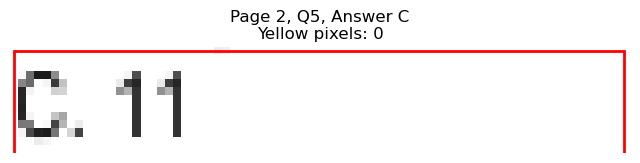

Page 2, Q5 - D: Detected box: x0=315.4, y0=341.9, x1=335.1, y1=354.6
Page 2, Q5, D: Yellow pixels: 0
Page 2, Q5, D: Total non-white pixels: 73
Page 2, Q5, D: Yellow percentage: 0.0%


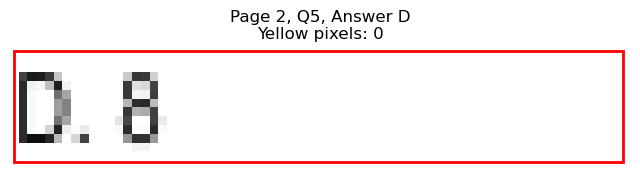


Page 2, Q5 - Selected Answer: B (based on yellow pixel count)
Page 2, Q6 - A: Detected box: x0=56.6, y0=379.7, x1=152.1, y1=392.4
Page 2, Q6, A: Yellow pixels: 1411
Page 2, Q6, A: Total non-white pixels: 2058
Page 2, Q6, A: Yellow percentage: 68.6%


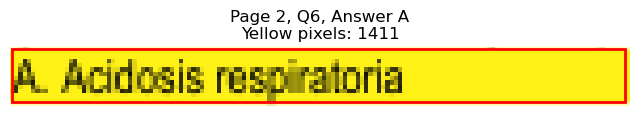

Page 2, Q6 - B: Detected box: x0=56.6, y0=392.3, x1=138.6, y1=405.0
Page 2, Q6, B: Yellow pixels: 0
Page 2, Q6, B: Total non-white pixels: 493
Page 2, Q6, B: Yellow percentage: 0.0%


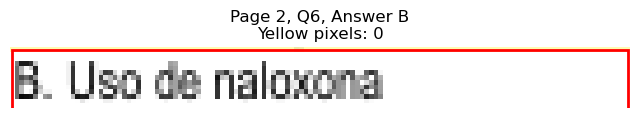

Page 2, Q6 - C: Detected box: x0=315.4, y0=379.7, x1=439.0, y1=392.4
Page 2, Q6, C: Yellow pixels: 0
Page 2, Q6, C: Total non-white pixels: 637
Page 2, Q6, C: Yellow percentage: 0.0%


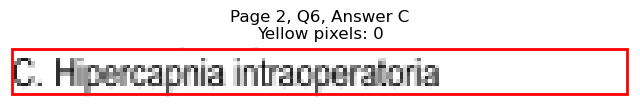

Page 2, Q6 - D: Detected box: x0=315.4, y0=392.3, x1=403.4, y1=405.0
Page 2, Q6, D: Yellow pixels: 0
Page 2, Q6, D: Total non-white pixels: 415
Page 2, Q6, D: Yellow percentage: 0.0%


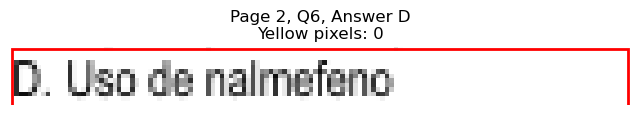


Page 2, Q6 - Selected Answer: A (based on yellow pixel count)
Page 2, Q7 - A: Detected box: x0=56.6, y0=455.5, x1=131.5, y1=468.1
Page 2, Q7, A: Yellow pixels: 126
Page 2, Q7, A: Total non-white pixels: 455
Page 2, Q7, A: Yellow percentage: 27.7%


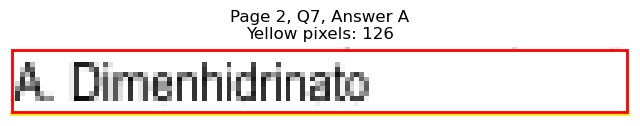

Page 2, Q7 - B: Detected box: x0=56.6, y0=468.1, x1=111.4, y1=480.7
Page 2, Q7, B: Yellow pixels: 1155
Page 2, Q7, B: Total non-white pixels: 1378
Page 2, Q7, B: Yellow percentage: 83.8%


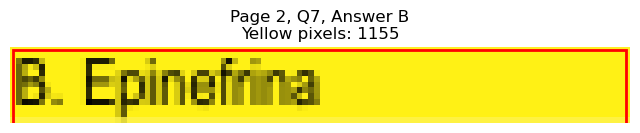

Page 2, Q7 - C: Detected box: x0=315.4, y0=455.5, x1=371.2, y1=468.1
Page 2, Q7, C: Yellow pixels: 0
Page 2, Q7, C: Total non-white pixels: 264
Page 2, Q7, C: Yellow percentage: 0.0%


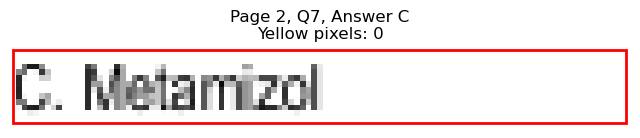

Page 2, Q7 - D: Detected box: x0=315.4, y0=468.1, x1=394.3, y1=480.7
Page 2, Q7, D: Yellow pixels: 0
Page 2, Q7, D: Total non-white pixels: 375
Page 2, Q7, D: Yellow percentage: 0.0%


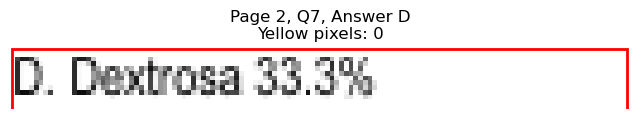


Page 2, Q7 - Selected Answer: B (based on yellow pixel count)
Page 2, Q8 - A: Detected box: x0=56.6, y0=531.2, x1=178.1, y1=543.8
Page 2, Q8, A: Yellow pixels: 1810
Page 2, Q8, A: Total non-white pixels: 2249
Page 2, Q8, A: Yellow percentage: 80.5%


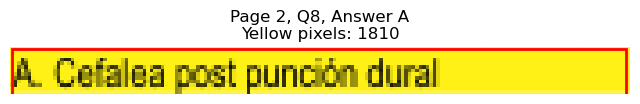

Page 2, Q8 - B: Detected box: x0=56.6, y0=543.8, x1=155.1, y1=556.4
Page 2, Q8, B: Yellow pixels: 147
Page 2, Q8, B: Total non-white pixels: 639
Page 2, Q8, B: Yellow percentage: 23.0%


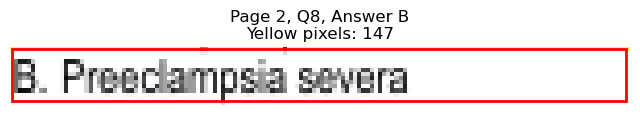

Page 2, Q8 - C: Detected box: x0=315.4, y0=531.2, x1=412.7, y1=543.8
Page 2, Q8, C: Yellow pixels: 0
Page 2, Q8, C: Total non-white pixels: 460
Page 2, Q8, C: Yellow percentage: 0.0%


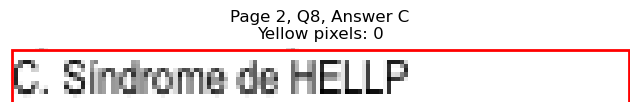

Page 2, Q8 - D: Detected box: x0=315.4, y0=543.8, x1=403.7, y1=556.4
Page 2, Q8, D: Yellow pixels: 0
Page 2, Q8, D: Total non-white pixels: 444
Page 2, Q8, D: Yellow percentage: 0.0%


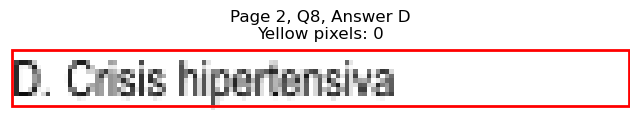


Page 2, Q8 - Selected Answer: A (based on yellow pixel count)
Page 2, Q9 - A: Detected box: x0=56.6, y0=606.9, x1=101.9, y1=619.5
Page 2, Q9, A: Yellow pixels: 0
Page 2, Q9, A: Total non-white pixels: 222
Page 2, Q9, A: Yellow percentage: 0.0%


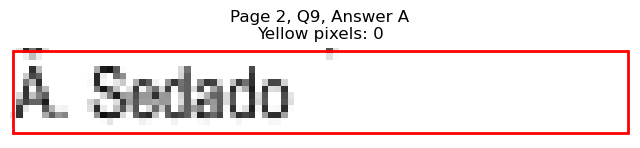

Page 2, Q9 - B: Detected box: x0=56.6, y0=619.6, x1=135.0, y1=632.3
Page 2, Q9, B: Yellow pixels: 1257
Page 2, Q9, B: Total non-white pixels: 1820
Page 2, Q9, B: Yellow percentage: 69.1%


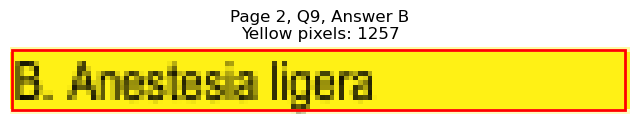

Page 2, Q9 - C: Detected box: x0=315.4, y0=606.9, x1=402.8, y1=619.5
Page 2, Q9, C: Yellow pixels: 0
Page 2, Q9, C: Total non-white pixels: 433
Page 2, Q9, C: Yellow percentage: 0.0%


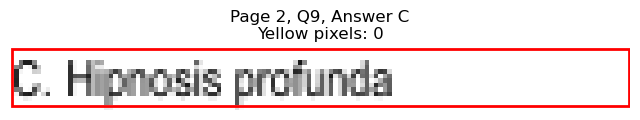

Page 2, Q9 - D: Detected box: x0=315.4, y0=619.6, x1=402.3, y1=632.3
Page 2, Q9, D: Yellow pixels: 0
Page 2, Q9, D: Total non-white pixels: 428
Page 2, Q9, D: Yellow percentage: 0.0%


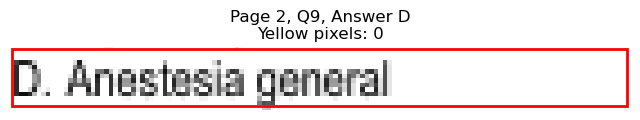


Page 2, Q9 - Selected Answer: B (based on yellow pixel count)
Page 2, Q10 - A: Detected box: x0=56.6, y0=670.0, x1=214.7, y1=682.7
Page 2, Q10, A: Yellow pixels: 0
Page 2, Q10, A: Total non-white pixels: 785
Page 2, Q10, A: Yellow percentage: 0.0%


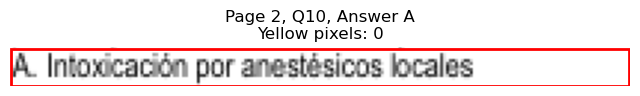

Page 2, Q10 - B: Detected box: x0=56.6, y0=682.6, x1=193.7, y1=695.3
Page 2, Q10, B: Yellow pixels: 0
Page 2, Q10, B: Total non-white pixels: 671
Page 2, Q10, B: Yellow percentage: 0.0%


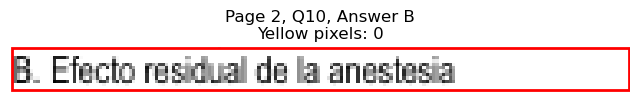

Page 2, Q10 - C: Detected box: x0=315.4, y0=670.0, x1=408.9, y1=682.7
Page 2, Q10, C: Yellow pixels: 1
Page 2, Q10, C: Total non-white pixels: 605
Page 2, Q10, C: Yellow percentage: 0.2%


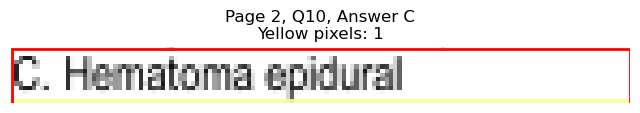

Page 2, Q10 - D: Detected box: x0=315.4, y0=682.6, x1=437.3, y1=695.3
Page 2, Q10, D: Yellow pixels: 1625
Page 2, Q10, D: Total non-white pixels: 2422
Page 2, Q10, D: Yellow percentage: 67.1%


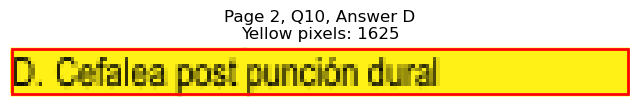


Page 2, Q10 - Selected Answer: D (based on yellow pixel count)
Page 2, Q11 - A: Detected box: x0=56.6, y0=720.6, x1=154.6, y1=733.2
Page 2, Q11, A: Yellow pixels: 0
Page 2, Q11, A: Total non-white pixels: 399
Page 2, Q11, A: Yellow percentage: 0.0%


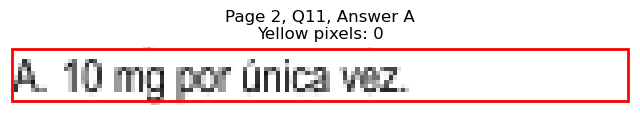

Page 2, Q11 - B: Detected box: x0=56.6, y0=733.2, x1=152.5, y1=745.8
Page 2, Q11, B: Yellow pixels: 0
Page 2, Q11, B: Total non-white pixels: 416
Page 2, Q11, B: Yellow percentage: 0.0%


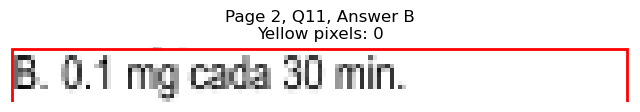

Page 2, Q11 - C: Detected box: x0=315.4, y0=720.6, x1=407.3, y1=733.2
Page 2, Q11, C: Yellow pixels: 1588
Page 2, Q11, C: Total non-white pixels: 2002
Page 2, Q11, C: Yellow percentage: 79.3%


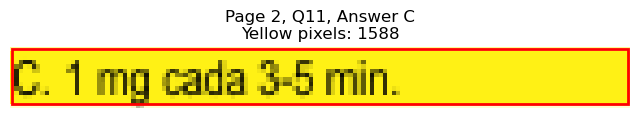

Page 2, Q11 - D: Detected box: x0=315.4, y0=733.2, x1=407.8, y1=745.8
Page 2, Q11, D: Yellow pixels: 0
Page 2, Q11, D: Total non-white pixels: 545
Page 2, Q11, D: Yellow percentage: 0.0%


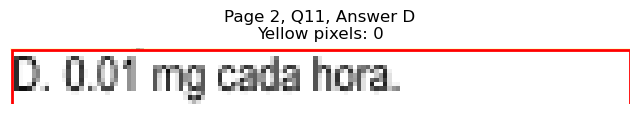


Page 2, Q11 - Selected Answer: C (based on yellow pixel count)

Page 3: Found 11 questions
Page 3, Q1 - A: Detected box: x0=56.6, y0=102.0, x1=103.5, y1=114.7
Page 3, Q1, A: Yellow pixels: 0
Page 3, Q1, A: Total non-white pixels: 222
Page 3, Q1, A: Yellow percentage: 0.0%


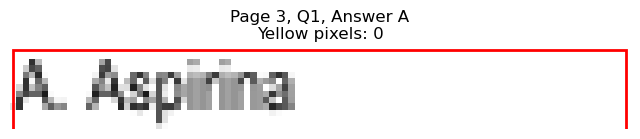

Page 3, Q1 - B: Detected box: x0=56.6, y0=114.6, x1=121.5, y1=127.3
Page 3, Q1, B: Yellow pixels: 0
Page 3, Q1, B: Total non-white pixels: 315
Page 3, Q1, B: Yellow percentage: 0.0%


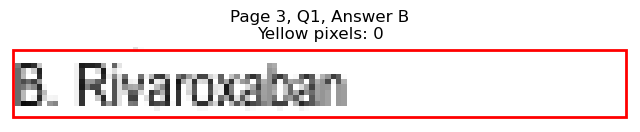

Page 3, Q1 - C: Detected box: x0=315.4, y0=102.0, x1=387.8, y1=114.7
Page 3, Q1, C: Yellow pixels: 0
Page 3, Q1, C: Total non-white pixels: 471
Page 3, Q1, C: Yellow percentage: 0.0%


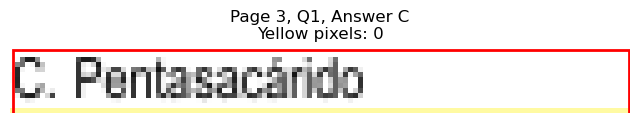

Page 3, Q1 - D: Detected box: x0=315.4, y0=114.6, x1=369.2, y1=127.3
Page 3, Q1, D: Yellow pixels: 1061
Page 3, Q1, D: Total non-white pixels: 1470
Page 3, Q1, D: Yellow percentage: 72.2%


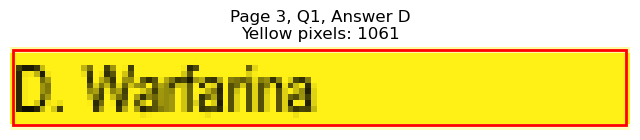


Page 3, Q1 - Selected Answer: D (based on yellow pixel count)
Page 3, Q2 - A: Detected box: x0=56.6, y0=165.1, x1=115.5, y1=177.8
Page 3, Q2, A: Yellow pixels: 0
Page 3, Q2, A: Total non-white pixels: 309
Page 3, Q2, A: Yellow percentage: 0.0%


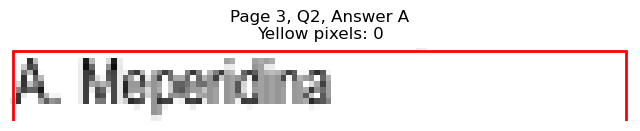

Page 3, Q2 - B: Detected box: x0=56.6, y0=177.7, x1=104.4, y1=190.4
Page 3, Q2, B: Yellow pixels: 0
Page 3, Q2, B: Total non-white pixels: 228
Page 3, Q2, B: Yellow percentage: 0.0%


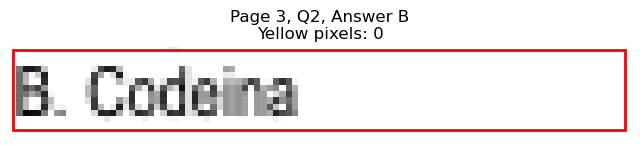

Page 3, Q2 - C: Detected box: x0=315.4, y0=165.1, x1=391.3, y1=177.8
Page 3, Q2, C: Yellow pixels: 1358
Page 3, Q2, C: Total non-white pixels: 1651
Page 3, Q2, C: Yellow percentage: 82.3%


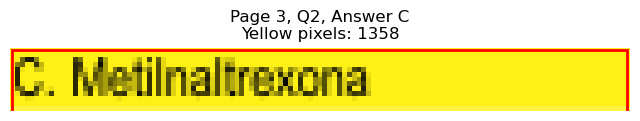

Page 3, Q2 - D: Detected box: x0=315.4, y0=177.7, x1=384.7, y1=190.4
Page 3, Q2, D: Yellow pixels: 120
Page 3, Q2, D: Total non-white pixels: 453
Page 3, Q2, D: Yellow percentage: 26.5%


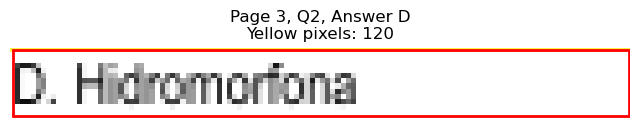


Page 3, Q2 - Selected Answer: C (based on yellow pixel count)
Page 3, Q3 - A: Detected box: x0=56.6, y0=215.6, x1=104.4, y1=228.3
Page 3, Q3, A: Yellow pixels: 0
Page 3, Q3, A: Total non-white pixels: 233
Page 3, Q3, A: Yellow percentage: 0.0%


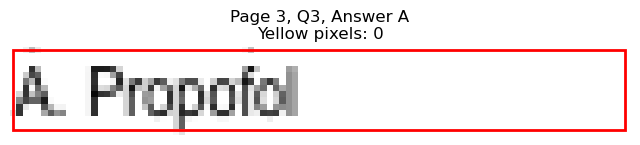

Page 3, Q3 - B: Detected box: x0=56.6, y0=228.2, x1=114.4, y1=240.9
Page 3, Q3, B: Yellow pixels: 0
Page 3, Q3, B: Total non-white pixels: 291
Page 3, Q3, B: Yellow percentage: 0.0%


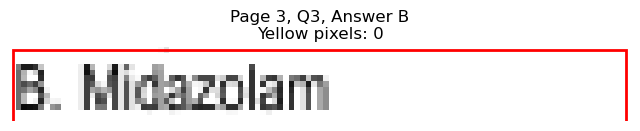

Page 3, Q3 - C: Detected box: x0=315.4, y0=215.6, x1=383.2, y1=228.3
Page 3, Q3, C: Yellow pixels: 119
Page 3, Q3, C: Total non-white pixels: 455
Page 3, Q3, C: Yellow percentage: 26.2%


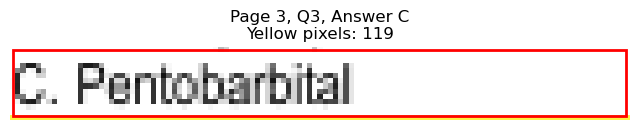

Page 3, Q3 - D: Detected box: x0=315.4, y0=228.2, x1=402.8, y1=240.9
Page 3, Q3, D: Yellow pixels: 1451
Page 3, Q3, D: Total non-white pixels: 1794
Page 3, Q3, D: Yellow percentage: 80.9%


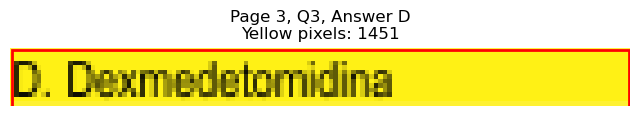


Page 3, Q3 - Selected Answer: D (based on yellow pixel count)
Page 3, Q4 - A: Detected box: x0=56.6, y0=291.4, x1=145.1, y1=304.0
Page 3, Q4, A: Yellow pixels: 0
Page 3, Q4, A: Total non-white pixels: 401
Page 3, Q4, A: Yellow percentage: 0.0%


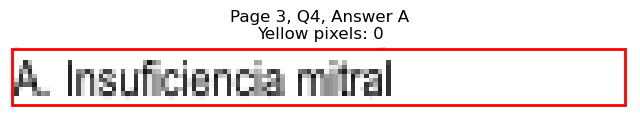

Page 3, Q4 - B: Detected box: x0=56.6, y0=304.0, x1=174.1, y1=316.6
Page 3, Q4, B: Yellow pixels: 0
Page 3, Q4, B: Total non-white pixels: 561
Page 3, Q4, B: Yellow percentage: 0.0%


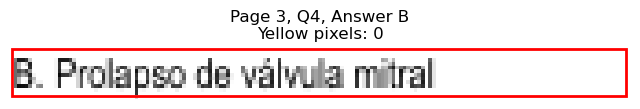

Page 3, Q4 - C: Detected box: x0=315.4, y0=291.4, x1=398.8, y1=304.0
Page 3, Q4, C: Yellow pixels: 134
Page 3, Q4, C: Total non-white pixels: 532
Page 3, Q4, C: Yellow percentage: 25.2%


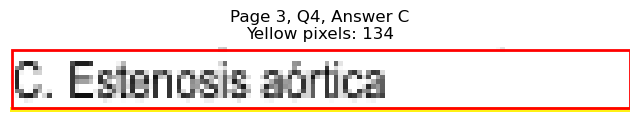

Page 3, Q4 - D: Detected box: x0=315.4, y0=304.0, x1=393.8, y1=316.6
Page 3, Q4, D: Yellow pixels: 1381
Page 3, Q4, D: Total non-white pixels: 1677
Page 3, Q4, D: Yellow percentage: 82.3%


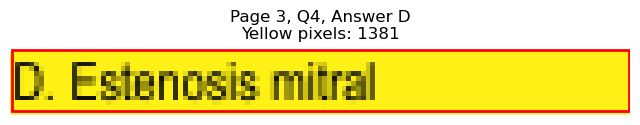


Page 3, Q4 - Selected Answer: D (based on yellow pixel count)
Page 3, Q5 - A: Detected box: x0=56.6, y0=367.1, x1=157.6, y1=379.8
Page 3, Q5, A: Yellow pixels: 0
Page 3, Q5, A: Total non-white pixels: 492
Page 3, Q5, A: Yellow percentage: 0.0%


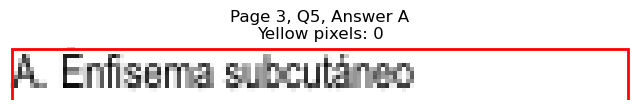

Page 3, Q5 - B: Detected box: x0=56.6, y0=379.7, x1=125.4, y1=392.4
Page 3, Q5, B: Yellow pixels: 0
Page 3, Q5, B: Total non-white pixels: 341
Page 3, Q5, B: Yellow percentage: 0.0%


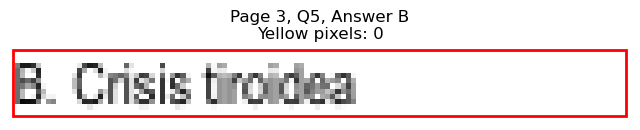

Page 3, Q5 - C: Detected box: x0=315.4, y0=367.1, x1=410.8, y1=379.8
Page 3, Q5, C: Yellow pixels: 1509
Page 3, Q5, C: Total non-white pixels: 1898
Page 3, Q5, C: Yellow percentage: 79.5%


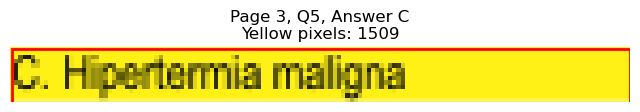

Page 3, Q5 - D: Detected box: x0=315.4, y0=379.7, x1=426.3, y1=392.4
Page 3, Q5, D: Yellow pixels: 161
Page 3, Q5, D: Total non-white pixels: 697
Page 3, Q5, D: Yellow percentage: 23.1%


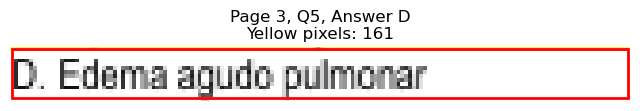


Page 3, Q5 - Selected Answer: C (based on yellow pixel count)
Page 3, Q6 - A: Detected box: x0=56.6, y0=417.6, x1=109.0, y1=430.3
Page 3, Q6, A: Yellow pixels: 1056
Page 3, Q6, A: Total non-white pixels: 1442
Page 3, Q6, A: Yellow percentage: 73.2%


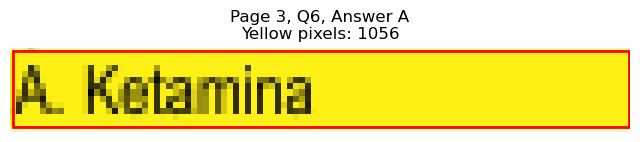

Page 3, Q6 - B: Detected box: x0=56.6, y0=430.2, x1=107.9, y1=442.9
Page 3, Q6, B: Yellow pixels: 0
Page 3, Q6, B: Total non-white pixels: 340
Page 3, Q6, B: Yellow percentage: 0.0%


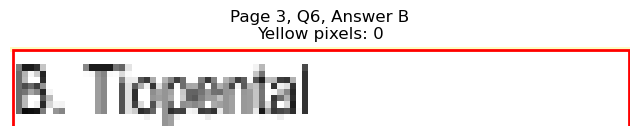

Page 3, Q6 - C: Detected box: x0=315.4, y0=417.6, x1=363.7, y1=430.3
Page 3, Q6, C: Yellow pixels: 0
Page 3, Q6, C: Total non-white pixels: 216
Page 3, Q6, C: Yellow percentage: 0.0%


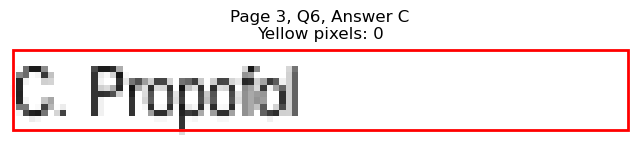

Page 3, Q6 - D: Detected box: x0=315.4, y0=430.2, x1=370.6, y1=442.9
Page 3, Q6, D: Yellow pixels: 0
Page 3, Q6, D: Total non-white pixels: 261
Page 3, Q6, D: Yellow percentage: 0.0%


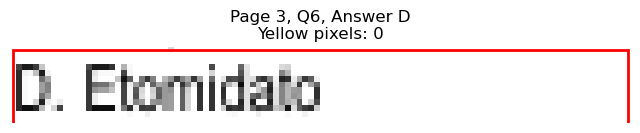


Page 3, Q6 - Selected Answer: A (based on yellow pixel count)
Page 3, Q7 - A: Detected box: x0=56.6, y0=480.8, x1=271.5, y1=493.4
Page 3, Q7, A: Yellow pixels: 8
Page 3, Q7, A: Total non-white pixels: 1086
Page 3, Q7, A: Yellow percentage: 0.7%


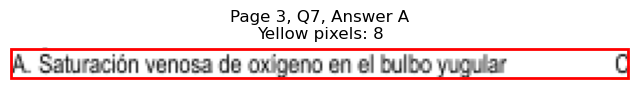

Page 3, Q7 - B: Detected box: x0=56.6, y0=493.4, x1=194.2, y1=506.0
Page 3, Q7, B: Yellow pixels: 0
Page 3, Q7, B: Total non-white pixels: 680
Page 3, Q7, B: Yellow percentage: 0.0%


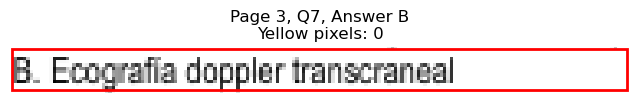

Page 3, Q7 - C: Detected box: x0=315.4, y0=480.8, x1=417.8, y1=493.4
Page 3, Q7, C: Yellow pixels: 153
Page 3, Q7, C: Total non-white pixels: 652
Page 3, Q7, C: Yellow percentage: 23.5%


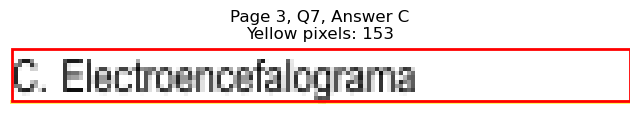

Page 3, Q7 - D: Detected box: x0=315.4, y0=493.4, x1=404.3, y1=506.0
Page 3, Q7, D: Yellow pixels: 1493
Page 3, Q7, D: Total non-white pixels: 1820
Page 3, Q7, D: Yellow percentage: 82.0%


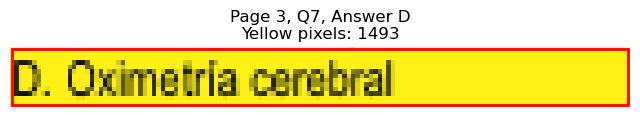


Page 3, Q7 - Selected Answer: D (based on yellow pixel count)
Page 3, Q8 - A: Detected box: x0=56.6, y0=543.8, x1=183.6, y1=556.4
Page 3, Q8, A: Yellow pixels: 1863
Page 3, Q8, A: Total non-white pixels: 2492
Page 3, Q8, A: Yellow percentage: 74.8%


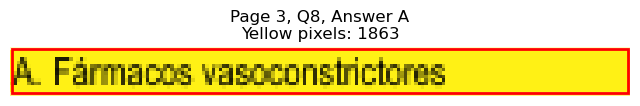

Page 3, Q8 - B: Detected box: x0=56.6, y0=556.5, x1=210.8, y1=569.1
Page 3, Q8, B: Yellow pixels: 205
Page 3, Q8, B: Total non-white pixels: 980
Page 3, Q8, B: Yellow percentage: 20.9%


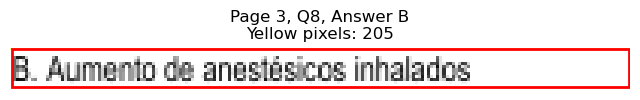

Page 3, Q8 - C: Detected box: x0=315.4, y0=543.8, x1=422.3, y1=556.4
Page 3, Q8, C: Yellow pixels: 0
Page 3, Q8, C: Total non-white pixels: 544
Page 3, Q8, C: Yellow percentage: 0.0%


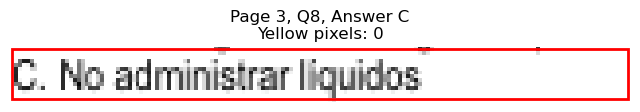

Page 3, Q8 - D: Detected box: x0=315.4, y0=556.5, x1=441.4, y1=569.1
Page 3, Q8, D: Yellow pixels: 0
Page 3, Q8, D: Total non-white pixels: 651
Page 3, Q8, D: Yellow percentage: 0.0%


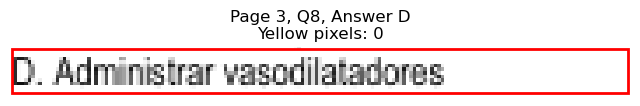


Page 3, Q8 - Selected Answer: A (based on yellow pixel count)
Page 3, Q9 - A: Detected box: x0=56.6, y0=606.9, x1=114.5, y1=619.5
Page 3, Q9, A: Yellow pixels: 0
Page 3, Q9, A: Total non-white pixels: 262
Page 3, Q9, A: Yellow percentage: 0.0%


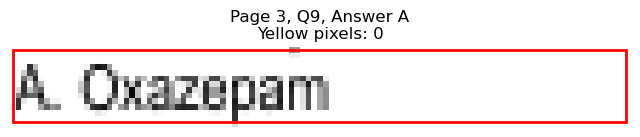

Page 3, Q9 - B: Detected box: x0=56.6, y0=619.6, x1=109.0, y1=632.3
Page 3, Q9, B: Yellow pixels: 0
Page 3, Q9, B: Total non-white pixels: 247
Page 3, Q9, B: Yellow percentage: 0.0%


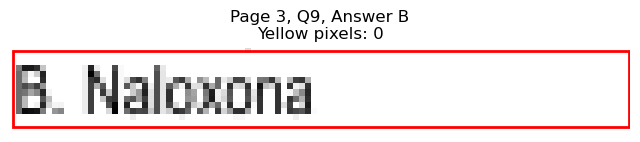

Page 3, Q9 - C: Detected box: x0=315.4, y0=606.9, x1=374.7, y1=619.5
Page 3, Q9, C: Yellow pixels: 0
Page 3, Q9, C: Total non-white pixels: 269
Page 3, Q9, C: Yellow percentage: 0.0%


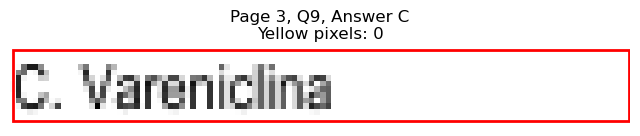

Page 3, Q9 - D: Detected box: x0=315.4, y0=619.6, x1=370.1, y1=632.3
Page 3, Q9, D: Yellow pixels: 1070
Page 3, Q9, D: Total non-white pixels: 1484
Page 3, Q9, D: Yellow percentage: 72.1%


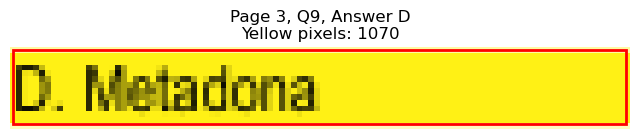


Page 3, Q9 - Selected Answer: D (based on yellow pixel count)
Page 3, Q10 - A: Detected box: x0=56.6, y0=670.0, x1=178.2, y1=682.7
Page 3, Q10, A: Yellow pixels: 0
Page 3, Q10, A: Total non-white pixels: 582
Page 3, Q10, A: Yellow percentage: 0.0%


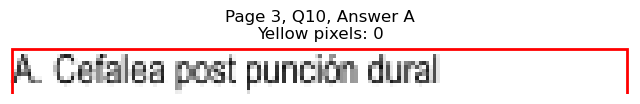

Page 3, Q10 - B: Detected box: x0=56.6, y0=682.6, x1=245.8, y1=695.3
Page 3, Q10, B: Yellow pixels: 0
Page 3, Q10, B: Total non-white pixels: 946
Page 3, Q10, B: Yellow percentage: 0.0%


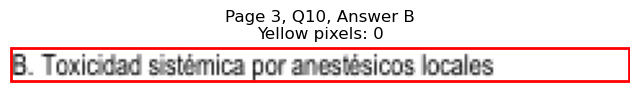

Page 3, Q10 - C: Detected box: x0=315.4, y0=670.0, x1=422.9, y1=682.7
Page 3, Q10, C: Yellow pixels: 1670
Page 3, Q10, C: Total non-white pixels: 2054
Page 3, Q10, C: Yellow percentage: 81.3%


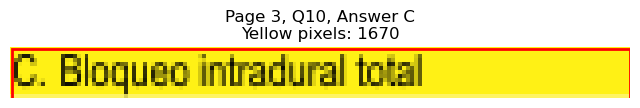

Page 3, Q10 - D: Detected box: x0=315.4, y0=682.6, x1=405.8, y1=695.3
Page 3, Q10, D: Yellow pixels: 141
Page 3, Q10, D: Total non-white pixels: 578
Page 3, Q10, D: Yellow percentage: 24.4%


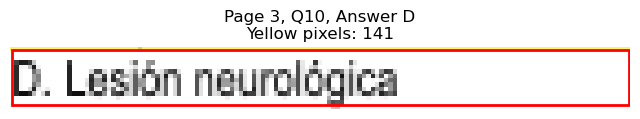


Page 3, Q10 - Selected Answer: C (based on yellow pixel count)
Page 3, Q11 - A: Detected box: x0=56.6, y0=733.2, x1=123.5, y1=745.8
Page 3, Q11, A: Yellow pixels: 1
Page 3, Q11, A: Total non-white pixels: 450
Page 3, Q11, A: Yellow percentage: 0.2%


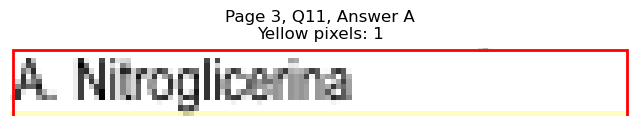

Page 3, Q11 - B: Detected box: x0=56.6, y0=745.8, x1=150.5, y1=758.4
Page 3, Q11, B: Yellow pixels: 1533
Page 3, Q11, B: Total non-white pixels: 2030
Page 3, Q11, B: Yellow percentage: 75.5%


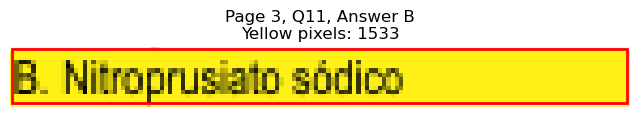

Page 3, Q11 - C: Detected box: x0=315.4, y0=733.2, x1=435.4, y1=745.8
Page 3, Q11, C: Yellow pixels: 0
Page 3, Q11, C: Total non-white pixels: 609
Page 3, Q11, C: Yellow percentage: 0.0%


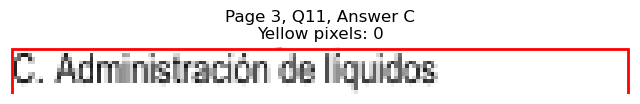

Page 3, Q11 - D: Detected box: x0=315.4, y0=745.8, x1=417.4, y1=758.4
Page 3, Q11, D: Yellow pixels: 0
Page 3, Q11, D: Total non-white pixels: 504
Page 3, Q11, D: Yellow percentage: 0.0%


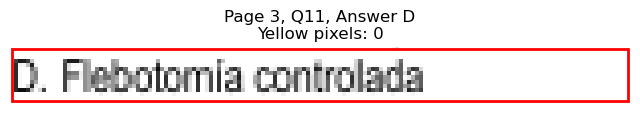


Page 3, Q11 - Selected Answer: B (based on yellow pixel count)

Page 4: Found 11 questions
Page 4, Q1 - A: Detected box: x0=56.6, y0=102.0, x1=126.0, y1=114.7
Page 4, Q1, A: Yellow pixels: 0
Page 4, Q1, A: Total non-white pixels: 326
Page 4, Q1, A: Yellow percentage: 0.0%


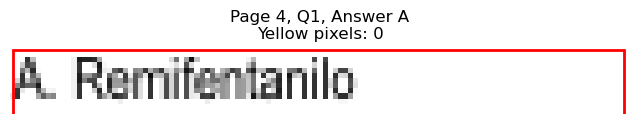

Page 4, Q1 - B: Detected box: x0=56.6, y0=114.6, x1=107.9, y1=127.3
Page 4, Q1, B: Yellow pixels: 0
Page 4, Q1, B: Total non-white pixels: 220
Page 4, Q1, B: Yellow percentage: 0.0%


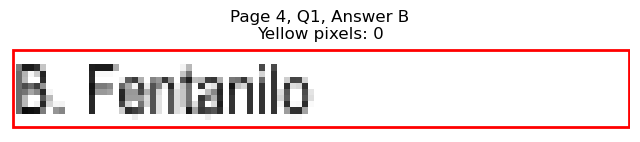

Page 4, Q1 - C: Detected box: x0=315.4, y0=102.0, x1=363.8, y1=114.7
Page 4, Q1, C: Yellow pixels: 1123
Page 4, Q1, C: Total non-white pixels: 1287
Page 4, Q1, C: Yellow percentage: 87.3%


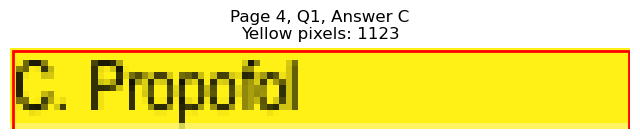

Page 4, Q1 - D: Detected box: x0=315.4, y0=114.6, x1=378.2, y1=127.3
Page 4, Q1, D: Yellow pixels: 114
Page 4, Q1, D: Total non-white pixels: 409
Page 4, Q1, D: Yellow percentage: 27.9%


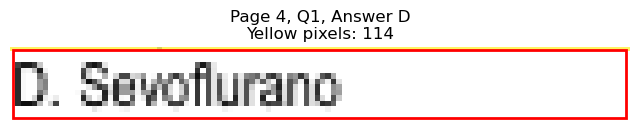


Page 4, Q1 - Selected Answer: C (based on yellow pixel count)
Page 4, Q2 - A: Detected box: x0=56.6, y0=165.1, x1=78.4, y1=177.8
Page 4, Q2, A: Yellow pixels: 0
Page 4, Q2, A: Total non-white pixels: 144
Page 4, Q2, A: Yellow percentage: 0.0%


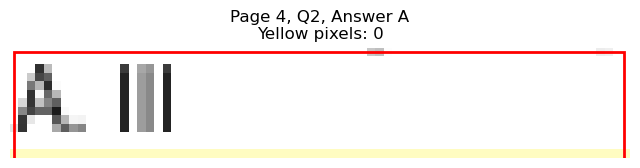

Page 4, Q2 - B: Detected box: x0=56.6, y0=177.7, x1=79.3, y1=190.4
Page 4, Q2, B: Yellow pixels: 820
Page 4, Q2, B: Total non-white pixels: 1036
Page 4, Q2, B: Yellow percentage: 79.2%


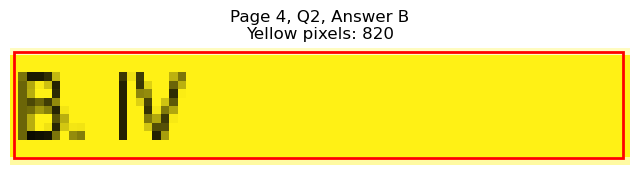

Page 4, Q2 - C: Detected box: x0=315.4, y0=165.1, x1=336.1, y1=177.8
Page 4, Q2, C: Yellow pixels: 0
Page 4, Q2, C: Total non-white pixels: 70
Page 4, Q2, C: Yellow percentage: 0.0%


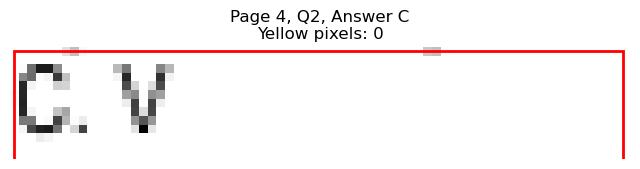

Page 4, Q2 - D: Detected box: x0=315.4, y0=177.7, x1=335.1, y1=190.4
Page 4, Q2, D: Yellow pixels: 0
Page 4, Q2, D: Total non-white pixels: 72
Page 4, Q2, D: Yellow percentage: 0.0%


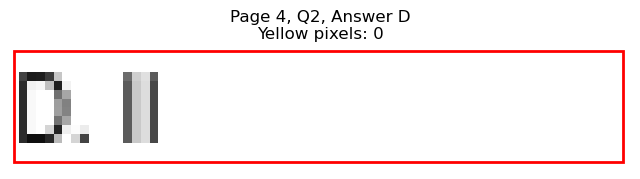


Page 4, Q2 - Selected Answer: B (based on yellow pixel count)
Page 4, Q3 - A: Detected box: x0=56.6, y0=215.6, x1=121.0, y1=228.3
Page 4, Q3, A: Yellow pixels: 0
Page 4, Q3, A: Total non-white pixels: 290
Page 4, Q3, A: Yellow percentage: 0.0%


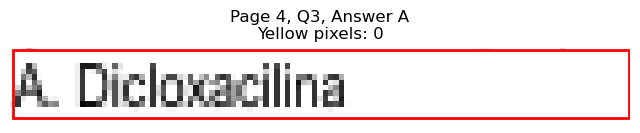

Page 4, Q3 - B: Detected box: x0=56.6, y0=228.2, x1=109.0, y1=240.9
Page 4, Q3, B: Yellow pixels: 0
Page 4, Q3, B: Total non-white pixels: 231
Page 4, Q3, B: Yellow percentage: 0.0%


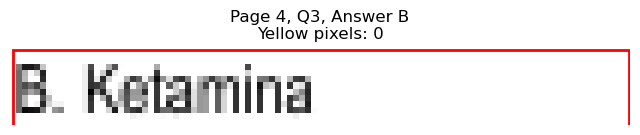

Page 4, Q3 - C: Detected box: x0=315.4, y0=215.6, x1=375.7, y1=228.3
Page 4, Q3, C: Yellow pixels: 1080
Page 4, Q3, C: Total non-white pixels: 1554
Page 4, Q3, C: Yellow percentage: 69.5%


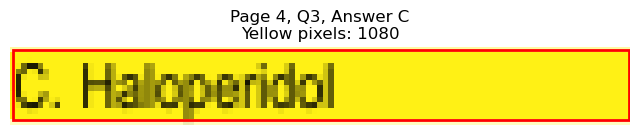

Page 4, Q3 - D: Detected box: x0=315.4, y0=228.2, x1=380.2, y1=240.9
Page 4, Q3, D: Yellow pixels: 0
Page 4, Q3, D: Total non-white pixels: 447
Page 4, Q3, D: Yellow percentage: 0.0%


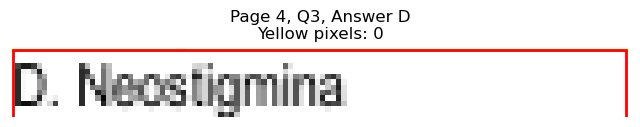


Page 4, Q3 - Selected Answer: C (based on yellow pixel count)
Page 4, Q4 - A: Detected box: x0=56.6, y0=266.0, x1=123.0, y1=278.7
Page 4, Q4, A: Yellow pixels: 0
Page 4, Q4, A: Total non-white pixels: 301
Page 4, Q4, A: Yellow percentage: 0.0%


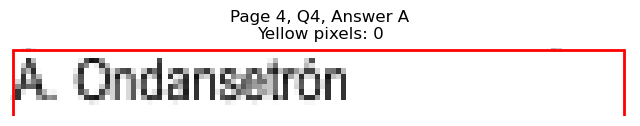

Page 4, Q4 - B: Detected box: x0=56.6, y0=278.8, x1=131.5, y1=291.4
Page 4, Q4, B: Yellow pixels: 0
Page 4, Q4, B: Total non-white pixels: 366
Page 4, Q4, B: Yellow percentage: 0.0%


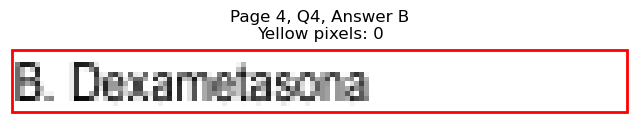

Page 4, Q4 - C: Detected box: x0=315.4, y0=266.0, x1=386.7, y1=278.7
Page 4, Q4, C: Yellow pixels: 1334
Page 4, Q4, C: Total non-white pixels: 1586
Page 4, Q4, C: Yellow percentage: 84.1%


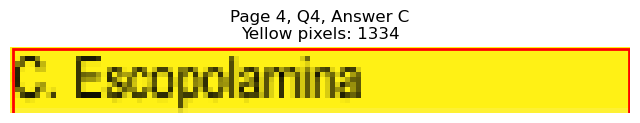

Page 4, Q4 - D: Detected box: x0=315.4, y0=278.8, x1=394.3, y1=291.4
Page 4, Q4, D: Yellow pixels: 130
Page 4, Q4, D: Total non-white pixels: 536
Page 4, Q4, D: Yellow percentage: 24.3%


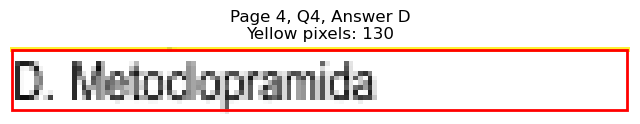


Page 4, Q4 - Selected Answer: C (based on yellow pixel count)
Page 4, Q5 - A: Detected box: x0=56.6, y0=316.6, x1=112.9, y1=329.2
Page 4, Q5, A: Yellow pixels: 0
Page 4, Q5, A: Total non-white pixels: 252
Page 4, Q5, A: Yellow percentage: 0.0%


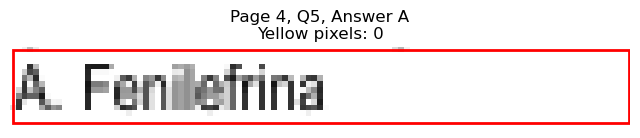

Page 4, Q5 - B: Detected box: x0=56.6, y0=329.2, x1=127.5, y1=341.8
Page 4, Q5, B: Yellow pixels: 0
Page 4, Q5, B: Total non-white pixels: 362
Page 4, Q5, B: Yellow percentage: 0.0%


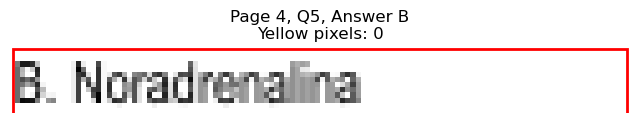

Page 4, Q5 - C: Detected box: x0=315.4, y0=316.6, x1=380.2, y1=329.2
Page 4, Q5, C: Yellow pixels: 116
Page 4, Q5, C: Total non-white pixels: 434
Page 4, Q5, C: Yellow percentage: 26.7%


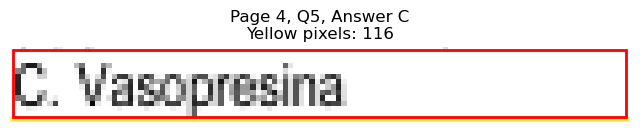

Page 4, Q5 - D: Detected box: x0=315.4, y0=329.2, x1=378.7, y1=341.8
Page 4, Q5, D: Yellow pixels: 1239
Page 4, Q5, D: Total non-white pixels: 1482
Page 4, Q5, D: Yellow percentage: 83.6%


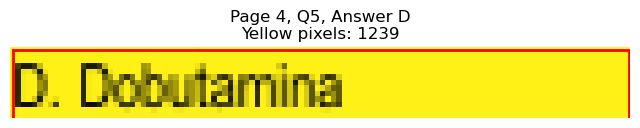


Page 4, Q5 - Selected Answer: D (based on yellow pixel count)
Page 4, Q6 - A: Detected box: x0=56.6, y0=392.3, x1=238.4, y1=405.0
Page 4, Q6, A: Yellow pixels: 0
Page 4, Q6, A: Total non-white pixels: 1138
Page 4, Q6, A: Yellow percentage: 0.0%


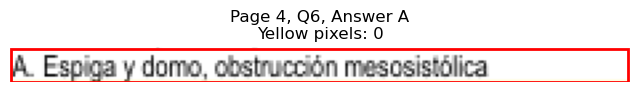

Page 4, Q6 - B: Detected box: x0=56.6, y0=404.9, x1=279.0, y1=417.6
Page 4, Q6, B: Yellow pixels: 2718
Page 4, Q6, B: Total non-white pixels: 3836
Page 4, Q6, B: Yellow percentage: 70.9%


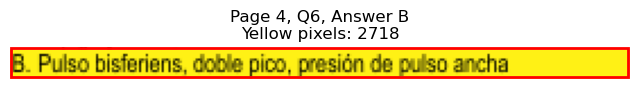

Page 4, Q6 - C: Detected box: x0=56.6, y0=417.6, x1=299.6, y1=430.3
Page 4, Q6, C: Yellow pixels: 294
Page 4, Q6, C: Total non-white pixels: 1463
Page 4, Q6, C: Yellow percentage: 20.1%


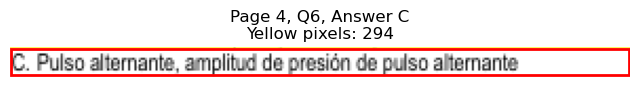

Page 4, Q6 - D: Detected box: x0=56.6, y0=430.2, x1=231.8, y1=442.9
Page 4, Q6, D: Yellow pixels: 0
Page 4, Q6, D: Total non-white pixels: 822
Page 4, Q6, D: Yellow percentage: 0.0%


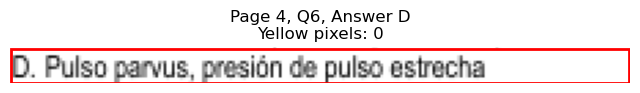


Page 4, Q6 - Selected Answer: B (based on yellow pixel count)
Page 4, Q7 - A: Detected box: x0=56.6, y0=468.1, x1=203.8, y1=480.7
Page 4, Q7, A: Yellow pixels: 0
Page 4, Q7, A: Total non-white pixels: 717
Page 4, Q7, A: Yellow percentage: 0.0%


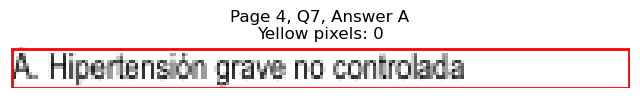

Page 4, Q7 - B: Detected box: x0=56.6, y0=480.8, x1=166.6, y1=493.4
Page 4, Q7, B: Yellow pixels: 0
Page 4, Q7, B: Total non-white pixels: 513
Page 4, Q7, B: Yellow percentage: 0.0%


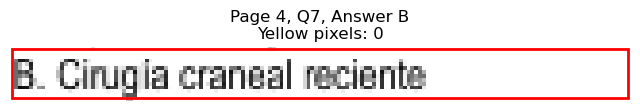

Page 4, Q7 - C: Detected box: x0=315.4, y0=468.1, x1=403.4, y1=480.7
Page 4, Q7, C: Yellow pixels: 0
Page 4, Q7, C: Total non-white pixels: 423
Page 4, Q7, C: Yellow percentage: 0.0%


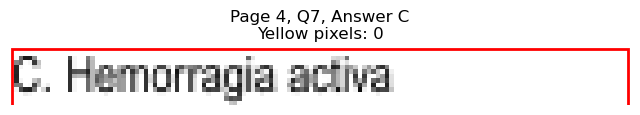

Page 4, Q7 - D: Detected box: x0=315.4, y0=480.8, x1=371.2, y1=493.4
Page 4, Q7, D: Yellow pixels: 1080
Page 4, Q7, D: Total non-white pixels: 1498
Page 4, Q7, D: Yellow percentage: 72.1%


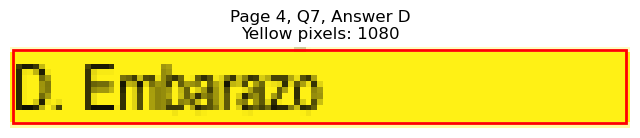


Page 4, Q7 - Selected Answer: D (based on yellow pixel count)
Page 4, Q8 - A: Detected box: x0=56.6, y0=531.2, x1=142.6, y1=543.8
Page 4, Q8, A: Yellow pixels: 1425
Page 4, Q8, A: Total non-white pixels: 1781
Page 4, Q8, A: Yellow percentage: 80.0%


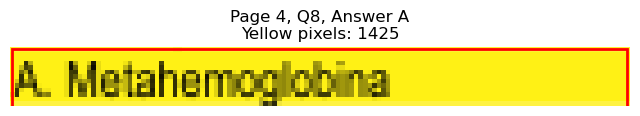

Page 4, Q8 - B: Detected box: x0=56.6, y0=543.8, x1=117.4, y1=556.4
Page 4, Q8, B: Yellow pixels: 108
Page 4, Q8, B: Total non-white pixels: 420
Page 4, Q8, B: Yellow percentage: 25.7%


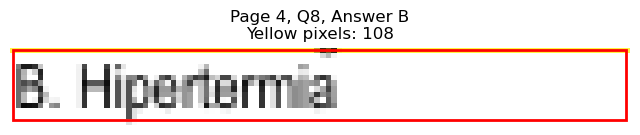

Page 4, Q8 - C: Detected box: x0=315.4, y0=531.2, x1=363.7, y1=543.8
Page 4, Q8, C: Yellow pixels: 0
Page 4, Q8, C: Total non-white pixels: 221
Page 4, Q8, C: Yellow percentage: 0.0%


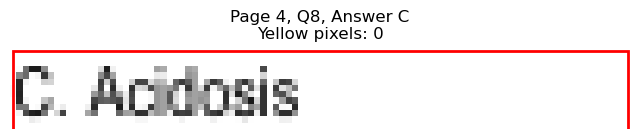

Page 4, Q8 - D: Detected box: x0=315.4, y0=543.8, x1=414.8, y1=556.4
Page 4, Q8, D: Yellow pixels: 0
Page 4, Q8, D: Total non-white pixels: 459
Page 4, Q8, D: Yellow percentage: 0.0%


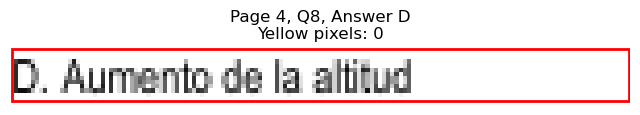


Page 4, Q8 - Selected Answer: A (based on yellow pixel count)
Page 4, Q9 - A: Detected box: x0=56.6, y0=594.3, x1=272.9, y1=606.9
Page 4, Q9, A: Yellow pixels: 2082
Page 4, Q9, A: Total non-white pixels: 2972
Page 4, Q9, A: Yellow percentage: 70.1%


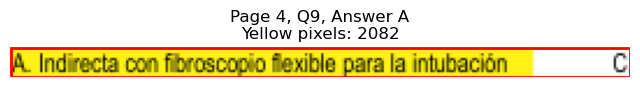

Page 4, Q9 - B: Detected box: x0=56.6, y0=606.9, x1=213.9, y1=619.5
Page 4, Q9, B: Yellow pixels: 204
Page 4, Q9, B: Total non-white pixels: 948
Page 4, Q9, B: Yellow percentage: 21.5%


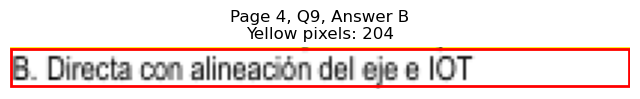

Page 4, Q9 - C: Detected box: x0=315.4, y0=594.3, x1=419.8, y1=606.9
Page 4, Q9, C: Yellow pixels: 0
Page 4, Q9, C: Total non-white pixels: 481
Page 4, Q9, C: Yellow percentage: 0.0%


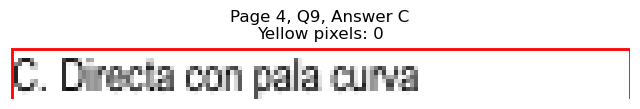

Page 4, Q9 - D: Detected box: x0=315.4, y0=606.9, x1=485.0, y1=619.5
Page 4, Q9, D: Yellow pixels: 0
Page 4, Q9, D: Total non-white pixels: 806
Page 4, Q9, D: Yellow percentage: 0.0%


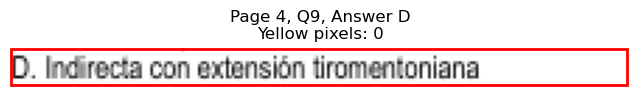


Page 4, Q9 - Selected Answer: A (based on yellow pixel count)
Page 4, Q10 - A: Detected box: x0=56.6, y0=644.8, x1=75.9, y1=657.5
Page 4, Q10, A: Yellow pixels: 0
Page 4, Q10, A: Total non-white pixels: 62
Page 4, Q10, A: Yellow percentage: 0.0%


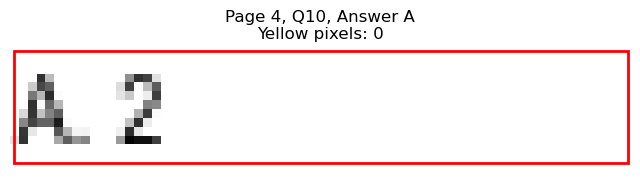

Page 4, Q10 - B: Detected box: x0=56.6, y0=657.4, x1=75.9, y1=670.1
Page 4, Q10, B: Yellow pixels: 0
Page 4, Q10, B: Total non-white pixels: 60
Page 4, Q10, B: Yellow percentage: 0.0%


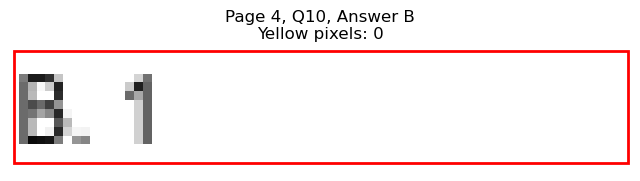

Page 4, Q10 - C: Detected box: x0=315.4, y0=644.8, x1=335.1, y1=657.5
Page 4, Q10, C: Yellow pixels: 878
Page 4, Q10, C: Total non-white pixels: 994
Page 4, Q10, C: Yellow percentage: 88.3%


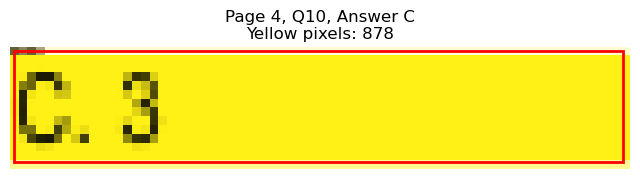

Page 4, Q10 - D: Detected box: x0=315.4, y0=657.4, x1=335.1, y1=670.1
Page 4, Q10, D: Yellow pixels: 71
Page 4, Q10, D: Total non-white pixels: 140
Page 4, Q10, D: Yellow percentage: 50.7%


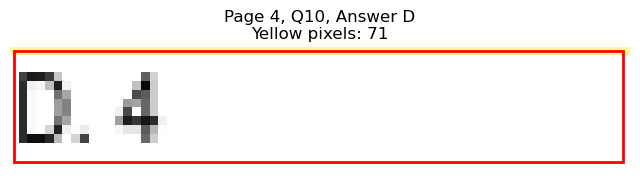


Page 4, Q10 - Selected Answer: C (based on yellow pixel count)
Page 4, Q11 - A: Detected box: x0=56.6, y0=695.4, x1=188.2, y1=708.0
Page 4, Q11, A: Yellow pixels: 0
Page 4, Q11, A: Total non-white pixels: 664
Page 4, Q11, A: Yellow percentage: 0.0%


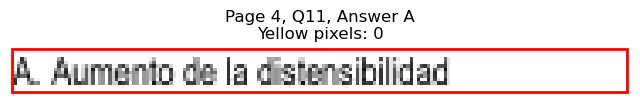

Page 4, Q11 - B: Detected box: x0=56.6, y0=708.0, x1=115.9, y1=720.6
Page 4, Q11, B: Yellow pixels: 0
Page 4, Q11, B: Total non-white pixels: 275
Page 4, Q11, B: Yellow percentage: 0.0%


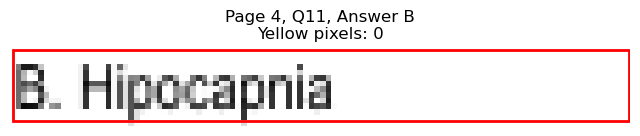

Page 4, Q11 - C: Detected box: x0=315.4, y0=695.4, x1=480.1, y1=708.0
Page 4, Q11, C: Yellow pixels: 216
Page 4, Q11, C: Total non-white pixels: 1215
Page 4, Q11, C: Yellow percentage: 17.8%


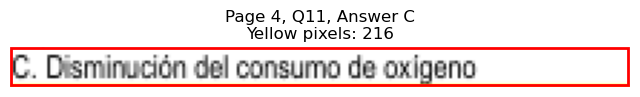

Page 4, Q11 - D: Detected box: x0=315.4, y0=708.0, x1=409.3, y1=720.6
Page 4, Q11, D: Yellow pixels: 1575
Page 4, Q11, D: Total non-white pixels: 2030
Page 4, Q11, D: Yellow percentage: 77.6%


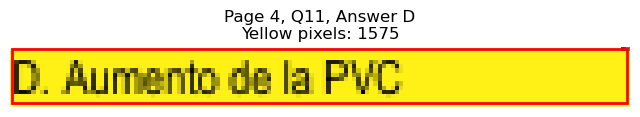


Page 4, Q11 - Selected Answer: D (based on yellow pixel count)

Page 5: Found 12 questions
Page 5, Q1 - A: Detected box: x0=56.6, y0=102.0, x1=109.9, y1=114.7
Page 5, Q1, A: Yellow pixels: 0
Page 5, Q1, A: Total non-white pixels: 239
Page 5, Q1, A: Yellow percentage: 0.0%


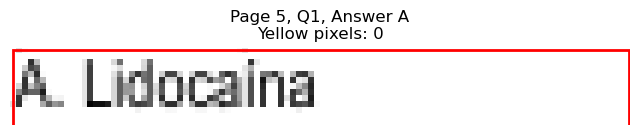

Page 5, Q1 - B: Detected box: x0=56.6, y0=114.6, x1=120.5, y1=127.3
Page 5, Q1, B: Yellow pixels: 0
Page 5, Q1, B: Total non-white pixels: 321
Page 5, Q1, B: Yellow percentage: 0.0%


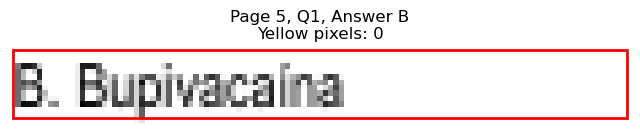

Page 5, Q1 - C: Detected box: x0=315.4, y0=102.0, x1=380.2, y1=114.7
Page 5, Q1, C: Yellow pixels: 0
Page 5, Q1, C: Total non-white pixels: 420
Page 5, Q1, C: Yellow percentage: 0.0%


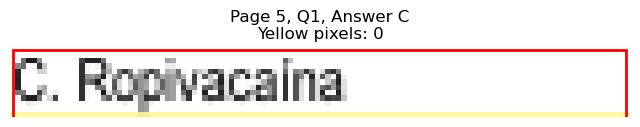

Page 5, Q1 - D: Detected box: x0=315.4, y0=114.6, x1=373.1, y1=127.3
Page 5, Q1, D: Yellow pixels: 1115
Page 5, Q1, D: Total non-white pixels: 1526
Page 5, Q1, D: Yellow percentage: 73.1%


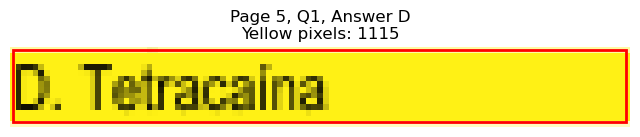


Page 5, Q1 - Selected Answer: D (based on yellow pixel count)
Page 5, Q2 - A: Detected box: x0=56.6, y0=165.1, x1=215.8, y1=177.8
Page 5, Q2, A: Yellow pixels: 0
Page 5, Q2, A: Total non-white pixels: 740
Page 5, Q2, A: Yellow percentage: 0.0%


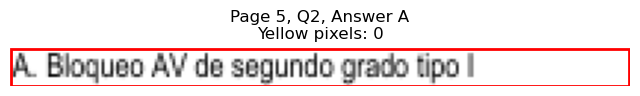

Page 5, Q2 - B: Detected box: x0=56.6, y0=177.7, x1=134.5, y1=190.4
Page 5, Q2, B: Yellow pixels: 0
Page 5, Q2, B: Total non-white pixels: 378
Page 5, Q2, B: Yellow percentage: 0.0%


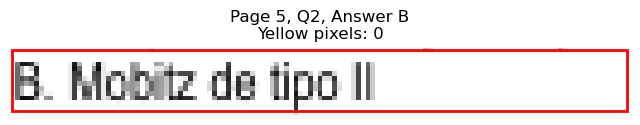

Page 5, Q2 - C: Detected box: x0=315.4, y0=165.1, x1=441.4, y1=177.8
Page 5, Q2, C: Yellow pixels: 1863
Page 5, Q2, C: Total non-white pixels: 2301
Page 5, Q2, C: Yellow percentage: 81.0%


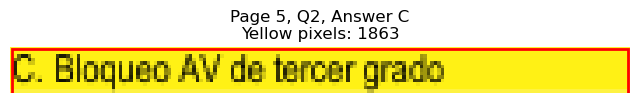

Page 5, Q2 - D: Detected box: x0=315.4, y0=177.7, x1=443.9, y1=190.4
Page 5, Q2, D: Yellow pixels: 177
Page 5, Q2, D: Total non-white pixels: 772
Page 5, Q2, D: Yellow percentage: 22.9%


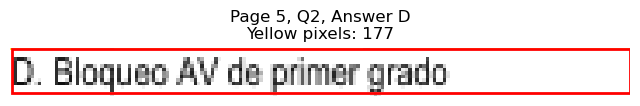


Page 5, Q2 - Selected Answer: C (based on yellow pixel count)
Page 5, Q3 - A: Detected box: x0=56.6, y0=215.6, x1=122.5, y1=228.3
Page 5, Q3, A: Yellow pixels: 1164
Page 5, Q3, A: Total non-white pixels: 1638
Page 5, Q3, A: Yellow percentage: 71.1%


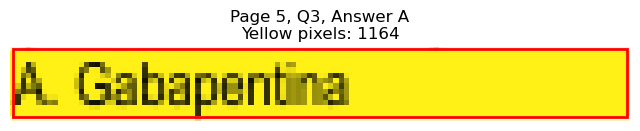

Page 5, Q3 - B: Detected box: x0=56.6, y0=569.1, x1=109.0, y1=581.7
Page 5, Q3, B: Yellow pixels: 1149
Page 5, Q3, B: Total non-white pixels: 1339
Page 5, Q3, B: Yellow percentage: 85.8%


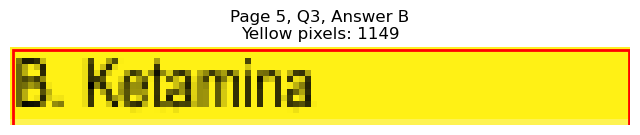

Page 5, Q3 - C: Detected box: x0=315.4, y0=215.6, x1=380.7, y1=228.3
Page 5, Q3, C: Yellow pixels: 0
Page 5, Q3, C: Total non-white pixels: 298
Page 5, Q3, C: Yellow percentage: 0.0%


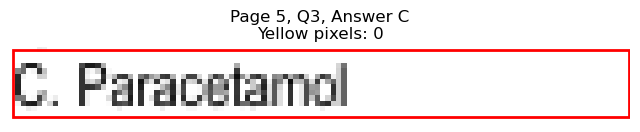

Page 5, Q3 - D: Detected box: x0=315.4, y0=228.2, x1=369.7, y1=240.9
Page 5, Q3, D: Yellow pixels: 0
Page 5, Q3, D: Total non-white pixels: 259
Page 5, Q3, D: Yellow percentage: 0.0%


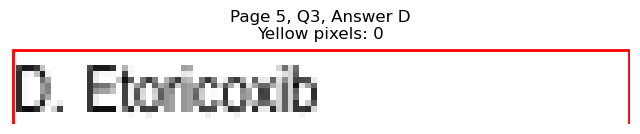


Page 5, Q3 - Selected Answer: A (based on yellow pixel count)
Page 5, Q4 - A: Detected box: x0=56.6, y0=266.0, x1=191.2, y1=278.7
Page 5, Q4, A: Yellow pixels: 0
Page 5, Q4, A: Total non-white pixels: 699
Page 5, Q4, A: Yellow percentage: 0.0%


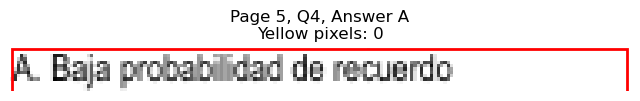

Page 5, Q4 - B: Detected box: x0=56.6, y0=278.8, x1=143.5, y1=291.4
Page 5, Q4, B: Yellow pixels: 0
Page 5, Q4, B: Total non-white pixels: 436
Page 5, Q4, B: Yellow percentage: 0.0%


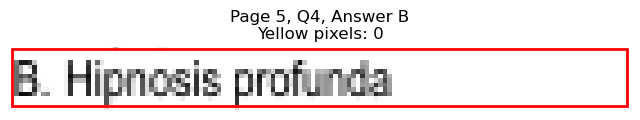

Page 5, Q4 - C: Detected box: x0=315.4, y0=266.0, x1=368.7, y1=278.7
Page 5, Q4, C: Yellow pixels: 0
Page 5, Q4, C: Total non-white pixels: 256
Page 5, Q4, C: Yellow percentage: 0.0%


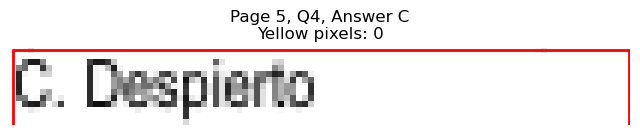

Page 5, Q4 - D: Detected box: x0=315.4, y0=278.8, x1=392.2, y1=291.4
Page 5, Q4, D: Yellow pixels: 1386
Page 5, Q4, D: Total non-white pixels: 1792
Page 5, Q4, D: Yellow percentage: 77.3%


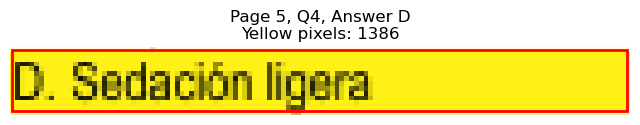


Page 5, Q4 - Selected Answer: D (based on yellow pixel count)
Page 5, Q5 - A: Detected box: x0=56.6, y0=316.6, x1=106.9, y1=329.2
Page 5, Q5, A: Yellow pixels: 0
Page 5, Q5, A: Total non-white pixels: 210
Page 5, Q5, A: Yellow percentage: 0.0%


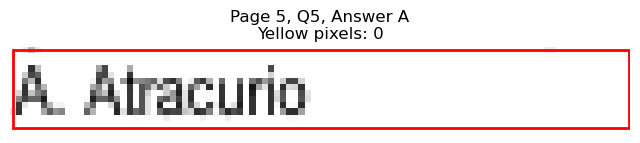

Page 5, Q5 - B: Detected box: x0=56.6, y0=329.2, x1=112.0, y1=341.8
Page 5, Q5, B: Yellow pixels: 0
Page 5, Q5, B: Total non-white pixels: 233
Page 5, Q5, B: Yellow percentage: 0.0%


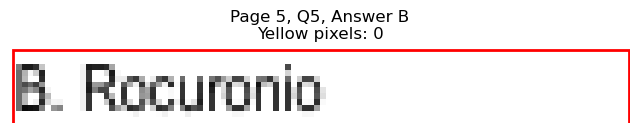

Page 5, Q5 - C: Detected box: x0=315.4, y0=316.6, x1=370.7, y1=329.2
Page 5, Q5, C: Yellow pixels: 106
Page 5, Q5, C: Total non-white pixels: 356
Page 5, Q5, C: Yellow percentage: 29.8%


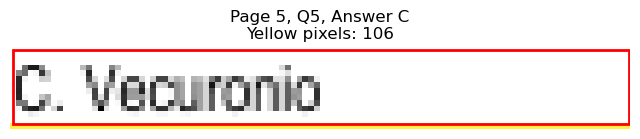

Page 5, Q5 - D: Detected box: x0=315.4, y0=329.2, x1=384.7, y1=341.8
Page 5, Q5, D: Yellow pixels: 1316
Page 5, Q5, D: Total non-white pixels: 1560
Page 5, Q5, D: Yellow percentage: 84.4%


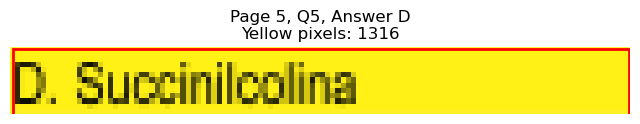


Page 5, Q5 - Selected Answer: D (based on yellow pixel count)
Page 5, Q6 - A: Detected box: x0=56.6, y0=379.7, x1=145.0, y1=392.4
Page 5, Q6, A: Yellow pixels: 139
Page 5, Q6, A: Total non-white pixels: 585
Page 5, Q6, A: Yellow percentage: 23.8%


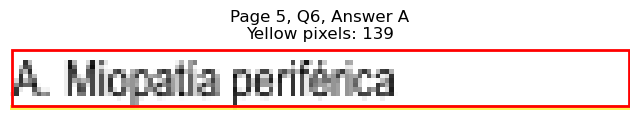

Page 5, Q6 - B: Detected box: x0=56.6, y0=392.3, x1=163.2, y1=405.0
Page 5, Q6, B: Yellow pixels: 1661
Page 5, Q6, B: Total non-white pixels: 2054
Page 5, Q6, B: Yellow percentage: 80.9%


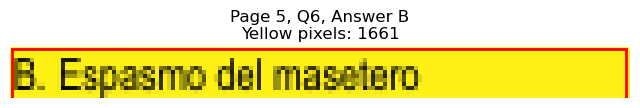

Page 5, Q6 - C: Detected box: x0=315.4, y0=379.7, x1=373.1, y1=392.4
Page 5, Q6, C: Yellow pixels: 0
Page 5, Q6, C: Total non-white pixels: 266
Page 5, Q6, C: Yellow percentage: 0.0%


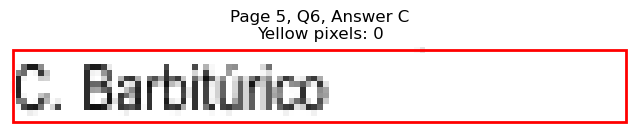

Page 5, Q6 - D: Detected box: x0=315.4, y0=392.3, x1=384.7, y1=405.0
Page 5, Q6, D: Yellow pixels: 0
Page 5, Q6, D: Total non-white pixels: 329
Page 5, Q6, D: Yellow percentage: 0.0%


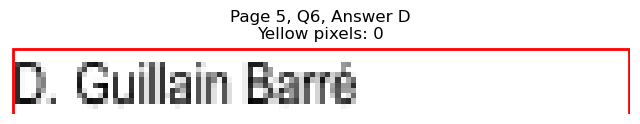


Page 5, Q6 - Selected Answer: B (based on yellow pixel count)
Page 5, Q7 - A: Detected box: x0=56.6, y0=455.5, x1=162.1, y1=468.1
Page 5, Q7, A: Yellow pixels: 0
Page 5, Q7, A: Total non-white pixels: 457
Page 5, Q7, A: Yellow percentage: 0.0%


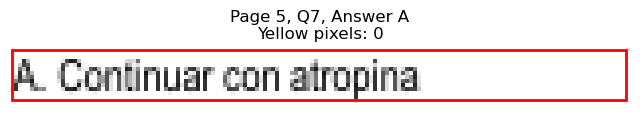

Page 5, Q7 - B: Detected box: x0=56.6, y0=468.1, x1=175.6, y1=480.7
Page 5, Q7, B: Yellow pixels: 0
Page 5, Q7, B: Total non-white pixels: 583
Page 5, Q7, B: Yellow percentage: 0.0%


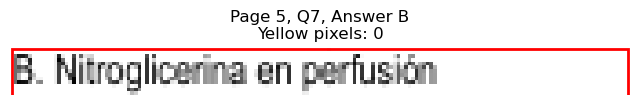

Page 5, Q7 - C: Detected box: x0=315.4, y0=455.5, x1=423.3, y1=468.1
Page 5, Q7, C: Yellow pixels: 1668
Page 5, Q7, C: Total non-white pixels: 2226
Page 5, Q7, C: Yellow percentage: 74.9%


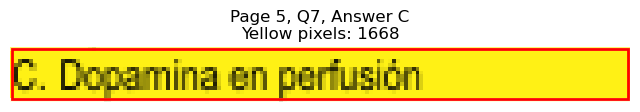

Page 5, Q7 - D: Detected box: x0=337.8, y0=468.1, x1=375.4, y1=480.7
Page 5, Q7, D: Yellow pixels: 0
Page 5, Q7, D: Total non-white pixels: 269
Page 5, Q7, D: Yellow percentage: 0.0%


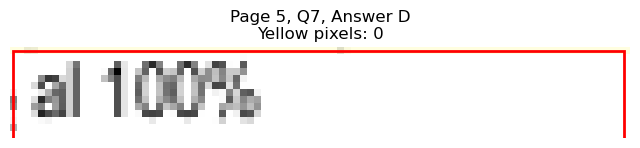


Page 5, Q7 - Selected Answer: C (based on yellow pixel count)
Page 5, Q8 - A: Detected box: x0=56.6, y0=506.0, x1=109.9, y1=518.6
Page 5, Q8, A: Yellow pixels: 0
Page 5, Q8, A: Total non-white pixels: 251
Page 5, Q8, A: Yellow percentage: 0.0%


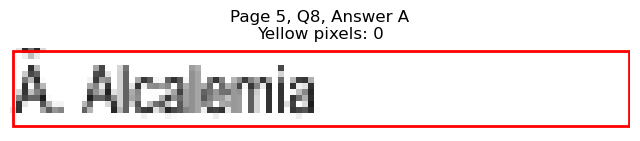

Page 5, Q8 - B: Detected box: x0=56.6, y0=518.6, x1=115.9, y1=531.2
Page 5, Q8, B: Yellow pixels: 0
Page 5, Q8, B: Total non-white pixels: 275
Page 5, Q8, B: Yellow percentage: 0.0%


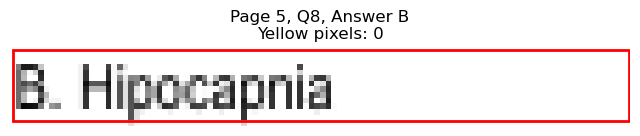

Page 5, Q8 - C: Detected box: x0=315.4, y0=506.0, x1=407.8, y1=518.6
Page 5, Q8, C: Yellow pixels: 143
Page 5, Q8, C: Total non-white pixels: 587
Page 5, Q8, C: Yellow percentage: 24.4%


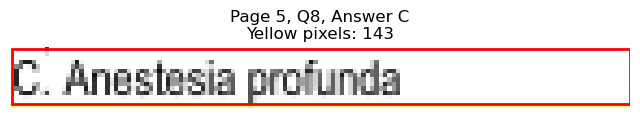

Page 5, Q8 - D: Detected box: x0=315.4, y0=518.6, x1=351.7, y1=531.2
Page 5, Q8, D: Yellow pixels: 1005
Page 5, Q8, D: Total non-white pixels: 1218
Page 5, Q8, D: Yellow percentage: 82.5%


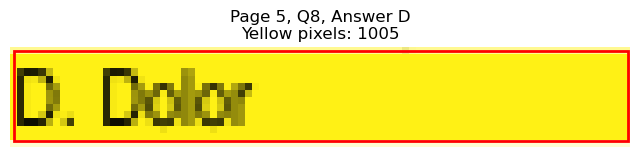


Page 5, Q8 - Selected Answer: D (based on yellow pixel count)
Page 5, Q9 - A: Detected box: x0=56.6, y0=556.5, x1=104.4, y1=569.1
Page 5, Q9, A: Yellow pixels: 99
Page 5, Q9, A: Total non-white pixels: 328
Page 5, Q9, A: Yellow percentage: 30.2%


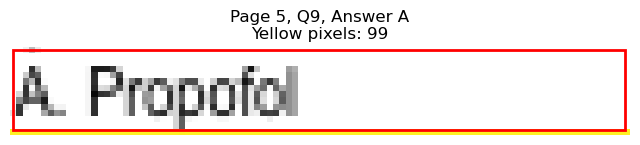

Page 5, Q9 - B: Detected box: x0=56.6, y0=569.1, x1=109.0, y1=581.7
Page 5, Q9, B: Yellow pixels: 1149
Page 5, Q9, B: Total non-white pixels: 1339
Page 5, Q9, B: Yellow percentage: 85.8%


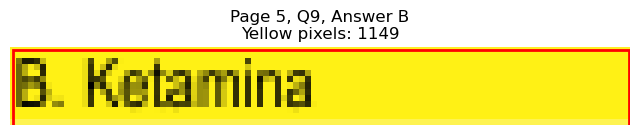

Page 5, Q9 - C: Detected box: x0=315.4, y0=556.5, x1=398.9, y1=569.1
Page 5, Q9, C: Yellow pixels: 0
Page 5, Q9, C: Total non-white pixels: 418
Page 5, Q9, C: Yellow percentage: 0.0%


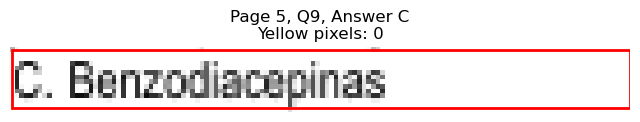

Page 5, Q9 - D: Detected box: x0=315.4, y0=569.1, x1=377.7, y1=581.7
Page 5, Q9, D: Yellow pixels: 0
Page 5, Q9, D: Total non-white pixels: 293
Page 5, Q9, D: Yellow percentage: 0.0%


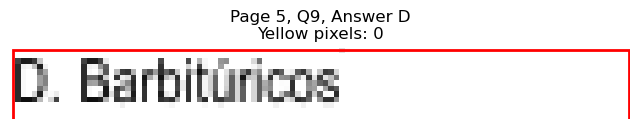


Page 5, Q9 - Selected Answer: B (based on yellow pixel count)
Page 5, Q10 - A: Detected box: x0=56.6, y0=619.6, x1=90.4, y1=632.3
Page 5, Q10, A: Yellow pixels: 910
Page 5, Q10, A: Total non-white pixels: 1190
Page 5, Q10, A: Yellow percentage: 76.5%


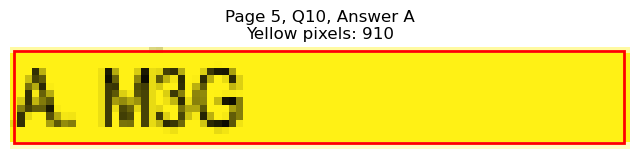

Page 5, Q10 - B: Detected box: x0=56.6, y0=632.2, x1=90.4, y1=644.9
Page 5, Q10, B: Yellow pixels: 0
Page 5, Q10, B: Total non-white pixels: 255
Page 5, Q10, B: Yellow percentage: 0.0%


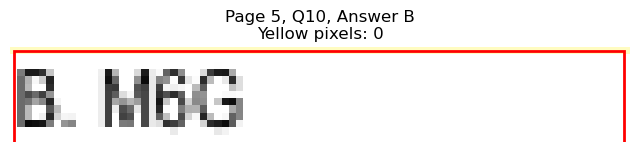

Page 5, Q10 - C: Detected box: x0=315.4, y0=619.6, x1=349.6, y1=632.3
Page 5, Q10, C: Yellow pixels: 0
Page 5, Q10, C: Total non-white pixels: 159
Page 5, Q10, C: Yellow percentage: 0.0%


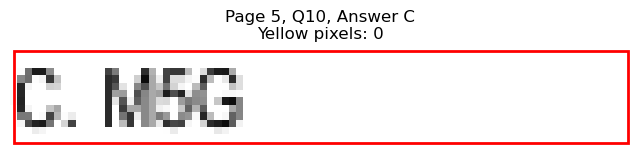

Page 5, Q10 - D: Detected box: x0=315.4, y0=632.2, x1=349.6, y1=644.9
Page 5, Q10, D: Yellow pixels: 0
Page 5, Q10, D: Total non-white pixels: 152
Page 5, Q10, D: Yellow percentage: 0.0%


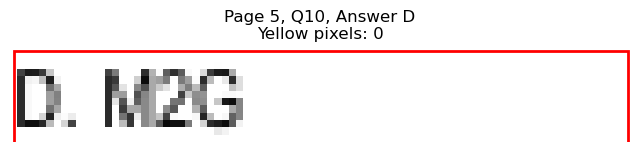


Page 5, Q10 - Selected Answer: A (based on yellow pixel count)
Page 5, Q11 - A: Detected box: x0=56.6, y0=670.0, x1=189.6, y1=682.7
Page 5, Q11, A: Yellow pixels: 0
Page 5, Q11, A: Total non-white pixels: 634
Page 5, Q11, A: Yellow percentage: 0.0%


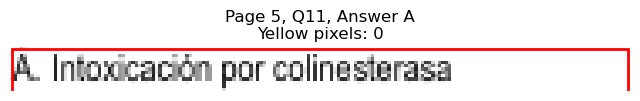

Page 5, Q11 - B: Detected box: x0=56.6, y0=682.6, x1=136.0, y1=695.3
Page 5, Q11, B: Yellow pixels: 0
Page 5, Q11, B: Total non-white pixels: 412
Page 5, Q11, B: Yellow percentage: 0.0%


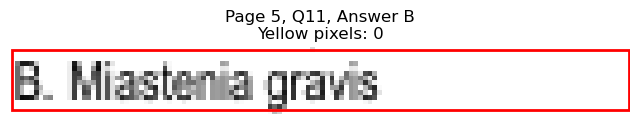

Page 5, Q11 - C: Detected box: x0=315.4, y0=670.0, x1=464.1, y1=682.7
Page 5, Q11, C: Yellow pixels: 4
Page 5, Q11, C: Total non-white pixels: 920
Page 5, Q11, C: Yellow percentage: 0.4%


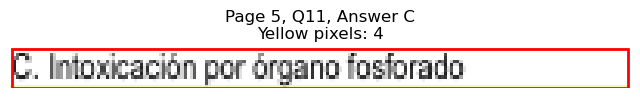

Page 5, Q11 - D: Detected box: x0=315.4, y0=682.6, x1=382.3, y1=695.3
Page 5, Q11, D: Yellow pixels: 1178
Page 5, Q11, D: Total non-white pixels: 1652
Page 5, Q11, D: Yellow percentage: 71.3%


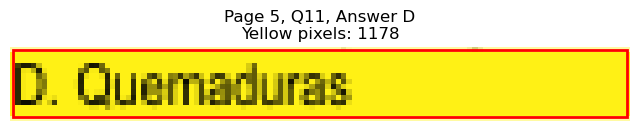


Page 5, Q11 - Selected Answer: D (based on yellow pixel count)
Page 5, Q12 - A: Detected box: x0=56.6, y0=720.6, x1=184.7, y1=733.2
Page 5, Q12, A: Yellow pixels: 1816
Page 5, Q12, A: Total non-white pixels: 2506
Page 5, Q12, A: Yellow percentage: 72.5%


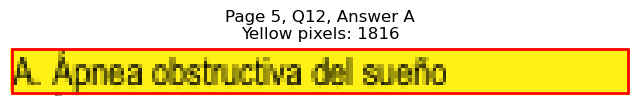

Page 5, Q12 - B: Detected box: x0=56.6, y0=733.2, x1=185.0, y1=745.8
Page 5, Q12, B: Yellow pixels: 0
Page 5, Q12, B: Total non-white pixels: 761
Page 5, Q12, B: Yellow percentage: 0.0%


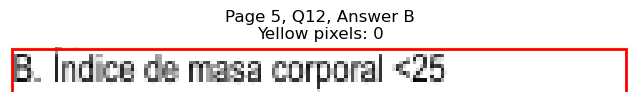

Page 5, Q12 - C: Detected box: x0=315.4, y0=720.6, x1=381.2, y1=733.2
Page 5, Q12, C: Yellow pixels: 0
Page 5, Q12, C: Total non-white pixels: 322
Page 5, Q12, C: Yellow percentage: 0.0%


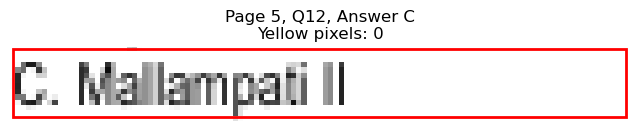

Page 5, Q12 - D: Detected box: x0=315.4, y0=733.2, x1=451.9, y1=745.8
Page 5, Q12, D: Yellow pixels: 0
Page 5, Q12, D: Total non-white pixels: 684
Page 5, Q12, D: Yellow percentage: 0.0%


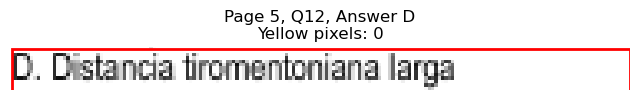


Page 5, Q12 - Selected Answer: A (based on yellow pixel count)

Page 6: Found 12 questions
Page 6, Q1 - A: Detected box: x0=56.6, y0=102.0, x1=109.0, y1=114.7
Page 6, Q1, A: Yellow pixels: 1158
Page 6, Q1, A: Total non-white pixels: 1339
Page 6, Q1, A: Yellow percentage: 86.5%


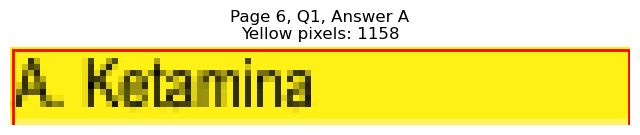

Page 6, Q1 - B: Detected box: x0=56.6, y0=114.6, x1=100.9, y1=127.3
Page 6, Q1, B: Yellow pixels: 95
Page 6, Q1, B: Total non-white pixels: 297
Page 6, Q1, B: Yellow percentage: 32.0%


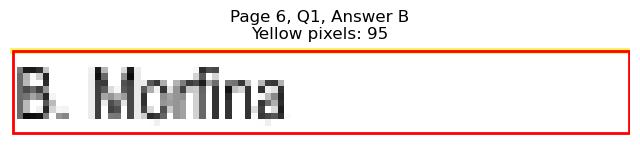

Page 6, Q1 - C: Detected box: x0=315.4, y0=102.0, x1=368.7, y1=114.7
Page 6, Q1, C: Yellow pixels: 0
Page 6, Q1, C: Total non-white pixels: 246
Page 6, Q1, C: Yellow percentage: 0.0%


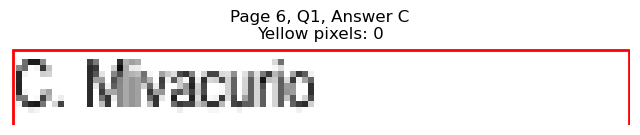

Page 6, Q1 - D: Detected box: x0=315.4, y0=114.6, x1=366.3, y1=127.3
Page 6, Q1, D: Yellow pixels: 0
Page 6, Q1, D: Total non-white pixels: 224
Page 6, Q1, D: Yellow percentage: 0.0%


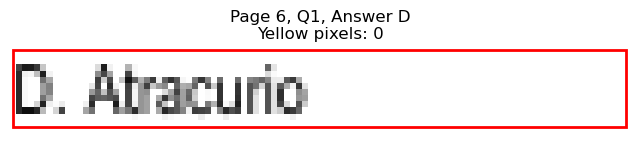


Page 6, Q1 - Selected Answer: A (based on yellow pixel count)
Page 6, Q2 - A: Detected box: x0=56.6, y0=165.1, x1=184.1, y1=177.8
Page 6, Q2, A: Yellow pixels: 1868
Page 6, Q2, A: Total non-white pixels: 2327
Page 6, Q2, A: Yellow percentage: 80.3%


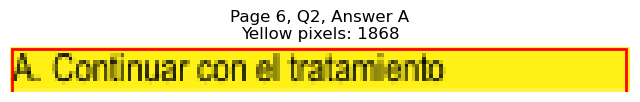

Page 6, Q2 - B: Detected box: x0=56.6, y0=177.7, x1=176.7, y1=190.4
Page 6, Q2, B: Yellow pixels: 171
Page 6, Q2, B: Total non-white pixels: 747
Page 6, Q2, B: Yellow percentage: 22.9%


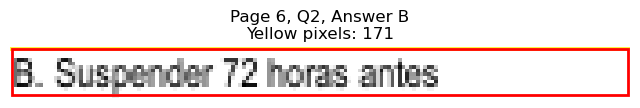

Page 6, Q2 - C: Detected box: x0=315.4, y0=165.1, x1=464.0, y1=177.8
Page 6, Q2, C: Yellow pixels: 0
Page 6, Q2, C: Total non-white pixels: 703
Page 6, Q2, C: Yellow percentage: 0.0%


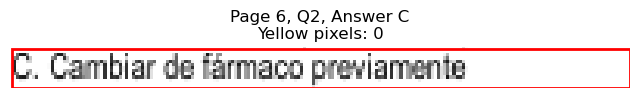

Page 6, Q2 - D: Detected box: x0=315.4, y0=177.7, x1=475.1, y1=190.4
Page 6, Q2, D: Yellow pixels: 0
Page 6, Q2, D: Total non-white pixels: 754
Page 6, Q2, D: Yellow percentage: 0.0%


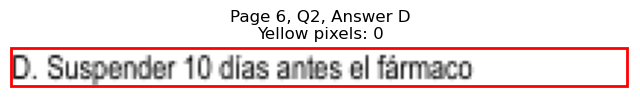


Page 6, Q2 - Selected Answer: A (based on yellow pixel count)
Page 6, Q3 - A: Detected box: x0=56.6, y0=215.6, x1=115.9, y1=228.3
Page 6, Q3, A: Yellow pixels: 0
Page 6, Q3, A: Total non-white pixels: 227
Page 6, Q3, A: Yellow percentage: 0.0%


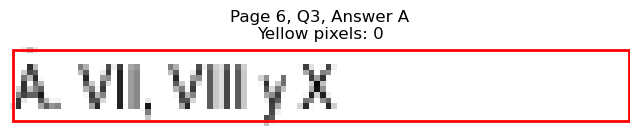

Page 6, Q3 - B: Detected box: x0=56.6, y0=228.2, x1=115.9, y1=240.9
Page 6, Q3, B: Yellow pixels: 0
Page 6, Q3, B: Total non-white pixels: 233
Page 6, Q3, B: Yellow percentage: 0.0%


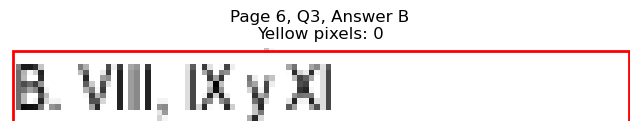

Page 6, Q3 - C: Detected box: x0=315.4, y0=215.6, x1=369.2, y1=228.3
Page 6, Q3, C: Yellow pixels: 1124
Page 6, Q3, C: Total non-white pixels: 1470
Page 6, Q3, C: Yellow percentage: 76.5%


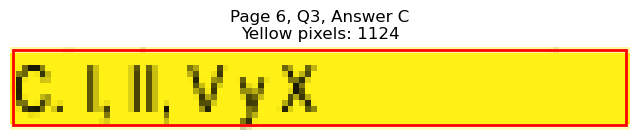

Page 6, Q3 - D: Detected box: x0=315.4, y0=228.2, x1=388.7, y1=240.9
Page 6, Q3, D: Yellow pixels: 0
Page 6, Q3, D: Total non-white pixels: 397
Page 6, Q3, D: Yellow percentage: 0.0%


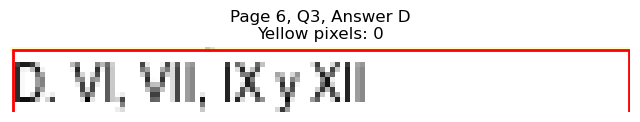


Page 6, Q3 - Selected Answer: C (based on yellow pixel count)
Page 6, Q4 - A: Detected box: x0=56.6, y0=278.8, x1=120.6, y1=291.4
Page 6, Q4, A: Yellow pixels: 0
Page 6, Q4, A: Total non-white pixels: 278
Page 6, Q4, A: Yellow percentage: 0.0%


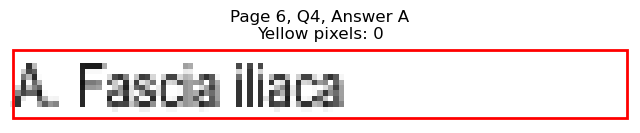

Page 6, Q4 - B: Detected box: x0=56.6, y0=291.4, x1=111.4, y1=304.0
Page 6, Q4, B: Yellow pixels: 0
Page 6, Q4, B: Total non-white pixels: 270
Page 6, Q4, B: Yellow percentage: 0.0%


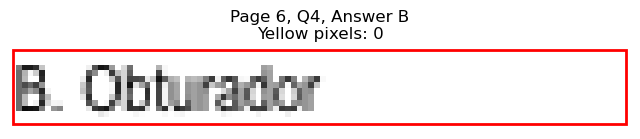

Page 6, Q4 - C: Detected box: x0=315.4, y0=278.8, x1=399.8, y1=291.4
Page 6, Q4, C: Yellow pixels: 1457
Page 6, Q4, C: Total non-white pixels: 1890
Page 6, Q4, C: Yellow percentage: 77.1%


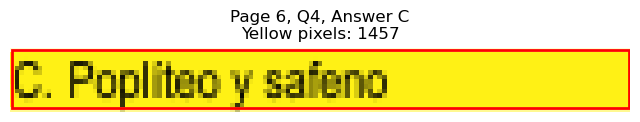

Page 6, Q4 - D: Detected box: x0=315.4, y0=291.4, x1=423.8, y1=304.0
Page 6, Q4, D: Yellow pixels: 158
Page 6, Q4, D: Total non-white pixels: 685
Page 6, Q4, D: Yellow percentage: 23.1%


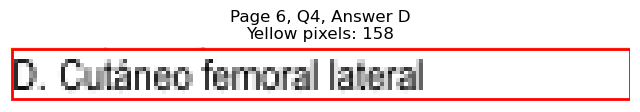


Page 6, Q4 - Selected Answer: C (based on yellow pixel count)
Page 6, Q5 - A: Detected box: x0=56.6, y0=329.2, x1=131.5, y1=341.8
Page 6, Q5, A: Yellow pixels: 0
Page 6, Q5, A: Total non-white pixels: 361
Page 6, Q5, A: Yellow percentage: 0.0%


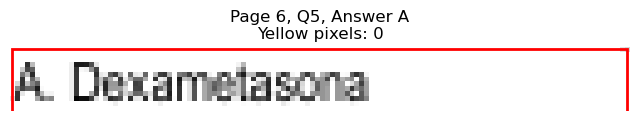

Page 6, Q5 - B: Detected box: x0=56.6, y0=341.9, x1=135.0, y1=354.6
Page 6, Q5, B: Yellow pixels: 1369
Page 6, Q5, B: Total non-white pixels: 1820
Page 6, Q5, B: Yellow percentage: 75.2%


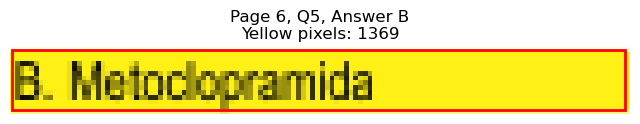

Page 6, Q5 - C: Detected box: x0=315.4, y0=329.2, x1=374.7, y1=341.8
Page 6, Q5, C: Yellow pixels: 0
Page 6, Q5, C: Total non-white pixels: 293
Page 6, Q5, C: Yellow percentage: 0.0%


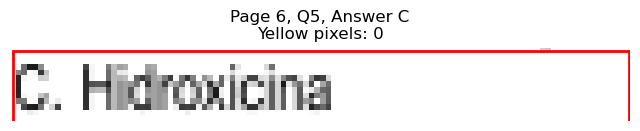

Page 6, Q5 - D: Detected box: x0=315.4, y0=341.9, x1=382.4, y1=354.6
Page 6, Q5, D: Yellow pixels: 0
Page 6, Q5, D: Total non-white pixels: 301
Page 6, Q5, D: Yellow percentage: 0.0%


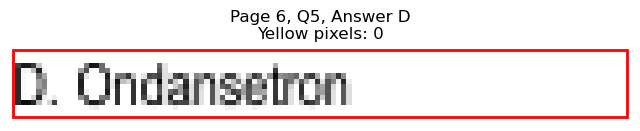


Page 6, Q5 - Selected Answer: B (based on yellow pixel count)
Page 6, Q6 - A: Detected box: x0=56.6, y0=379.7, x1=131.5, y1=392.4
Page 6, Q6, A: Yellow pixels: 0
Page 6, Q6, A: Total non-white pixels: 332
Page 6, Q6, A: Yellow percentage: 0.0%


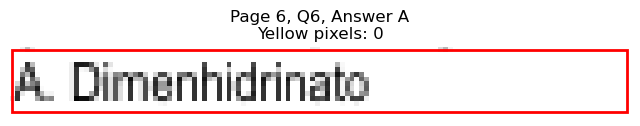

Page 6, Q6 - B: Detected box: x0=56.6, y0=392.3, x1=112.0, y1=405.0
Page 6, Q6, B: Yellow pixels: 0
Page 6, Q6, B: Total non-white pixels: 275
Page 6, Q6, B: Yellow percentage: 0.0%


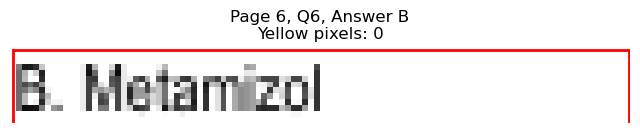

Page 6, Q6 - C: Detected box: x0=315.4, y0=379.7, x1=367.6, y1=392.4
Page 6, Q6, C: Yellow pixels: 1036
Page 6, Q6, C: Total non-white pixels: 1442
Page 6, Q6, C: Yellow percentage: 71.8%


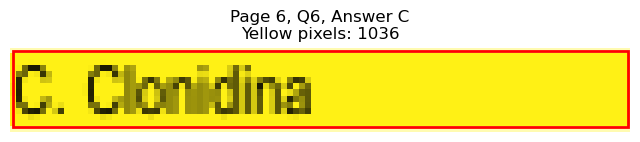

Page 6, Q6 - D: Detected box: x0=315.4, y0=392.3, x1=380.7, y1=405.0
Page 6, Q6, D: Yellow pixels: 0
Page 6, Q6, D: Total non-white pixels: 416
Page 6, Q6, D: Yellow percentage: 0.0%


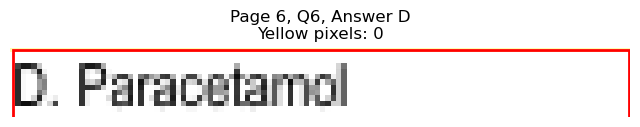


Page 6, Q6 - Selected Answer: C (based on yellow pixel count)
Page 6, Q7 - A: Detected box: x0=56.6, y0=442.8, x1=120.5, y1=455.5
Page 6, Q7, A: Yellow pixels: 1270
Page 6, Q7, A: Total non-white pixels: 1610
Page 6, Q7, A: Yellow percentage: 78.9%


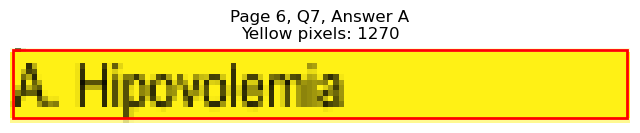

Page 6, Q7 - B: Detected box: x0=56.6, y0=455.5, x1=143.5, y1=468.1
Page 6, Q7, B: Yellow pixels: 0
Page 6, Q7, B: Total non-white pixels: 410
Page 6, Q7, B: Yellow percentage: 0.0%


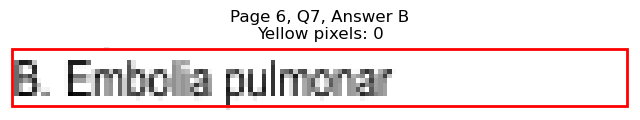

Page 6, Q7 - C: Detected box: x0=315.4, y0=442.8, x1=394.4, y1=455.5
Page 6, Q7, C: Yellow pixels: 0
Page 6, Q7, C: Total non-white pixels: 411
Page 6, Q7, C: Yellow percentage: 0.0%


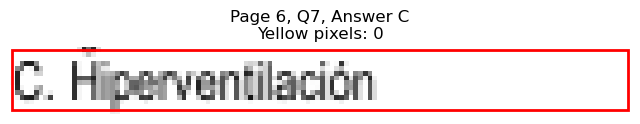

Page 6, Q7 - D: Detected box: x0=315.4, y0=455.5, x1=369.2, y1=468.1
Page 6, Q7, D: Yellow pixels: 0
Page 6, Q7, D: Total non-white pixels: 256
Page 6, Q7, D: Yellow percentage: 0.0%


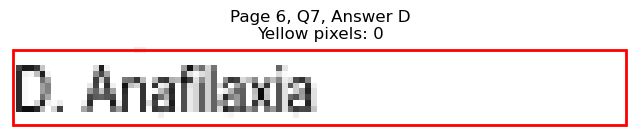


Page 6, Q7 - Selected Answer: A (based on yellow pixel count)
Page 6, Q8 - A: Detected box: x0=56.6, y0=493.4, x1=75.9, y1=506.0
Page 6, Q8, A: Yellow pixels: 0
Page 6, Q8, A: Total non-white pixels: 56
Page 6, Q8, A: Yellow percentage: 0.0%


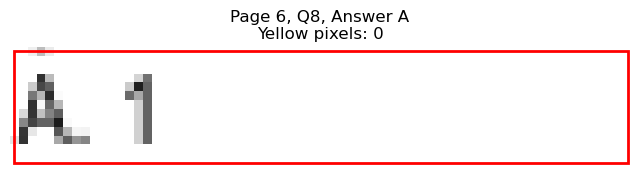

Page 6, Q8 - B: Detected box: x0=56.6, y0=506.0, x1=75.9, y1=518.6
Page 6, Q8, B: Yellow pixels: 0
Page 6, Q8, B: Total non-white pixels: 69
Page 6, Q8, B: Yellow percentage: 0.0%


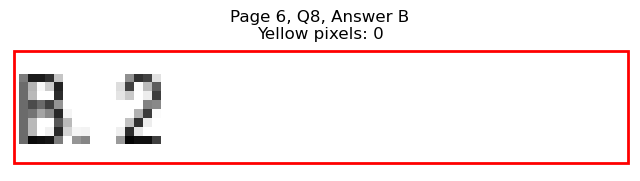

Page 6, Q8 - C: Detected box: x0=315.4, y0=493.4, x1=335.1, y1=506.0
Page 6, Q8, C: Yellow pixels: 71
Page 6, Q8, C: Total non-white pixels: 208
Page 6, Q8, C: Yellow percentage: 34.1%


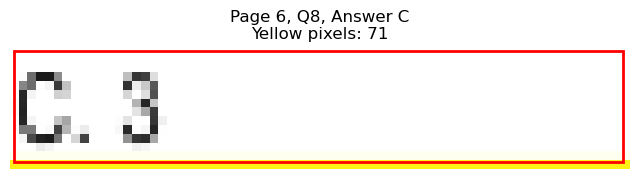

Page 6, Q8 - D: Detected box: x0=315.4, y0=506.0, x1=335.1, y1=518.6
Page 6, Q8, D: Yellow pixels: 869
Page 6, Q8, D: Total non-white pixels: 994
Page 6, Q8, D: Yellow percentage: 87.4%


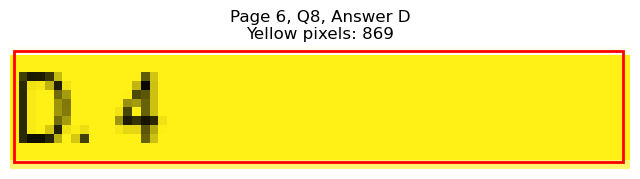


Page 6, Q8 - Selected Answer: D (based on yellow pixel count)
Page 6, Q9 - A: Detected box: x0=56.6, y0=556.5, x1=139.0, y1=569.1
Page 6, Q9, A: Yellow pixels: 0
Page 6, Q9, A: Total non-white pixels: 385
Page 6, Q9, A: Yellow percentage: 0.0%


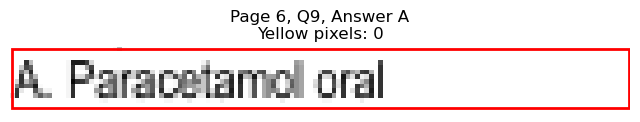

Page 6, Q9 - B: Detected box: x0=56.6, y0=569.1, x1=124.5, y1=581.7
Page 6, Q9, B: Yellow pixels: 0
Page 6, Q9, B: Total non-white pixels: 336
Page 6, Q9, B: Yellow percentage: 0.0%


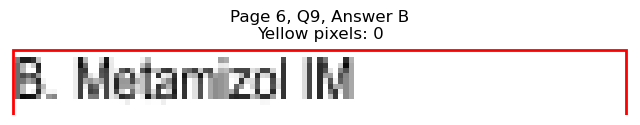

Page 6, Q9 - C: Detected box: x0=315.4, y0=556.5, x1=442.6, y1=569.1
Page 6, Q9, C: Yellow pixels: 1864
Page 6, Q9, C: Total non-white pixels: 2492
Page 6, Q9, C: Yellow percentage: 74.8%


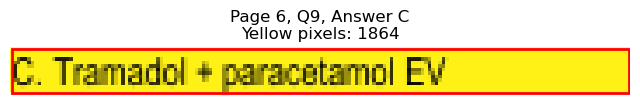

Page 6, Q9 - D: Detected box: x0=315.4, y0=569.1, x1=396.3, y1=581.7
Page 6, Q9, D: Yellow pixels: 0
Page 6, Q9, D: Total non-white pixels: 523
Page 6, Q9, D: Yellow percentage: 0.0%


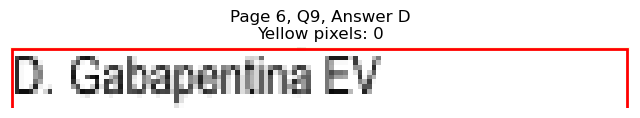


Page 6, Q9 - Selected Answer: C (based on yellow pixel count)
Page 6, Q10 - A: Detected box: x0=56.6, y0=606.9, x1=237.4, y1=619.5
Page 6, Q10, A: Yellow pixels: 0
Page 6, Q10, A: Total non-white pixels: 917
Page 6, Q10, A: Yellow percentage: 0.0%


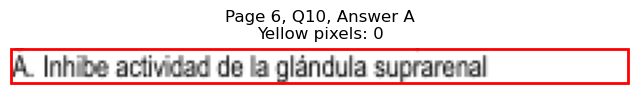

Page 6, Q10 - B: Detected box: x0=56.6, y0=619.6, x1=137.2, y1=632.3
Page 6, Q10, B: Yellow pixels: 0
Page 6, Q10, B: Total non-white pixels: 385
Page 6, Q10, B: Yellow percentage: 0.0%


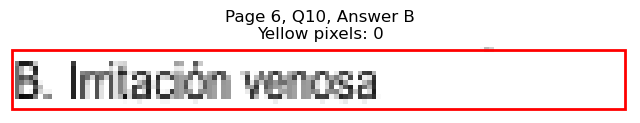

Page 6, Q10 - C: Detected box: x0=315.4, y0=606.9, x1=415.9, y1=619.5
Page 6, Q10, C: Yellow pixels: 0
Page 6, Q10, C: Total non-white pixels: 510
Page 6, Q10, C: Yellow percentage: 0.0%


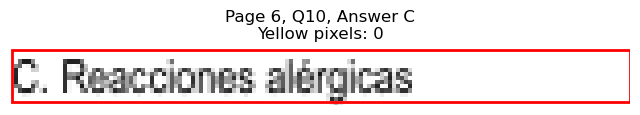

Page 6, Q10 - D: Detected box: x0=315.4, y0=619.6, x1=418.9, y1=632.3
Page 6, Q10, D: Yellow pixels: 1442
Page 6, Q10, D: Total non-white pixels: 2156
Page 6, Q10, D: Yellow percentage: 66.9%


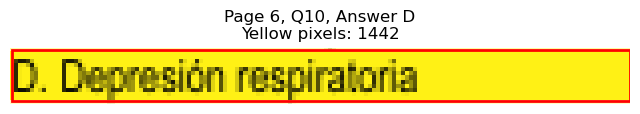


Page 6, Q10 - Selected Answer: D (based on yellow pixel count)
Page 6, Q11 - A: Detected box: x0=56.6, y0=657.4, x1=126.5, y1=670.1
Page 6, Q11, A: Yellow pixels: 0
Page 6, Q11, A: Total non-white pixels: 278
Page 6, Q11, A: Yellow percentage: 0.0%


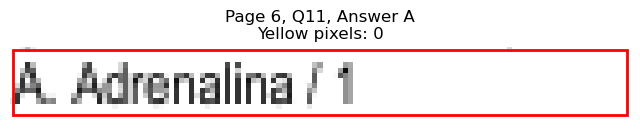

Page 6, Q11 - B: Detected box: x0=56.6, y0=670.0, x1=124.5, y1=682.7
Page 6, Q11, B: Yellow pixels: 0
Page 6, Q11, B: Total non-white pixels: 308
Page 6, Q11, B: Yellow percentage: 0.0%


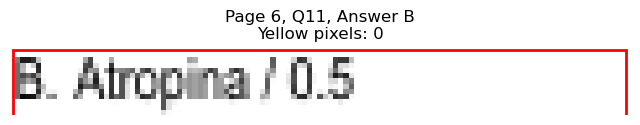

Page 6, Q11 - C: Detected box: x0=315.4, y0=657.4, x1=376.3, y1=670.1
Page 6, Q11, C: Yellow pixels: 1249
Page 6, Q11, C: Total non-white pixels: 1568
Page 6, Q11, C: Yellow percentage: 79.7%


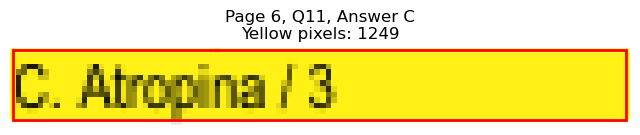

Page 6, Q11 - D: Detected box: x0=315.4, y0=670.0, x1=396.3, y1=682.7
Page 6, Q11, D: Yellow pixels: 0
Page 6, Q11, D: Total non-white pixels: 507
Page 6, Q11, D: Yellow percentage: 0.0%


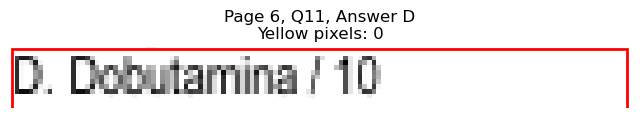


Page 6, Q11 - Selected Answer: C (based on yellow pixel count)
Page 6, Q12 - A: Detected box: x0=56.6, y0=708.0, x1=100.9, y1=720.6
Page 6, Q12, A: Yellow pixels: 95
Page 6, Q12, A: Total non-white pixels: 306
Page 6, Q12, A: Yellow percentage: 31.0%


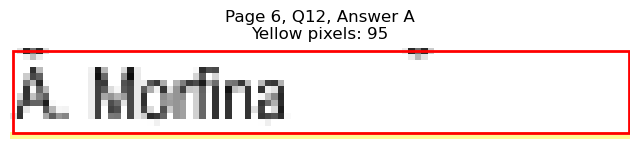

Page 6, Q12 - B: Detected box: x0=56.6, y0=720.6, x1=120.5, y1=733.2
Page 6, Q12, B: Yellow pixels: 1250
Page 6, Q12, B: Total non-white pixels: 1610
Page 6, Q12, B: Yellow percentage: 77.6%


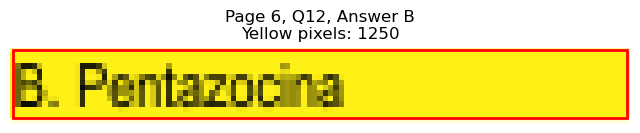

Page 6, Q12 - C: Detected box: x0=315.4, y0=708.0, x1=367.1, y1=720.6
Page 6, Q12, C: Yellow pixels: 0
Page 6, Q12, C: Total non-white pixels: 236
Page 6, Q12, C: Yellow percentage: 0.0%


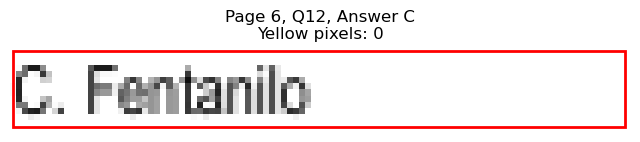

Page 6, Q12 - D: Detected box: x0=315.4, y0=720.6, x1=384.7, y1=733.2
Page 6, Q12, D: Yellow pixels: 0
Page 6, Q12, D: Total non-white pixels: 333
Page 6, Q12, D: Yellow percentage: 0.0%


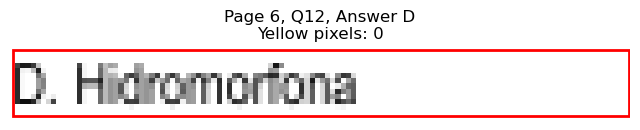


Page 6, Q12 - Selected Answer: B (based on yellow pixel count)

Page 7: Found 11 questions
Page 7, Q1 - A: Detected box: x0=56.6, y0=89.4, x1=103.9, y1=102.1
Page 7, Q1, A: Yellow pixels: 0
Page 7, Q1, A: Total non-white pixels: 170
Page 7, Q1, A: Yellow percentage: 0.0%


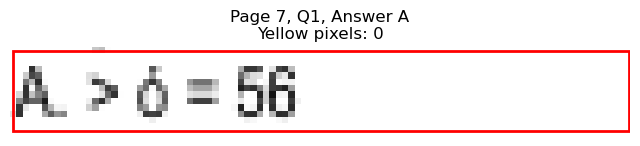

Page 7, Q1 - B: Detected box: x0=56.6, y0=102.0, x1=103.9, y1=114.7
Page 7, Q1, B: Yellow pixels: 0
Page 7, Q1, B: Total non-white pixels: 153
Page 7, Q1, B: Yellow percentage: 0.0%


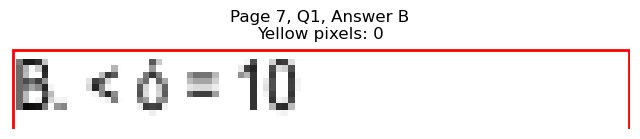

Page 7, Q1 - C: Detected box: x0=315.4, y0=89.4, x1=363.2, y1=102.1
Page 7, Q1, C: Yellow pixels: 99
Page 7, Q1, C: Total non-white pixels: 257
Page 7, Q1, C: Yellow percentage: 38.5%


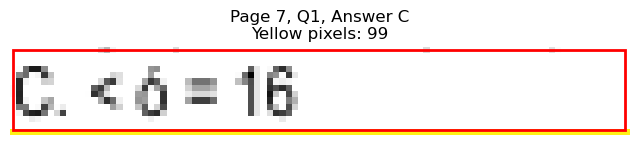

Page 7, Q1 - D: Detected box: x0=315.4, y0=102.0, x1=363.2, y1=114.7
Page 7, Q1, D: Yellow pixels: 1161
Page 7, Q1, D: Total non-white pixels: 1287
Page 7, Q1, D: Yellow percentage: 90.2%


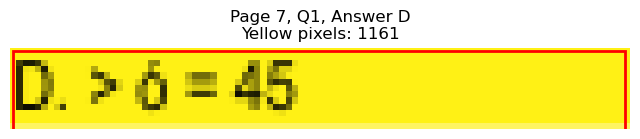


Page 7, Q1 - Selected Answer: D (based on yellow pixel count)
Page 7, Q2 - A: Detected box: x0=56.6, y0=152.5, x1=75.9, y1=165.2
Page 7, Q2, A: Yellow pixels: 70
Page 7, Q2, A: Total non-white pixels: 129
Page 7, Q2, A: Yellow percentage: 54.3%


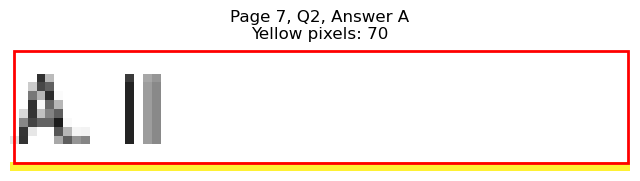

Page 7, Q2 - B: Detected box: x0=56.6, y0=569.1, x1=78.4, y1=581.7
Page 7, Q2, B: Yellow pixels: 0
Page 7, Q2, B: Total non-white pixels: 74
Page 7, Q2, B: Yellow percentage: 0.0%


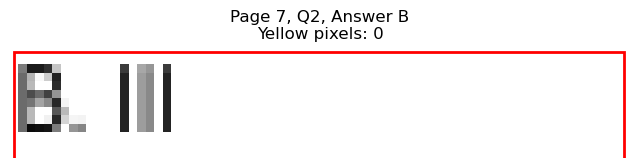

Page 7, Q2 - C: Detected box: x0=315.4, y0=152.5, x1=338.6, y1=165.2
Page 7, Q2, C: Yellow pixels: 0
Page 7, Q2, C: Total non-white pixels: 79
Page 7, Q2, C: Yellow percentage: 0.0%


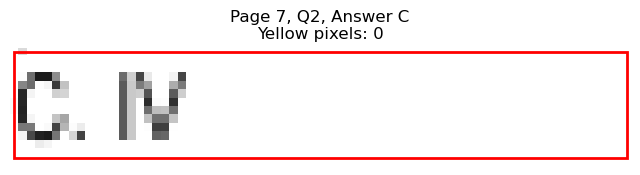

Page 7, Q2 - D: Detected box: x0=315.4, y0=165.1, x1=336.1, y1=177.8
Page 7, Q2, D: Yellow pixels: 0
Page 7, Q2, D: Total non-white pixels: 69
Page 7, Q2, D: Yellow percentage: 0.0%


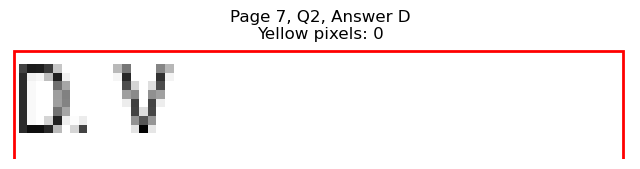


Page 7, Q2 - Selected Answer: A (based on yellow pixel count)
Page 7, Q3 - A: Detected box: x0=56.6, y0=228.2, x1=101.7, y1=240.9
Page 7, Q3, A: Yellow pixels: 0
Page 7, Q3, A: Total non-white pixels: 256
Page 7, Q3, A: Yellow percentage: 0.0%


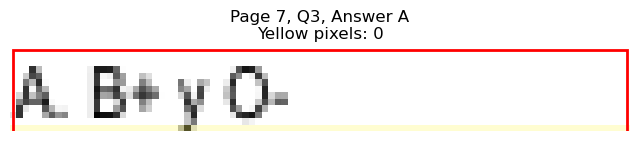

Page 7, Q3 - B: Detected box: x0=56.6, y0=240.8, x1=99.4, y1=253.5
Page 7, Q3, B: Yellow pixels: 1099
Page 7, Q3, B: Total non-white pixels: 1316
Page 7, Q3, B: Yellow percentage: 83.5%


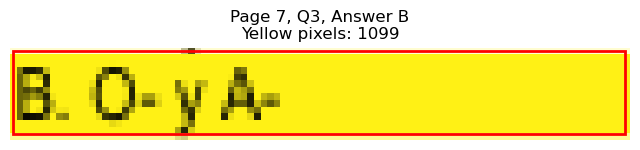

Page 7, Q3 - C: Detected box: x0=315.4, y0=228.2, x1=368.2, y1=240.9
Page 7, Q3, C: Yellow pixels: 0
Page 7, Q3, C: Total non-white pixels: 197
Page 7, Q3, C: Yellow percentage: 0.0%


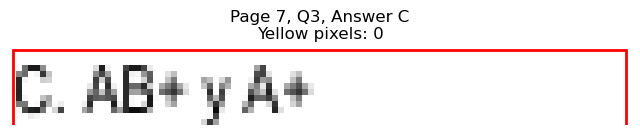

Page 7, Q3 - D: Detected box: x0=315.4, y0=240.8, x1=363.2, y1=253.5
Page 7, Q3, D: Yellow pixels: 0
Page 7, Q3, D: Total non-white pixels: 177
Page 7, Q3, D: Yellow percentage: 0.0%


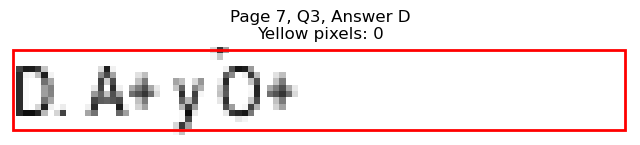


Page 7, Q3 - Selected Answer: B (based on yellow pixel count)
Page 7, Q4 - A: Detected box: x0=56.6, y0=278.8, x1=317.1, y1=291.4
Page 7, Q4, A: Yellow pixels: 312
Page 7, Q4, A: Total non-white pixels: 1578
Page 7, Q4, A: Yellow percentage: 19.8%


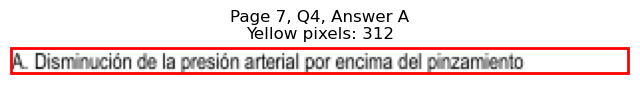

Page 7, Q4 - B: Detected box: x0=56.6, y0=291.4, x1=304.0, y1=304.0
Page 7, Q4, B: Yellow pixels: 2918
Page 7, Q4, B: Total non-white pixels: 4186
Page 7, Q4, B: Yellow percentage: 69.7%


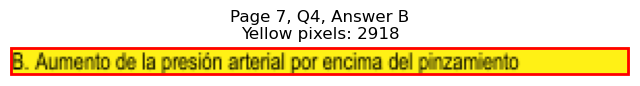

Page 7, Q4 - C: Detected box: x0=56.6, y0=304.0, x1=243.3, y1=316.6
Page 7, Q4, C: Yellow pixels: 232
Page 7, Q4, C: Total non-white pixels: 1324
Page 7, Q4, C: Yellow percentage: 17.5%


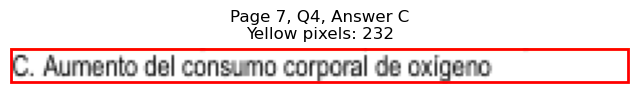

Page 7, Q4 - D: Detected box: x0=56.6, y0=316.6, x1=154.6, y1=329.2
Page 7, Q4, D: Yellow pixels: 0
Page 7, Q4, D: Total non-white pixels: 478
Page 7, Q4, D: Yellow percentage: 0.0%


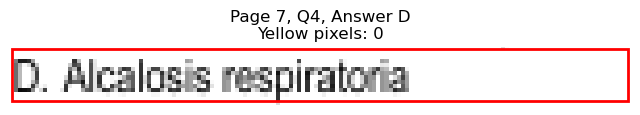


Page 7, Q4 - Selected Answer: B (based on yellow pixel count)
Page 7, Q5 - A: Detected box: x0=56.6, y0=354.5, x1=298.1, y1=367.2
Page 7, Q5, A: Yellow pixels: 0
Page 7, Q5, A: Total non-white pixels: 1196
Page 7, Q5, A: Yellow percentage: 0.0%


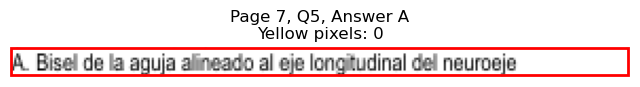

Page 7, Q5 - B: Detected box: x0=56.6, y0=367.1, x1=130.0, y1=379.8
Page 7, Q5, B: Yellow pixels: 0
Page 7, Q5, B: Total non-white pixels: 362
Page 7, Q5, B: Yellow percentage: 0.0%


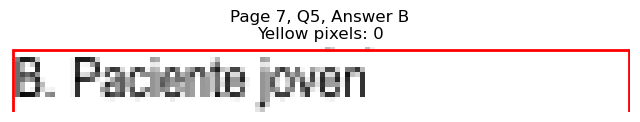

Page 7, Q5 - C: Detected box: x0=56.6, y0=379.7, x1=278.0, y1=392.4
Page 7, Q5, C: Yellow pixels: 272
Page 7, Q5, C: Total non-white pixels: 1363
Page 7, Q5, C: Yellow percentage: 20.0%


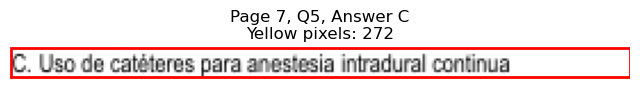

Page 7, Q5 - D: Detected box: x0=56.6, y0=392.3, x1=311.1, y1=405.0
Page 7, Q5, D: Yellow pixels: 2974
Page 7, Q5, D: Total non-white pixels: 3978
Page 7, Q5, D: Yellow percentage: 74.8%


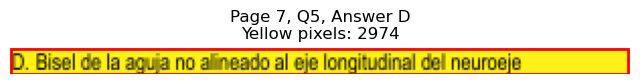


Page 7, Q5 - Selected Answer: D (based on yellow pixel count)
Page 7, Q6 - A: Detected box: x0=56.6, y0=442.8, x1=102.4, y1=455.5
Page 7, Q6, A: Yellow pixels: 1114
Page 7, Q6, A: Total non-white pixels: 1358
Page 7, Q6, A: Yellow percentage: 82.0%


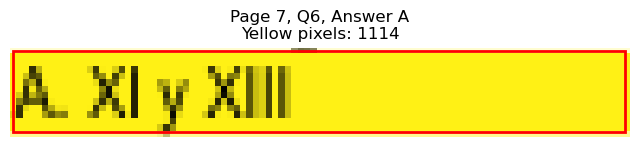

Page 7, Q6 - B: Detected box: x0=56.6, y0=455.5, x1=182.7, y1=468.1
Page 7, Q6, B: Yellow pixels: 0
Page 7, Q6, B: Total non-white pixels: 600
Page 7, Q6, B: Yellow percentage: 0.0%


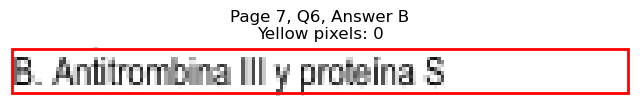

Page 7, Q6 - C: Detected box: x0=315.4, y0=442.8, x1=350.6, y1=455.5
Page 7, Q6, C: Yellow pixels: 0
Page 7, Q6, C: Total non-white pixels: 123
Page 7, Q6, C: Yellow percentage: 0.0%


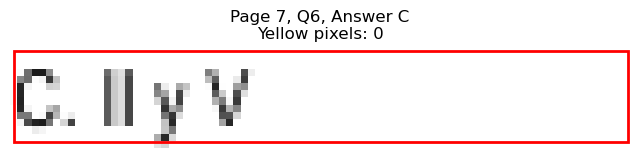

Page 7, Q6 - D: Detected box: x0=315.4, y0=455.5, x1=440.9, y1=468.1
Page 7, Q6, D: Yellow pixels: 0
Page 7, Q6, D: Total non-white pixels: 584
Page 7, Q6, D: Yellow percentage: 0.0%


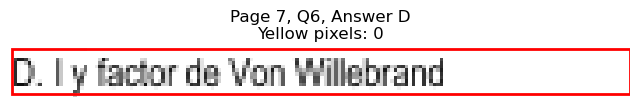


Page 7, Q6 - Selected Answer: A (based on yellow pixel count)
Page 7, Q7 - A: Detected box: x0=56.6, y0=506.0, x1=100.9, y1=518.6
Page 7, Q7, A: Yellow pixels: 0
Page 7, Q7, A: Total non-white pixels: 199
Page 7, Q7, A: Yellow percentage: 0.0%


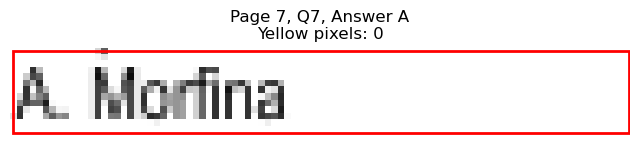

Page 7, Q7 - B: Detected box: x0=56.6, y0=518.6, x1=106.9, y1=531.2
Page 7, Q7, B: Yellow pixels: 0
Page 7, Q7, B: Total non-white pixels: 236
Page 7, Q7, B: Yellow percentage: 0.0%


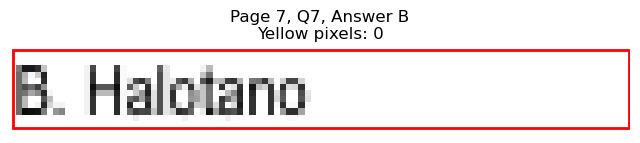

Page 7, Q7 - C: Detected box: x0=315.4, y0=506.0, x1=385.3, y1=518.6
Page 7, Q7, C: Yellow pixels: 1315
Page 7, Q7, C: Total non-white pixels: 1694
Page 7, Q7, C: Yellow percentage: 77.6%


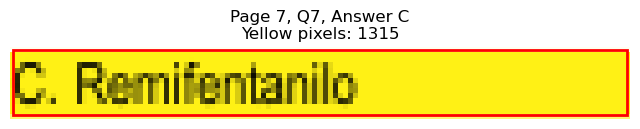

Page 7, Q7 - D: Detected box: x0=315.4, y0=518.6, x1=376.1, y1=531.2
Page 7, Q7, D: Yellow pixels: 112
Page 7, Q7, D: Total non-white pixels: 420
Page 7, Q7, D: Yellow percentage: 26.7%


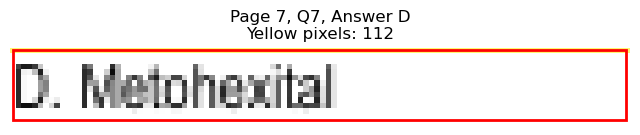


Page 7, Q7 - Selected Answer: C (based on yellow pixel count)
Page 7, Q8 - A: Detected box: x0=56.6, y0=556.5, x1=79.3, y1=569.1
Page 7, Q8, A: Yellow pixels: 0
Page 7, Q8, A: Total non-white pixels: 71
Page 7, Q8, A: Yellow percentage: 0.0%


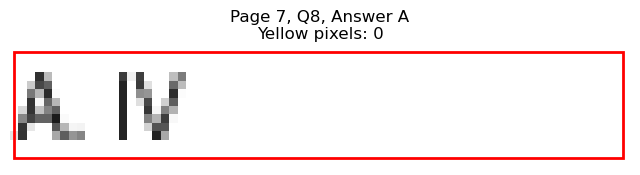

Page 7, Q8 - B: Detected box: x0=56.6, y0=569.1, x1=78.4, y1=581.7
Page 7, Q8, B: Yellow pixels: 0
Page 7, Q8, B: Total non-white pixels: 74
Page 7, Q8, B: Yellow percentage: 0.0%


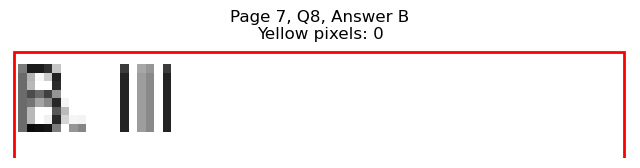

Page 7, Q8 - C: Detected box: x0=315.4, y0=556.5, x1=336.1, y1=569.1
Page 7, Q8, C: Yellow pixels: 889
Page 7, Q8, C: Total non-white pixels: 1008
Page 7, Q8, C: Yellow percentage: 88.2%


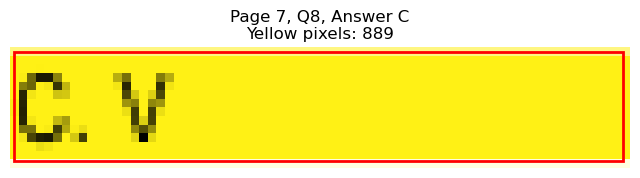

Page 7, Q8 - D: Detected box: x0=315.4, y0=569.1, x1=338.6, y1=581.7
Page 7, Q8, D: Yellow pixels: 0
Page 7, Q8, D: Total non-white pixels: 159
Page 7, Q8, D: Yellow percentage: 0.0%


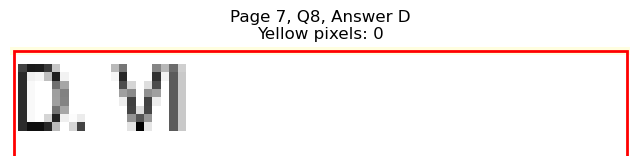


Page 7, Q8 - Selected Answer: C (based on yellow pixel count)
Page 7, Q9 - A: Detected box: x0=56.6, y0=619.6, x1=180.1, y1=632.3
Page 7, Q9, A: Yellow pixels: 1623
Page 7, Q9, A: Total non-white pixels: 2450
Page 7, Q9, A: Yellow percentage: 66.2%


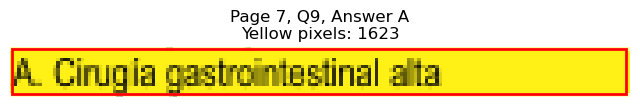

Page 7, Q9 - B: Detected box: x0=56.6, y0=632.2, x1=118.0, y1=644.9
Page 7, Q9, B: Yellow pixels: 0
Page 7, Q9, B: Total non-white pixels: 419
Page 7, Q9, B: Yellow percentage: 0.0%


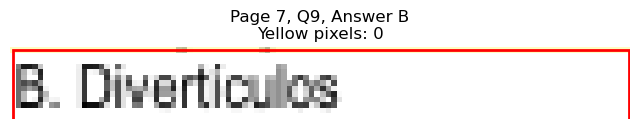

Page 7, Q9 - C: Detected box: x0=315.4, y0=619.6, x1=356.1, y1=632.3
Page 7, Q9, C: Yellow pixels: 0
Page 7, Q9, C: Total non-white pixels: 158
Page 7, Q9, C: Yellow percentage: 0.0%


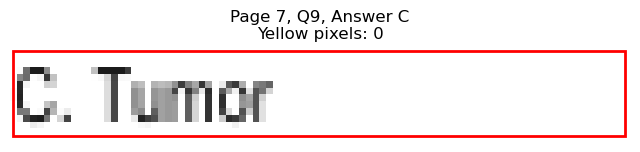

Page 7, Q9 - D: Detected box: x0=315.4, y0=632.2, x1=374.2, y1=644.9
Page 7, Q9, D: Yellow pixels: 0
Page 7, Q9, D: Total non-white pixels: 265
Page 7, Q9, D: Yellow percentage: 0.0%


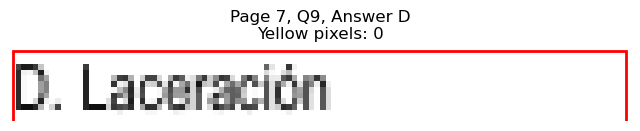


Page 7, Q9 - Selected Answer: A (based on yellow pixel count)
Page 7, Q10 - A: Detected box: x0=56.6, y0=670.0, x1=112.0, y1=682.7
Page 7, Q10, A: Yellow pixels: 0
Page 7, Q10, A: Total non-white pixels: 337
Page 7, Q10, A: Yellow percentage: 0.0%


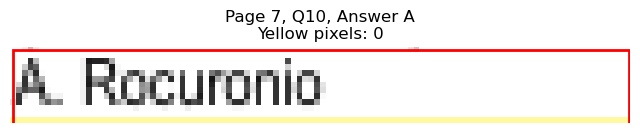

Page 7, Q10 - B: Detected box: x0=56.6, y0=682.6, x1=125.4, y1=695.3
Page 7, Q10, B: Yellow pixels: 1171
Page 7, Q10, B: Total non-white pixels: 1680
Page 7, Q10, B: Yellow percentage: 69.7%


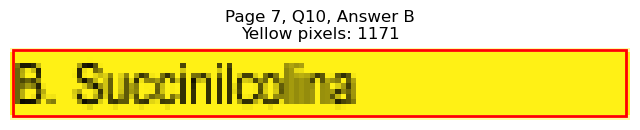

Page 7, Q10 - C: Detected box: x0=315.4, y0=670.0, x1=375.7, y1=682.7
Page 7, Q10, C: Yellow pixels: 0
Page 7, Q10, C: Total non-white pixels: 264
Page 7, Q10, C: Yellow percentage: 0.0%


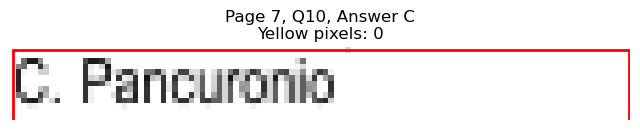

Page 7, Q10 - D: Detected box: x0=315.4, y0=682.6, x1=366.2, y1=695.3
Page 7, Q10, D: Yellow pixels: 0
Page 7, Q10, D: Total non-white pixels: 224
Page 7, Q10, D: Yellow percentage: 0.0%


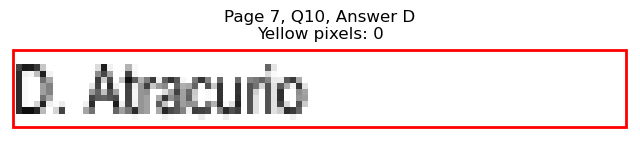


Page 7, Q10 - Selected Answer: B (based on yellow pixel count)
Page 7, Q11 - A: Detected box: x0=56.6, y0=720.6, x1=88.3, y1=733.2
Page 7, Q11, A: Yellow pixels: 0
Page 7, Q11, A: Total non-white pixels: 125
Page 7, Q11, A: Yellow percentage: 0.0%


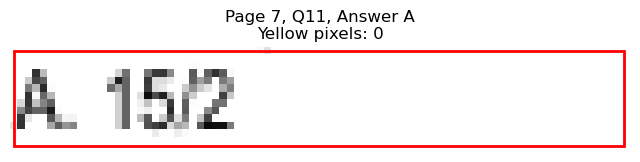

Page 7, Q11 - B: Detected box: x0=56.6, y0=733.2, x1=83.4, y1=745.8
Page 7, Q11, B: Yellow pixels: 0
Page 7, Q11, B: Total non-white pixels: 108
Page 7, Q11, B: Yellow percentage: 0.0%


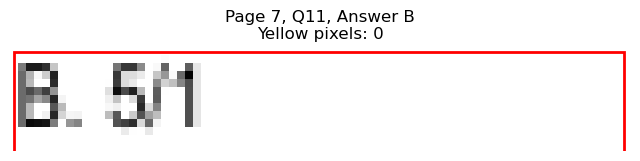

Page 7, Q11 - C: Detected box: x0=315.4, y0=720.6, x1=347.6, y1=733.2
Page 7, Q11, C: Yellow pixels: 83
Page 7, Q11, C: Total non-white pixels: 194
Page 7, Q11, C: Yellow percentage: 42.8%


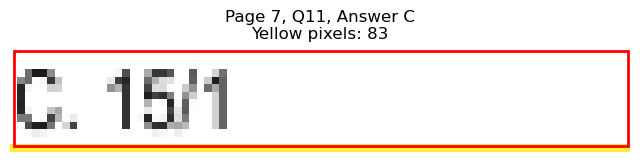

Page 7, Q11 - D: Detected box: x0=315.4, y0=733.2, x1=345.2, y1=745.8
Page 7, Q11, D: Yellow pixels: 953
Page 7, Q11, D: Total non-white pixels: 1053
Page 7, Q11, D: Yellow percentage: 90.5%


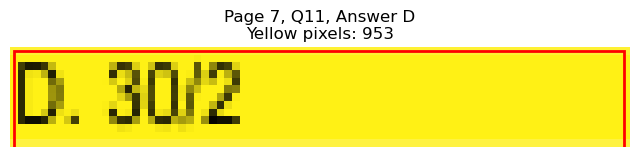


Page 7, Q11 - Selected Answer: D (based on yellow pixel count)

Page 8: Found 11 questions
Page 8, Q1 - A: Detected box: x0=56.6, y0=114.6, x1=165.3, y1=127.3
Page 8, Q1, A: Yellow pixels: 0
Page 8, Q1, A: Total non-white pixels: 493
Page 8, Q1, A: Yellow percentage: 0.0%


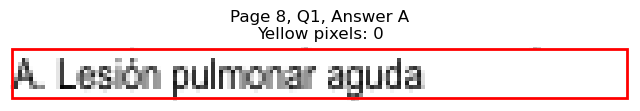

Page 8, Q1 - B: Detected box: x0=56.6, y0=127.2, x1=159.6, y1=139.9
Page 8, Q1, B: Yellow pixels: 0
Page 8, Q1, B: Total non-white pixels: 477
Page 8, Q1, B: Yellow percentage: 0.0%


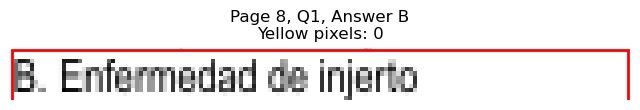

Page 8, Q1 - C: Detected box: x0=315.4, y0=114.6, x1=406.3, y1=127.3
Page 8, Q1, C: Yellow pixels: 142
Page 8, Q1, C: Total non-white pixels: 567
Page 8, Q1, C: Yellow percentage: 25.0%


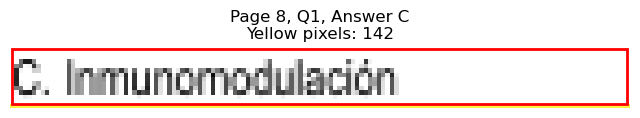

Page 8, Q1 - D: Detected box: x0=315.4, y0=127.2, x1=422.8, y1=139.9
Page 8, Q1, D: Yellow pixels: 1649
Page 8, Q1, D: Total non-white pixels: 2054
Page 8, Q1, D: Yellow percentage: 80.3%


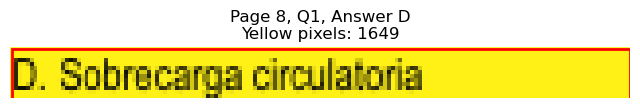


Page 8, Q1 - Selected Answer: D (based on yellow pixel count)
Page 8, Q2 - A: Detected box: x0=56.6, y0=190.3, x1=143.5, y1=203.0
Page 8, Q2, A: Yellow pixels: 1478
Page 8, Q2, A: Total non-white pixels: 1794
Page 8, Q2, A: Yellow percentage: 82.4%


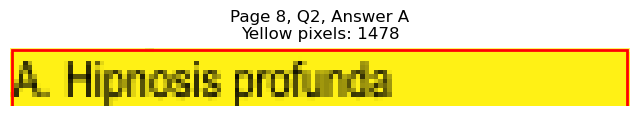

Page 8, Q2 - B: Detected box: x0=56.6, y0=202.9, x1=109.5, y1=215.6
Page 8, Q2, B: Yellow pixels: 102
Page 8, Q2, B: Total non-white pixels: 355
Page 8, Q2, B: Yellow percentage: 28.7%


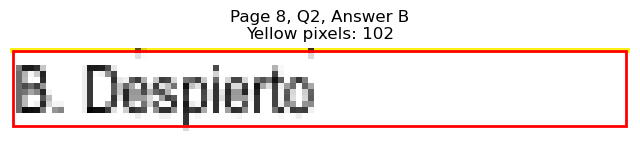

Page 8, Q2 - C: Detected box: x0=315.4, y0=190.3, x1=410.8, y1=203.0
Page 8, Q2, C: Yellow pixels: 0
Page 8, Q2, C: Total non-white pixels: 456
Page 8, Q2, C: Yellow percentage: 0.0%


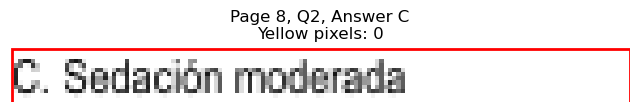

Page 8, Q2 - D: Detected box: x0=315.4, y0=202.9, x1=402.3, y1=215.6
Page 8, Q2, D: Yellow pixels: 0
Page 8, Q2, D: Total non-white pixels: 425
Page 8, Q2, D: Yellow percentage: 0.0%


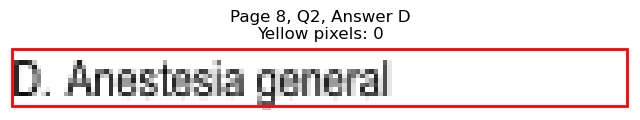


Page 8, Q2 - Selected Answer: A (based on yellow pixel count)
Page 8, Q3 - A: Detected box: x0=56.6, y0=240.8, x1=369.5, y1=253.5
Page 8, Q3, A: Yellow pixels: 3572
Page 8, Q3, A: Total non-white pixels: 5096
Page 8, Q3, A: Yellow percentage: 70.1%


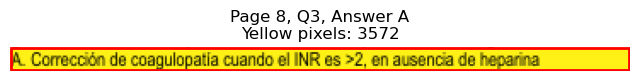

Page 8, Q3 - B: Detected box: x0=56.6, y0=253.4, x1=399.3, y1=266.1
Page 8, Q3, B: Yellow pixels: 393
Page 8, Q3, B: Total non-white pixels: 2070
Page 8, Q3, B: Yellow percentage: 19.0%


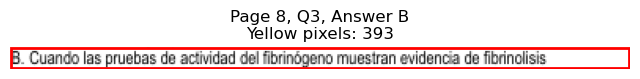

Page 8, Q3 - C: Detected box: x0=56.6, y0=266.0, x1=412.9, y1=278.7
Page 8, Q3, C: Yellow pixels: 0
Page 8, Q3, C: Total non-white pixels: 1731
Page 8, Q3, C: Yellow percentage: 0.0%


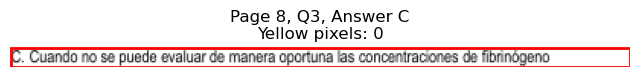

Page 8, Q3 - D: Detected box: x0=56.6, y0=278.8, x1=314.7, y1=291.4
Page 8, Q3, D: Yellow pixels: 0
Page 8, Q3, D: Total non-white pixels: 1312
Page 8, Q3, D: Yellow percentage: 0.0%


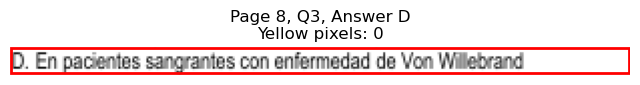


Page 8, Q3 - Selected Answer: A (based on yellow pixel count)
Page 8, Q4 - A: Detected box: x0=56.6, y0=316.6, x1=237.9, y1=329.2
Page 8, Q4, A: Yellow pixels: 225
Page 8, Q4, A: Total non-white pixels: 1140
Page 8, Q4, A: Yellow percentage: 19.7%


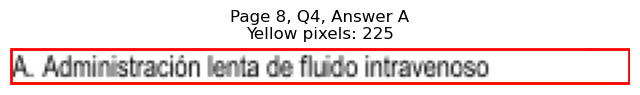

Page 8, Q4 - B: Detected box: x0=56.6, y0=329.2, x1=248.4, y1=341.8
Page 8, Q4, B: Yellow pixels: 2199
Page 8, Q4, B: Total non-white pixels: 2938
Page 8, Q4, B: Yellow percentage: 74.8%


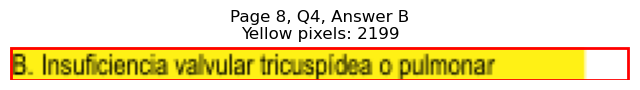

Page 8, Q4 - C: Detected box: x0=315.4, y0=316.6, x1=500.6, y1=329.2
Page 8, Q4, C: Yellow pixels: 0
Page 8, Q4, C: Total non-white pixels: 910
Page 8, Q4, C: Yellow percentage: 0.0%


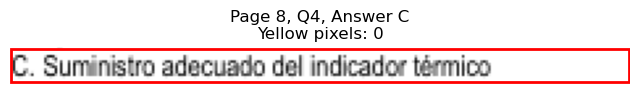

Page 8, Q4 - D: Detected box: x0=315.4, y0=329.2, x1=407.3, y1=341.8
Page 8, Q4, D: Yellow pixels: 0
Page 8, Q4, D: Total non-white pixels: 436
Page 8, Q4, D: Yellow percentage: 0.0%


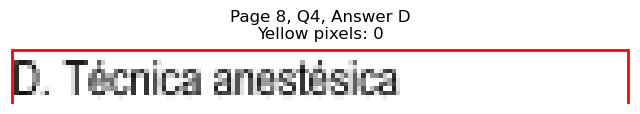


Page 8, Q4 - Selected Answer: B (based on yellow pixel count)
Page 8, Q5 - A: Detected box: x0=56.6, y0=367.1, x1=109.9, y1=379.8
Page 8, Q5, A: Yellow pixels: 0
Page 8, Q5, A: Total non-white pixels: 239
Page 8, Q5, A: Yellow percentage: 0.0%


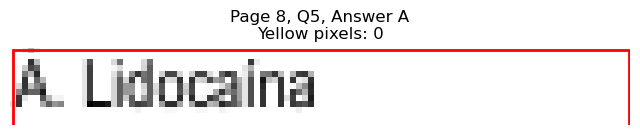

Page 8, Q5 - B: Detected box: x0=56.6, y0=379.7, x1=120.5, y1=392.4
Page 8, Q5, B: Yellow pixels: 0
Page 8, Q5, B: Total non-white pixels: 321
Page 8, Q5, B: Yellow percentage: 0.0%


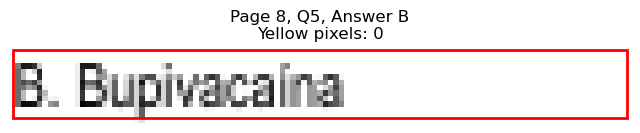

Page 8, Q5 - C: Detected box: x0=315.4, y0=367.1, x1=373.1, y1=379.8
Page 8, Q5, C: Yellow pixels: 0
Page 8, Q5, C: Total non-white pixels: 361
Page 8, Q5, C: Yellow percentage: 0.0%


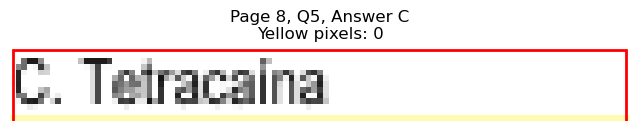

Page 8, Q5 - D: Detected box: x0=315.4, y0=379.7, x1=366.2, y1=392.4
Page 8, Q5, D: Yellow pixels: 1062
Page 8, Q5, D: Total non-white pixels: 1428
Page 8, Q5, D: Yellow percentage: 74.4%


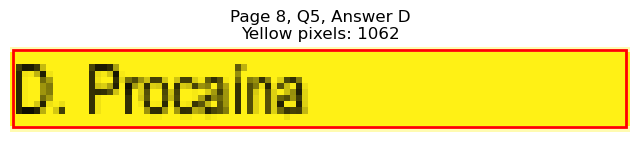


Page 8, Q5 - Selected Answer: D (based on yellow pixel count)
Page 8, Q6 - A: Detected box: x0=56.6, y0=455.5, x1=118.9, y1=468.1
Page 8, Q6, A: Yellow pixels: 113
Page 8, Q6, A: Total non-white pixels: 382
Page 8, Q6, A: Yellow percentage: 29.6%


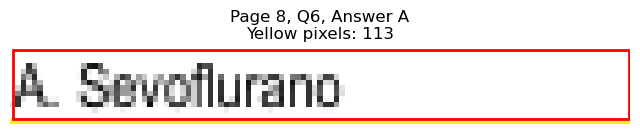

Page 8, Q6 - B: Detected box: x0=56.6, y0=468.1, x1=125.4, y1=480.7
Page 8, Q6, B: Yellow pixels: 1291
Page 8, Q6, B: Total non-white pixels: 1560
Page 8, Q6, B: Yellow percentage: 82.8%


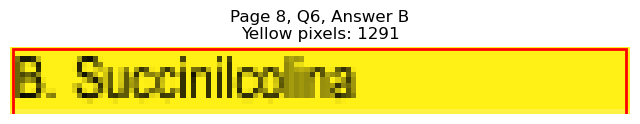

Page 8, Q6 - C: Detected box: x0=315.4, y0=455.5, x1=367.1, y1=468.1
Page 8, Q6, C: Yellow pixels: 0
Page 8, Q6, C: Total non-white pixels: 236
Page 8, Q6, C: Yellow percentage: 0.0%


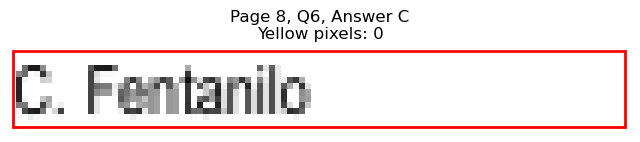

Page 8, Q6 - D: Detected box: x0=315.4, y0=468.1, x1=390.8, y1=480.7
Page 8, Q6, D: Yellow pixels: 0
Page 8, Q6, D: Total non-white pixels: 357
Page 8, Q6, D: Yellow percentage: 0.0%


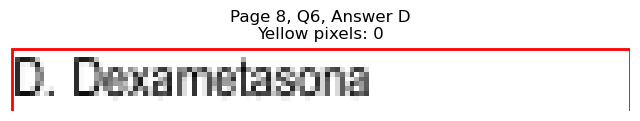


Page 8, Q6 - Selected Answer: B (based on yellow pixel count)
Page 8, Q7 - A: Detected box: x0=56.6, y0=506.0, x1=153.5, y1=518.6
Page 8, Q7, A: Yellow pixels: 1554
Page 8, Q7, A: Total non-white pixels: 2072
Page 8, Q7, A: Yellow percentage: 75.0%


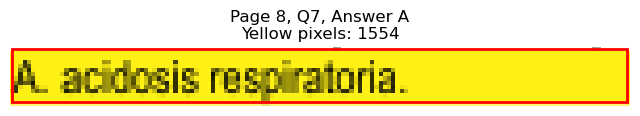

Page 8, Q7 - B: Detected box: x0=56.6, y0=518.6, x1=155.5, y1=531.2
Page 8, Q7, B: Yellow pixels: 150
Page 8, Q7, B: Total non-white pixels: 636
Page 8, Q7, B: Yellow percentage: 23.6%


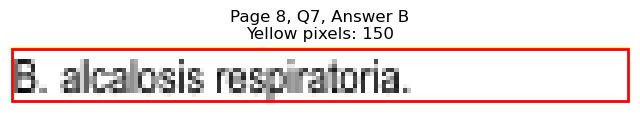

Page 8, Q7 - C: Detected box: x0=315.4, y0=506.0, x1=413.3, y1=518.6
Page 8, Q7, C: Yellow pixels: 0
Page 8, Q7, C: Total non-white pixels: 473
Page 8, Q7, C: Yellow percentage: 0.0%


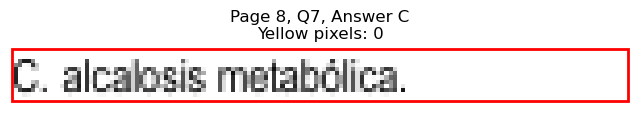

Page 8, Q7 - D: Detected box: x0=315.4, y0=518.6, x1=411.3, y1=531.2
Page 8, Q7, D: Yellow pixels: 0
Page 8, Q7, D: Total non-white pixels: 471
Page 8, Q7, D: Yellow percentage: 0.0%


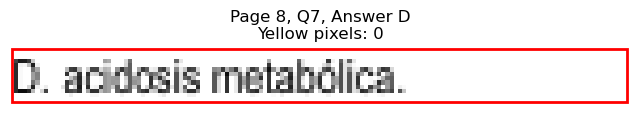


Page 8, Q7 - Selected Answer: A (based on yellow pixel count)
Page 8, Q8 - A: Detected box: x0=56.6, y0=569.1, x1=144.5, y1=581.7
Page 8, Q8, A: Yellow pixels: 0
Page 8, Q8, A: Total non-white pixels: 421
Page 8, Q8, A: Yellow percentage: 0.0%


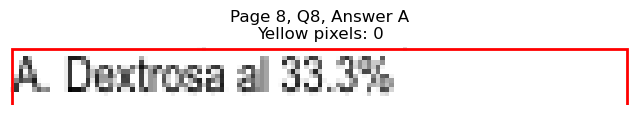

Page 8, Q8 - B: Detected box: x0=56.6, y0=581.7, x1=121.5, y1=594.3
Page 8, Q8, B: Yellow pixels: 0
Page 8, Q8, B: Total non-white pixels: 318
Page 8, Q8, B: Yellow percentage: 0.0%


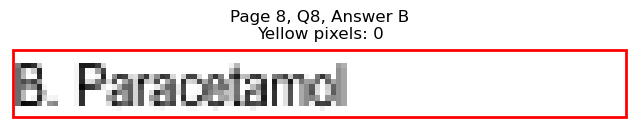

Page 8, Q8 - C: Detected box: x0=315.4, y0=569.1, x1=371.2, y1=581.7
Page 8, Q8, C: Yellow pixels: 0
Page 8, Q8, C: Total non-white pixels: 371
Page 8, Q8, C: Yellow percentage: 0.0%


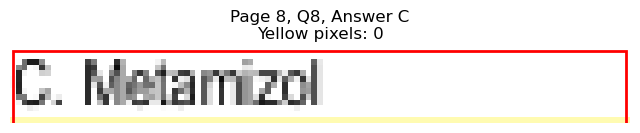

Page 8, Q8 - D: Detected box: x0=315.4, y0=581.7, x1=378.3, y1=594.3
Page 8, Q8, D: Yellow pixels: 1135
Page 8, Q8, D: Total non-white pixels: 1596
Page 8, Q8, D: Yellow percentage: 71.1%


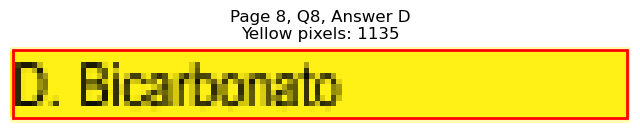


Page 8, Q8 - Selected Answer: D (based on yellow pixel count)
Page 8, Q9 - A: Detected box: x0=56.6, y0=632.2, x1=195.7, y1=644.9
Page 8, Q9, A: Yellow pixels: 0
Page 8, Q9, A: Total non-white pixels: 679
Page 8, Q9, A: Yellow percentage: 0.0%


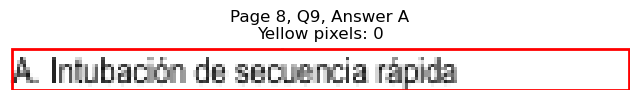

Page 8, Q9 - B: Detected box: x0=56.6, y0=644.8, x1=206.8, y1=657.5
Page 8, Q9, B: Yellow pixels: 0
Page 8, Q9, B: Total non-white pixels: 765
Page 8, Q9, B: Yellow percentage: 0.0%


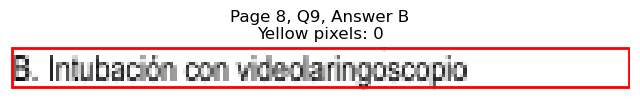

Page 8, Q9 - C: Detected box: x0=315.4, y0=632.2, x1=399.9, y1=644.9
Page 8, Q9, C: Yellow pixels: 1422
Page 8, Q9, C: Total non-white pixels: 1755
Page 8, Q9, C: Yellow percentage: 81.0%


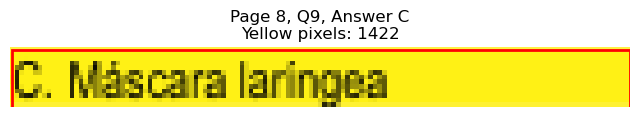

Page 8, Q9 - D: Detected box: x0=315.4, y0=644.8, x1=517.2, y1=657.5
Page 8, Q9, D: Yellow pixels: 0
Page 8, Q9, D: Total non-white pixels: 1016
Page 8, Q9, D: Yellow percentage: 0.0%


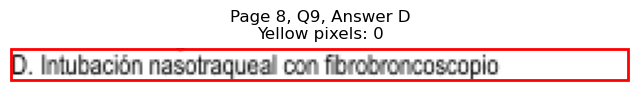


Page 8, Q9 - Selected Answer: C (based on yellow pixel count)
Page 8, Q10 - A: Detected box: x0=56.6, y0=695.4, x1=112.5, y1=708.0
Page 8, Q10, A: Yellow pixels: 0
Page 8, Q10, A: Total non-white pixels: 258
Page 8, Q10, A: Yellow percentage: 0.0%


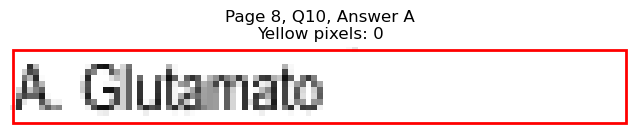

Page 8, Q10 - B: Detected box: x0=56.6, y0=708.0, x1=115.0, y1=720.6
Page 8, Q10, B: Yellow pixels: 0
Page 8, Q10, B: Total non-white pixels: 277
Page 8, Q10, B: Yellow percentage: 0.0%


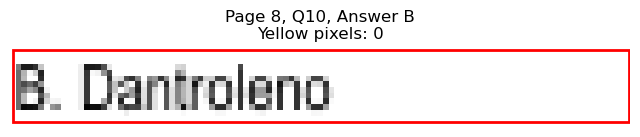

Page 8, Q10 - C: Detected box: x0=315.4, y0=695.4, x1=370.1, y1=708.0
Page 8, Q10, C: Yellow pixels: 1186
Page 8, Q10, C: Total non-white pixels: 1378
Page 8, Q10, C: Yellow percentage: 86.1%


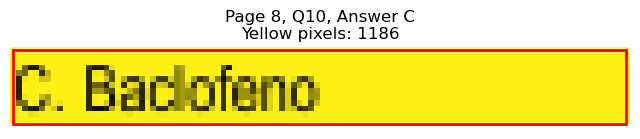

Page 8, Q10 - D: Detected box: x0=315.4, y0=708.0, x1=378.2, y1=720.6
Page 8, Q10, D: Yellow pixels: 114
Page 8, Q10, D: Total non-white pixels: 417
Page 8, Q10, D: Yellow percentage: 27.3%


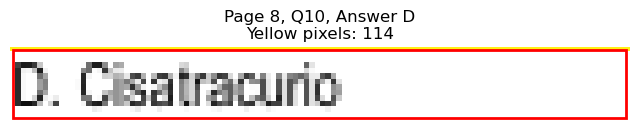


Page 8, Q10 - Selected Answer: C (based on yellow pixel count)
Page 8, Q11 - A: Detected box: x0=56.6, y0=745.8, x1=109.0, y1=758.4
Page 8, Q11, A: Yellow pixels: 0
Page 8, Q11, A: Total non-white pixels: 242
Page 8, Q11, A: Yellow percentage: 0.0%


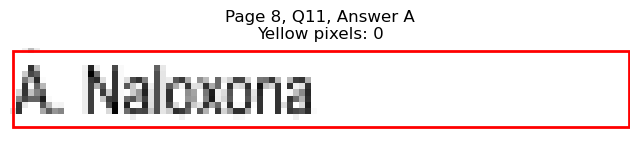

Page 8, Q11 - B: Detected box: x0=56.6, y0=758.5, x1=126.5, y1=771.1
Page 8, Q11, B: Yellow pixels: 1307
Page 8, Q11, B: Total non-white pixels: 1694
Page 8, Q11, B: Yellow percentage: 77.2%


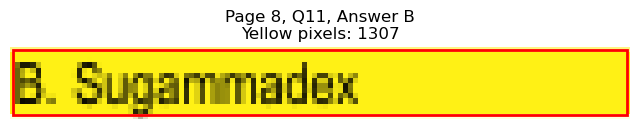

Page 8, Q11 - C: Detected box: x0=315.4, y0=745.8, x1=363.7, y1=758.4
Page 8, Q11, C: Yellow pixels: 0
Page 8, Q11, C: Total non-white pixels: 229
Page 8, Q11, C: Yellow percentage: 0.0%


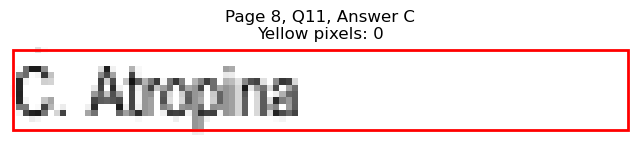

Page 8, Q11 - D: Detected box: x0=315.4, y0=758.5, x1=377.8, y1=771.1
Page 8, Q11, D: Yellow pixels: 0
Page 8, Q11, D: Total non-white pixels: 336
Page 8, Q11, D: Yellow percentage: 0.0%


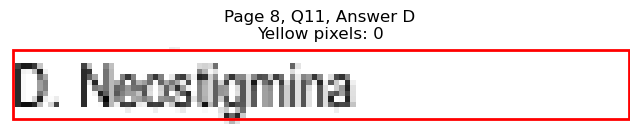


Page 8, Q11 - Selected Answer: B (based on yellow pixel count)

Page 9: Found 9 questions
Page 9, Q1 - A: Detected box: x0=56.6, y0=89.4, x1=110.9, y1=102.1
Page 9, Q1, A: Yellow pixels: 0
Page 9, Q1, A: Total non-white pixels: 239
Page 9, Q1, A: Yellow percentage: 0.0%


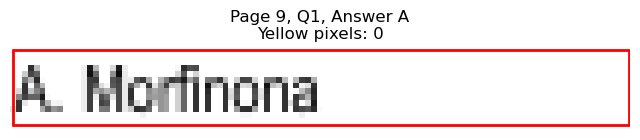

Page 9, Q1 - B: Detected box: x0=56.6, y0=102.0, x1=122.4, y1=114.7
Page 9, Q1, B: Yellow pixels: 0
Page 9, Q1, B: Total non-white pixels: 325
Page 9, Q1, B: Yellow percentage: 0.0%


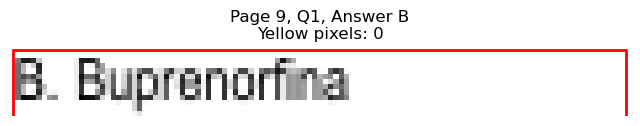

Page 9, Q1 - C: Detected box: x0=315.4, y0=89.4, x1=362.8, y1=102.1
Page 9, Q1, C: Yellow pixels: 1110
Page 9, Q1, C: Total non-white pixels: 1372
Page 9, Q1, C: Yellow percentage: 80.9%


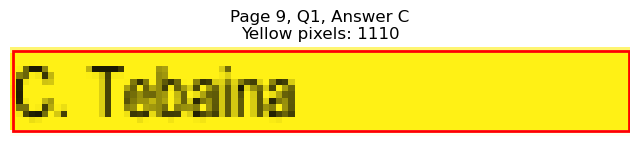

Page 9, Q1 - D: Detected box: x0=315.4, y0=102.0, x1=370.1, y1=114.7
Page 9, Q1, D: Yellow pixels: 0
Page 9, Q1, D: Total non-white pixels: 369
Page 9, Q1, D: Yellow percentage: 0.0%


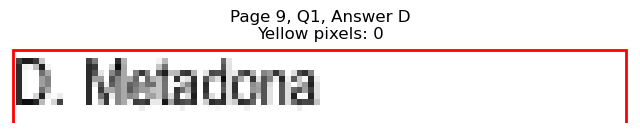


Page 9, Q1 - Selected Answer: C (based on yellow pixel count)
Page 9, Q2 - A: Detected box: x0=56.6, y0=139.9, x1=142.6, y1=152.6
Page 9, Q2, A: Yellow pixels: 0
Page 9, Q2, A: Total non-white pixels: 408
Page 9, Q2, A: Yellow percentage: 0.0%


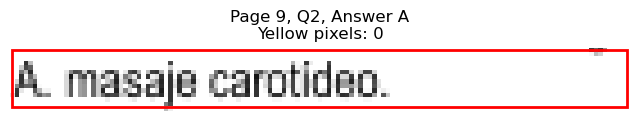

Page 9, Q2 - B: Detected box: x0=56.6, y0=152.5, x1=130.1, y1=165.2
Page 9, Q2, B: Yellow pixels: 0
Page 9, Q2, B: Total non-white pixels: 389
Page 9, Q2, B: Yellow percentage: 0.0%


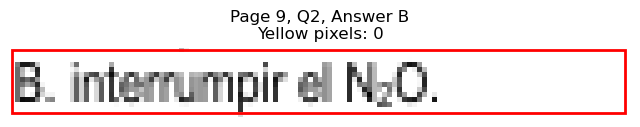

Page 9, Q2 - C: Detected box: x0=315.4, y0=139.9, x1=411.3, y1=152.6
Page 9, Q2, C: Yellow pixels: 1547
Page 9, Q2, C: Total non-white pixels: 2058
Page 9, Q2, C: Yellow percentage: 75.2%


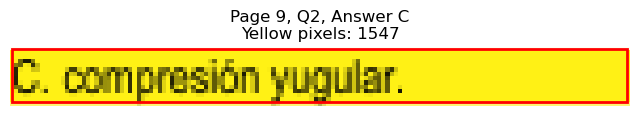

Page 9, Q2 - D: Detected box: x0=315.4, y0=152.5, x1=413.3, y1=165.2
Page 9, Q2, D: Yellow pixels: 147
Page 9, Q2, D: Total non-white pixels: 617
Page 9, Q2, D: Yellow percentage: 23.8%


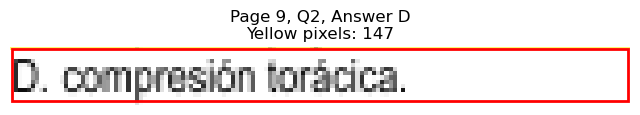


Page 9, Q2 - Selected Answer: C (based on yellow pixel count)
Page 9, Q3 - A: Detected box: x0=56.6, y0=190.3, x1=107.9, y1=203.0
Page 9, Q3, A: Yellow pixels: 1158
Page 9, Q3, A: Total non-white pixels: 1326
Page 9, Q3, A: Yellow percentage: 87.3%


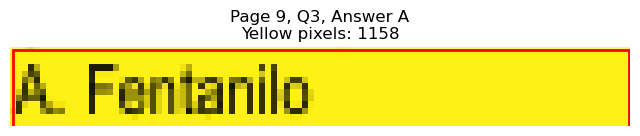

Page 9, Q3 - B: Detected box: x0=56.6, y0=202.9, x1=100.9, y1=215.6
Page 9, Q3, B: Yellow pixels: 95
Page 9, Q3, B: Total non-white pixels: 297
Page 9, Q3, B: Yellow percentage: 32.0%


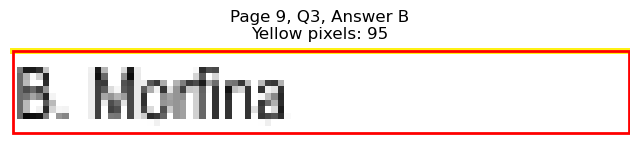

Page 9, Q3 - C: Detected box: x0=315.4, y0=190.3, x1=388.7, y1=203.0
Page 9, Q3, C: Yellow pixels: 0
Page 9, Q3, C: Total non-white pixels: 368
Page 9, Q3, C: Yellow percentage: 0.0%


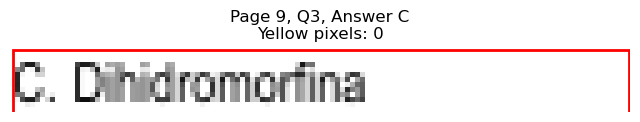

Page 9, Q3 - D: Detected box: x0=315.4, y0=202.9, x1=364.1, y1=215.6
Page 9, Q3, D: Yellow pixels: 0
Page 9, Q3, D: Total non-white pixels: 227
Page 9, Q3, D: Yellow percentage: 0.0%


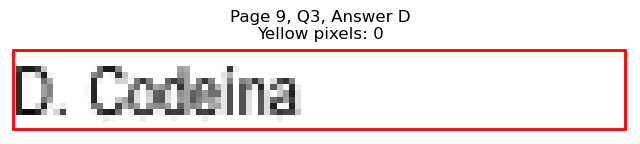


Page 9, Q3 - Selected Answer: A (based on yellow pixel count)
Page 9, Q4 - A: Detected box: x0=56.6, y0=253.4, x1=124.0, y1=266.1
Page 9, Q4, A: Yellow pixels: 0
Page 9, Q4, A: Total non-white pixels: 312
Page 9, Q4, A: Yellow percentage: 0.0%


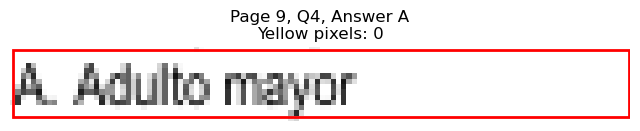

Page 9, Q4 - B: Detected box: x0=56.6, y0=266.0, x1=150.5, y1=278.7
Page 9, Q4, B: Yellow pixels: 0
Page 9, Q4, B: Total non-white pixels: 442
Page 9, Q4, B: Yellow percentage: 0.0%


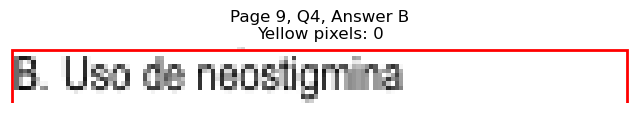

Page 9, Q4 - C: Detected box: x0=315.4, y0=253.4, x1=475.1, y1=266.1
Page 9, Q4, C: Yellow pixels: 2145
Page 9, Q4, C: Total non-white pixels: 2954
Page 9, Q4, C: Yellow percentage: 72.6%


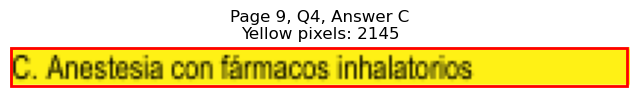

Page 9, Q4 - D: Detected box: x0=315.4, y0=266.0, x1=411.3, y1=278.7
Page 9, Q4, D: Yellow pixels: 0
Page 9, Q4, D: Total non-white pixels: 623
Page 9, Q4, D: Yellow percentage: 0.0%


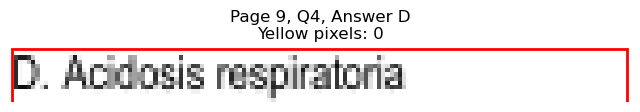


Page 9, Q4 - Selected Answer: C (based on yellow pixel count)
Page 9, Q5 - A: Detected box: x0=56.6, y0=316.6, x1=100.9, y1=329.2
Page 9, Q5, A: Yellow pixels: 95
Page 9, Q5, A: Total non-white pixels: 295
Page 9, Q5, A: Yellow percentage: 32.2%


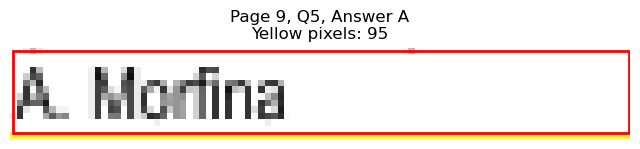

Page 9, Q5 - B: Detected box: x0=56.6, y0=329.2, x1=109.0, y1=341.8
Page 9, Q5, B: Yellow pixels: 1149
Page 9, Q5, B: Total non-white pixels: 1339
Page 9, Q5, B: Yellow percentage: 85.8%


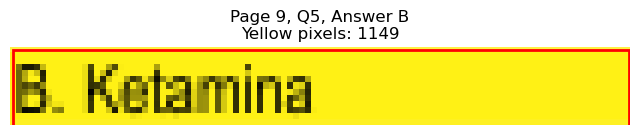

Page 9, Q5 - C: Detected box: x0=315.4, y0=543.8, x1=369.7, y1=556.4
Page 9, Q5, C: Yellow pixels: 0
Page 9, Q5, C: Total non-white pixels: 255
Page 9, Q5, C: Yellow percentage: 0.0%


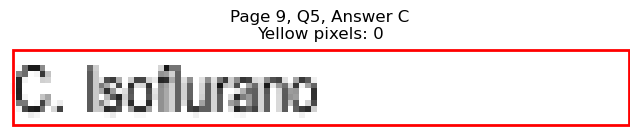

Page 9, Q5 - D: Detected box: x0=315.4, y0=329.2, x1=367.1, y1=341.8
Page 9, Q5, D: Yellow pixels: 0
Page 9, Q5, D: Total non-white pixels: 240
Page 9, Q5, D: Yellow percentage: 0.0%


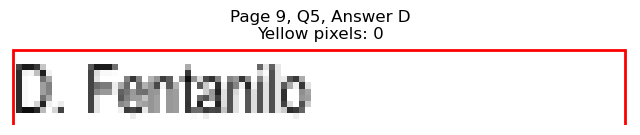


Page 9, Q5 - Selected Answer: B (based on yellow pixel count)
Page 9, Q6 - A: Detected box: x0=56.6, y0=367.1, x1=94.0, y1=379.8
Page 9, Q6, A: Yellow pixels: 1027
Page 9, Q6, A: Total non-white pixels: 1144
Page 9, Q6, A: Yellow percentage: 89.8%


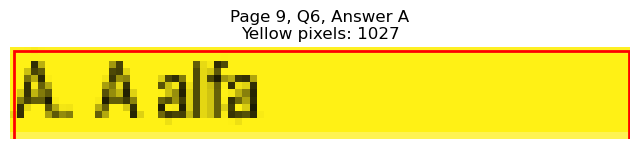

Page 9, Q6 - B: Detected box: x0=56.6, y0=379.7, x1=99.0, y1=392.4
Page 9, Q6, B: Yellow pixels: 94
Page 9, Q6, B: Total non-white pixels: 286
Page 9, Q6, B: Yellow percentage: 32.9%


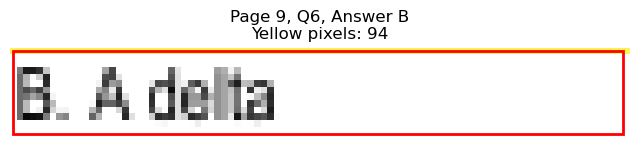

Page 9, Q6 - C: Detected box: x0=315.4, y0=367.1, x1=356.2, y1=379.8
Page 9, Q6, C: Yellow pixels: 0
Page 9, Q6, C: Total non-white pixels: 171
Page 9, Q6, C: Yellow percentage: 0.0%


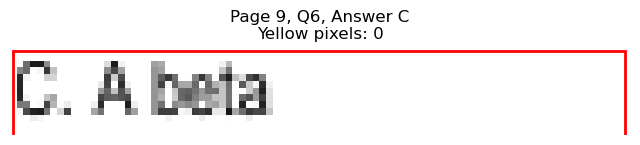

Page 9, Q6 - D: Detected box: x0=315.4, y0=379.7, x1=336.5, y1=392.4
Page 9, Q6, D: Yellow pixels: 0
Page 9, Q6, D: Total non-white pixels: 73
Page 9, Q6, D: Yellow percentage: 0.0%


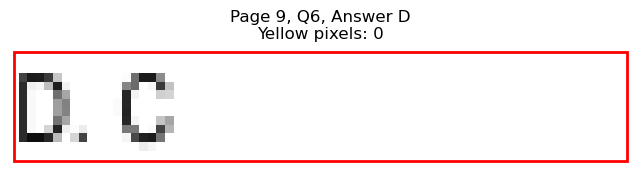


Page 9, Q6 - Selected Answer: A (based on yellow pixel count)
Page 9, Q7 - A: Detected box: x0=56.6, y0=430.2, x1=130.0, y1=442.9
Page 9, Q7, A: Yellow pixels: 0
Page 9, Q7, A: Total non-white pixels: 419
Page 9, Q7, A: Yellow percentage: 0.0%


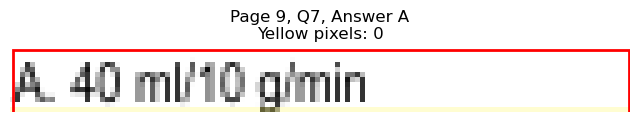

Page 9, Q7 - B: Detected box: x0=56.6, y0=442.8, x1=135.0, y1=455.5
Page 9, Q7, B: Yellow pixels: 1387
Page 9, Q7, B: Total non-white pixels: 1820
Page 9, Q7, B: Yellow percentage: 76.2%


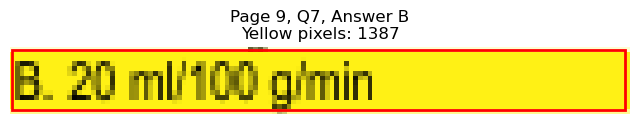

Page 9, Q7 - C: Detected box: x0=315.4, y0=430.2, x1=394.3, y1=442.9
Page 9, Q7, C: Yellow pixels: 0
Page 9, Q7, C: Total non-white pixels: 369
Page 9, Q7, C: Yellow percentage: 0.0%


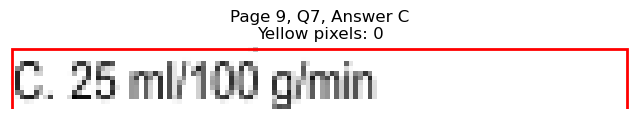

Page 9, Q7 - D: Detected box: x0=315.4, y0=442.8, x1=394.3, y1=455.5
Page 9, Q7, D: Yellow pixels: 0
Page 9, Q7, D: Total non-white pixels: 382
Page 9, Q7, D: Yellow percentage: 0.0%


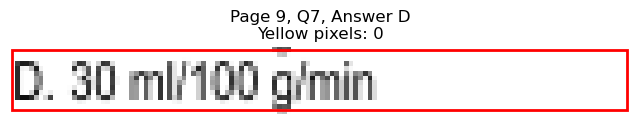


Page 9, Q7 - Selected Answer: B (based on yellow pixel count)
Page 9, Q8 - A: Detected box: x0=56.6, y0=493.4, x1=103.9, y1=506.0
Page 9, Q8, A: Yellow pixels: 98
Page 9, Q8, A: Total non-white pixels: 403
Page 9, Q8, A: Yellow percentage: 24.3%


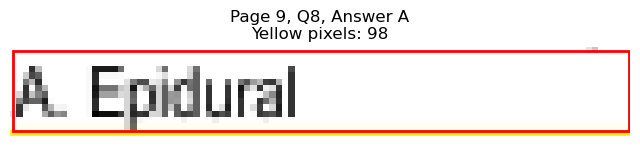

Page 9, Q8 - B: Detected box: x0=56.6, y0=506.0, x1=102.9, y1=518.6
Page 9, Q8, B: Yellow pixels: 1103
Page 9, Q8, B: Total non-white pixels: 1358
Page 9, Q8, B: Yellow percentage: 81.2%


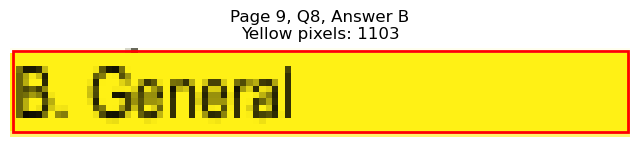

Page 9, Q8 - C: Detected box: x0=315.4, y0=493.4, x1=369.2, y1=506.0
Page 9, Q8, C: Yellow pixels: 0
Page 9, Q8, C: Total non-white pixels: 264
Page 9, Q8, C: Yellow percentage: 0.0%


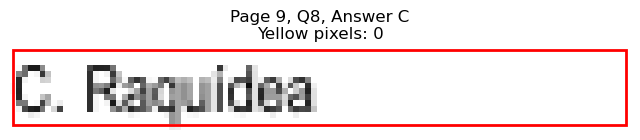

Page 9, Q8 - D: Detected box: x0=315.4, y0=506.0, x1=410.8, y1=518.6
Page 9, Q8, D: Yellow pixels: 0
Page 9, Q8, D: Total non-white pixels: 472
Page 9, Q8, D: Yellow percentage: 0.0%


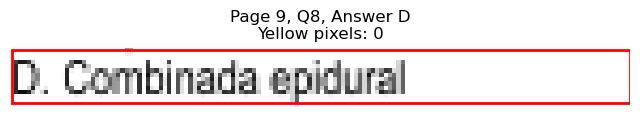


Page 9, Q8 - Selected Answer: B (based on yellow pixel count)
Page 9, Q9 - A: Detected box: x0=56.6, y0=543.8, x1=106.9, y1=556.4
Page 9, Q9, A: Yellow pixels: 1148
Page 9, Q9, A: Total non-white pixels: 1414
Page 9, Q9, A: Yellow percentage: 81.2%


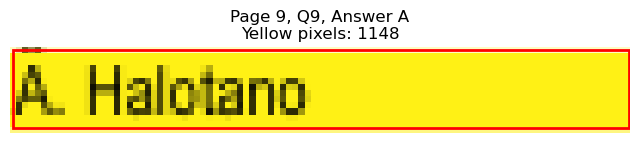

Page 9, Q9 - B: Detected box: x0=56.6, y0=556.5, x1=118.9, y1=569.1
Page 9, Q9, B: Yellow pixels: 113
Page 9, Q9, B: Total non-white pixels: 389
Page 9, Q9, B: Yellow percentage: 29.0%


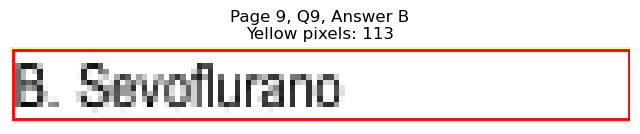

Page 9, Q9 - C: Detected box: x0=315.4, y0=543.8, x1=369.7, y1=556.4
Page 9, Q9, C: Yellow pixels: 0
Page 9, Q9, C: Total non-white pixels: 255
Page 9, Q9, C: Yellow percentage: 0.0%


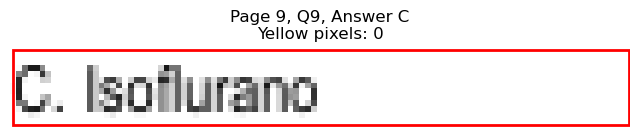

Page 9, Q9 - D: Detected box: x0=315.4, y0=556.5, x1=373.7, y1=569.1
Page 9, Q9, D: Yellow pixels: 0
Page 9, Q9, D: Total non-white pixels: 281
Page 9, Q9, D: Yellow percentage: 0.0%


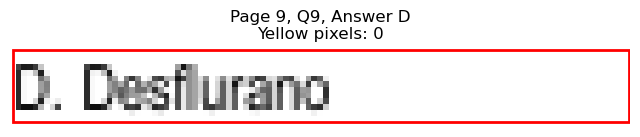


Page 9, Q9 - Selected Answer: A (based on yellow pixel count)


In [6]:
questions_df = extract_questions(pdf_path = pdf_file)
answers_df = extract_answers(pdf_path = pdf_file)
correct_answers_df = extract_correct_answers(pdf_path = pdf_file)

In [7]:
questions_df

question
0   En cirugía cardíaca. ¿Cuál es el cambio fisiol...
1   ¿Cuál es factor de riesgo, relacionado con cir...
2   ¿Cuál es factor de riesgo moderado para trombo...
3   ¿Cuál es el anestésico local tipo amida, con i...
4   Varón de 59 años, obeso, sin otro antecedente ...
..                                                ...
95  Mujer de 45 años, con asma crónica no controla...
96  ¿Cuál es la fibra de dolor localizada en los e...
97  El flujo sanguíneo cerebral normal de la susta...
98  Gestante 38 semanas, ASA II, con antecedente d...
99  ¿Cuál es el anestésico volátil que tiene mayor...

[100 rows x 1 columns]

In [8]:
answers_df

option_A  \
0   Aumenta la presión por debajo de la pinza   
1                    Alteraciones sensoriales   
2                           Disfibrinogenemia   
3                                 Mepivacaína   
4                       Reacción anafiláctica   
..                                        ...   
95                                    Morfina   
96                                     A alfa   
97                             40 ml/10 g/min   
98                                   Epidural   
99                                   Halotano   

                                  option_B  \
0   Disminución de la fracción de eyección   
1               Cirugía abdominal superior   
2                       Déficit proteína C   
3                                 Procaína   
4                     Infección bacteriana   
..                                     ...   
95                                Ketamina   
96                                 A delta   
97                         20 ml/100 g/min   
98                                 General   
99                             Sevoflurano   

                                        option_C  \
0   Disminución de la adrenalina y noradrenalina   
1                                     Tabaquismo   
2                        Déficit de antitrombina   
3                                   Clorprocaína   
4                        Hemólisis transfusional   
..                                           ...   
95                                    Isoflurano   
96                                        A beta   
97                               25 ml/100 g/min   
98                                      Raquídea   
99                                    Isoflurano   

                                     option_D  
0   Disminución del flujo sanguíneo coronario  
1                        Cirugía artroscópica  
2       Trombocitopenia inducida por heparina  
3                                  Tetracaína  
4                       Lesión pulmonar aguda  
..                                        ...  
95                                  Fentanilo  
96                                          C  
97                            30 ml/100 g/min  
98                         Combinada epidural  
99                                 Desflurano  

[100 rows x 4 columns]

In [9]:
correct_answers_df

correct_answer
0               B
1               B
2               A
3               A
4               D
..            ...
95              B
96              A
97              B
98              B
99              A

[100 rows x 1 columns]

In [10]:
total_df = pd.concat([questions_df, answers_df, correct_answers_df], ignore_index = True, axis = 1)
total_df.columns = ["questions", "option_A", "option_B", "option_C", "option_D", "correct_answer"]
total_df

questions  \
0   En cirugía cardíaca. ¿Cuál es el cambio fisiol...   
1   ¿Cuál es factor de riesgo, relacionado con cir...   
2   ¿Cuál es factor de riesgo moderado para trombo...   
3   ¿Cuál es el anestésico local tipo amida, con i...   
4   Varón de 59 años, obeso, sin otro antecedente ...   
..                                                ...   
95  Mujer de 45 años, con asma crónica no controla...   
96  ¿Cuál es la fibra de dolor localizada en los e...   
97  El flujo sanguíneo cerebral normal de la susta...   
98  Gestante 38 semanas, ASA II, con antecedente d...   
99  ¿Cuál es el anestésico volátil que tiene mayor...   

                                     option_A  \
0   Aumenta la presión por debajo de la pinza   
1                    Alteraciones sensoriales   
2                           Disfibrinogenemia   
3                                 Mepivacaína   
4                       Reacción anafiláctica   
..                                        ...   
95                                    Morfina   
96                                     A alfa   
97                             40 ml/10 g/min   
98                                   Epidural   
99                                   Halotano   

                                  option_B  \
0   Disminución de la fracción de eyección   
1               Cirugía abdominal superior   
2                       Déficit proteína C   
3                                 Procaína   
4                     Infección bacteriana   
..                                     ...   
95                                Ketamina   
96                                 A delta   
97                         20 ml/100 g/min   
98                                 General   
99                             Sevoflurano   

                                        option_C  \
0   Disminución de la adrenalina y noradrenalina   
1                                     Tabaquismo   
2                        Déficit de antitrombina   
3                                   Clorprocaína   
4                        Hemólisis transfusional   
..                                           ...   
95                                    Isoflurano   
96                                        A beta   
97                               25 ml/100 g/min   
98                                      Raquídea   
99                                    Isoflurano   

                                     option_D correct_answer  
0   Disminución del flujo sanguíneo coronario              B  
1                        Cirugía artroscópica              B  
2       Trombocitopenia inducida por heparina              A  
3                                  Tetracaína              A  
4                       Lesión pulmonar aguda              D  
..                                        ...            ...  
95                                  Fentanilo              B  
96                                          C              A  
97                            30 ml/100 g/min              B  
98                         Combinada epidural              B  
99                                 Desflurano              A  

[100 rows x 6 columns]

In [11]:
# Extract folder path
folder_path = os.path.dirname(pdf_file)  # Gets the directory path

# Extract filename without extension
file_name = os.path.splitext(os.path.basename(pdf_file))[0]  # Removes the .pdf extension

# Create CSV file path
csv_file = os.path.join(folder_path, f"{file_name}.csv")

# Save a sample DataFrame
total_df.to_csv(csv_file, index=False, encoding="utf-8-sig")
print(f"CSV saved at: {csv_file}")


CSV saved at: /Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2024/ANESTESIOLOGÍA.csv
